# Análise da comparação contexto e as palavras das sentenças do CohQuAD In pt-br. 

Realiza a análise da comparação das palavras das sentenças dos documentos originais e perturbados com o contexto do conjunto de dados utilizando o arquivo:

- `comparacao_contexto_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 


# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documentoLimpo = re.compile("<.*?>")
    return re.sub(documentoLimpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

## 1.4 Identificando o ambiente Colab

In [12]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
device = getDeviceGPU()

Conecta o modelo ao device

In [16]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [17]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [18]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [19]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 162 kB 38.9 MB/s 
     |████████████████████████████████| 181 kB 36.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 158 kB 46.1 MB/s 
     |████████████████████████████████| 157 kB 53.9 MB/s 
     |████████████████████████████████| 157 kB 54.0 MB/s 
     |████████████████████████████████| 157 kB 45.9 MB/s 
     |████████████████████████████████| 157 kB 48.8 MB/s 
     |████████████████████████████████| 157 kB 58.0 MB/s 
     |████████████████████████████████| 157 kB 39.0 MB/s 
     |████████████████████████████████| 157 kB 57.7 MB/s 
     |████████████████████████████████| 156 kB 57.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=e1920579b105d02057664f14168d1c2c998079e7d8b424a67d6d4560a87c

# 2 Parametrização

## Gerais

In [20]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 100

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 100

## Específicos

Parâmetros do modelo

In [21]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    
    #pretrained_model_name_or_path = "bert-large-cased",
    #pretrained_model_name_or_path = "bert-base-cased"
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    #modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = True,
    do_lower_case = False,   # default True  
    output_attentions = False,    # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [22]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_IN_PTBR"

## Define o caminho para os arquivos de dados

In [23]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [24]:
# Import das bibliotecas
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação do contexto com as palavras



## 3.1 Carregamento dos arquivos de dados originais

### 3.1.1 Especifica os nomes dos arquivos de dados



In [25]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [26]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [27]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [28]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [29]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

In [30]:
lista_documentos_originais.sample(5)

id                                          sentencas  \
0    1p0        ['Como enfileirar elementos em uma pilha?']   
16  17p0  ['Como são implementadas as operações de empil...   
15  16p0  ['O que é uma pilha e como enfileirar e desenf...   
19  20p0  ['Em uma fila a operação de empilhar ocorre em...   
5    6p0  ['Como empilhar e desempilhar elementos em uma...   

                                            documento  
0             Como enfileirar elementos em uma pilha?  
16  Como são implementadas as operações de empilha...  
15  O que é uma pilha e como enfileirar e desenfil...  
19  Em uma fila a operação de empilhar ocorre em q...  
5   Como empilhar e desempilhar elementos em uma e...

In [31]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais = lista_documentos_originais.astype(tipos)

In [32]:
lista_documentos_originais_pos.sample(5)

id                                      pos_documento
15  16p0  [[['O', 'que', 'é', 'uma', 'pilha', 'e', 'como...
17  18p0  [[['Como', 'são', 'implementadas', 'as', 'oper...
7    8p0  [[['Como', 'desempilhar', 'elementos', 'em', '...
2    3p0  [[['Como', 'empilhar', 'elementos', 'em', 'uma...
5    6p0  [[['Como', 'empilhar', 'e', 'desempilhar', 'el...

In [33]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [34]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

#### Criando dados indexados originais

In [35]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

sentencas  \
id                                                       
1p0          [Como enfileirar elementos em uma pilha?]   
2p0       [Como desenfileirar elementos em uma pilha?]   
3p0             [Como empilhar elementos em uma fila?]   
4p0  [Como empilhar e desempilhar elementos em uma ...   
5p0  [Como empilhar elementos em uma estrutura de d...   

                                             documento  
id                                                      
1p0            Como enfileirar elementos em uma pilha?  
2p0         Como desenfileirar elementos em uma pilha?  
3p0               Como empilhar elementos em uma fila?  
4p0  Como empilhar e desempilhar elementos em uma f...  
5p0  Como empilhar elementos em uma estrutura de da...

In [36]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                    
1p0  [[[Como, enfileirar, elementos, em, uma, pilha...
2p0  [[[Como, desenfileirar, elementos, em, uma, pi...
3p0  [[[Como, empilhar, elementos, em, uma, fila, ?...
4p0  [[[Como, empilhar, e, desempilhar, elementos, ...
5p0  [[[Como, empilhar, elementos, em, uma, estrutu...

#### Carrega o arquivo dos dados perturbados e POS

In [37]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

Alguns csv estão com os nomes das colunas errados

In [38]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [39]:
lista_documentos_perturbados.sample(5)

id                                         perturbado  \
799    8p0_pert_99  ['Como desempilhar elementos em uma estrutura ...   
1538  16p0_pert_38  ['O que é uma pilha e como incorporar e desenf...   
1240  13p0_pert_40  ['O que é uma pilha e como colar um elemento n...   
338    4p0_pert_38  ['Como entrar e desempilhar elementos em uma f...   
1233  13p0_pert_33  ['O que é uma pilha e como vem um elemento nel...   

                                   documento_perturbado  \
799   Como desempilhar elementos em uma estrutura de...   
1538  O que é uma pilha e como incorporar e desenfil...   
1240  O que é uma pilha e como colar um elemento nela ?   
338   Como entrar e desempilhar elementos em uma fila ?   
1233    O que é uma pilha e como vem um elemento nela ?   

                                              sentencas  
799   [['Como desempilhar elementos em uma estrutura...  
1538  [['O que é uma pilha e como [MASK] e desenfile...  
1240  [['O que é uma pilha e como [MASK] um elemento...  
338   [['Como [MASK] e desempilhar elementos em uma ...  
1233  [['O que é uma pilha e como [MASK] um elemento...

In [40]:
lista_documentos_perturbados_pos.sample(5)

id                                      pos_documento
1775  18p0_pert_75  [[['Como', 'são', 'colocadas', 'as', 'operaçõe...
498    5p0_pert_98  [[['Como', 'montar', 'elementos', 'em', 'uma',...
462    5p0_pert_62  [[['Como', 'interpretar', 'elementos', 'em', '...
1020  11p0_pert_20  [[['O', 'que', 'é', 'uma', 'máquina', 'e', 'co...
1823  19p0_pert_23  [[['Em', 'uma', 'pilha', 'a', 'operação', 'de'...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [41]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

#### Criando dados indexados perturbados

In [42]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                        
1p0_pert_0      [Como colocar elementos em uma pilha ?]   
1p0_pert_1    [Como adicionar elementos em uma pilha ?]   
1p0_pert_2    [Como organizar elementos em uma pilha ?]   
1p0_pert_3  [Como identificar elementos em uma pilha ?]   
1p0_pert_4    [Como encontrar elementos em uma pilha ?]   

                                 documento_perturbado  \
id                                                      
1p0_pert_0      Como colocar elementos em uma pilha ?   
1p0_pert_1    Como adicionar elementos em uma pilha ?   
1p0_pert_2    Como organizar elementos em uma pilha ?   
1p0_pert_3  Como identificar elementos em uma pilha ?   
1p0_pert_4    Como encontrar elementos em uma pilha ?   

                                                    sentencas  
id                                                             
1p0_pert_0  [[Como [MASK] elementos em uma pilha ?, enfile...  
1p0_pert_1  [[Como [MASK] elementos em uma pilha ?, enfile...  
1p0_pert_2  [[Como [MASK] elementos em uma pilha ?, enfile...  
1p0_pert_3  [[Como [MASK] elementos em uma pilha ?, enfile...  
1p0_pert_4  [[Como [MASK] elementos em uma pilha ?, enfile...

In [43]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                           
1p0_pert_0  [[[Como, colocar, elementos, em, uma, pilha, ?...
1p0_pert_1  [[[Como, adicionar, elementos, em, uma, pilha,...
1p0_pert_2  [[[Como, organizar, elementos, em, uma, pilha,...
1p0_pert_3  [[[Como, identificar, elementos, em, uma, pilh...
1p0_pert_4  [[[Como, encontrar, elementos, em, uma, pilha,...

### 3.1.5 Agrupar os dados originais e perturbados

In [44]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [45]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])
# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

In [46]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

In [47]:
lista_documentos_agrupados.sample(5)

id                                          sentencas  \
649    7p0_pert_42         [Como desempilhar elementos em uma mesa ?]   
1267  13p0_pert_54  [O que é uma pilha e como mover um elemento ne...   
1087  11p0_pert_76  [O que é uma categoria e como desenfileirar um...   
1154  12p0_pert_42  [O que é uma fila e como usar um elemento nela ?]   
262    3p0_pert_59          [Como substituir elementos em uma fila ?]   

                                              documento  classe  
649            Como desempilhar elementos em uma mesa ?       0  
1267  O que é uma pilha e como mover um elemento nela ?       0  
1087  O que é uma categoria e como desenfileirar um ...       0  
1154    O que é uma fila e como usar um elemento nela ?       0  
262             Como substituir elementos em uma fila ?       0

In [48]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

In [49]:
lista_documentos_agrupados_pos.sample(5)

id                                      pos_documento
526    6p0_pert_26  [[[Como, montar, e, desempilhar, elementos, em...
1838  19p0_pert_38  [[[Em, uma, pilha, a, operação, de, enfileirar...
700     8p0_pert_0  [[[Como, desempilhar, elementos, em, uma, estr...
1012  11p0_pert_12  [[[O, que, é, uma, composição, e, como, desenf...
530    6p0_pert_30  [[[Como, gravar, e, desempilhar, elementos, em...

#### Criar dados indexados

In [50]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                        
1p0           [Como enfileirar elementos em uma pilha?]   
1p0_pert_0      [Como colocar elementos em uma pilha ?]   
1p0_pert_1    [Como adicionar elementos em uma pilha ?]   
1p0_pert_2    [Como organizar elementos em uma pilha ?]   
1p0_pert_3  [Como identificar elementos em uma pilha ?]   

                                            documento  classe  
id                                                             
1p0           Como enfileirar elementos em uma pilha?       1  
1p0_pert_0      Como colocar elementos em uma pilha ?       0  
1p0_pert_1    Como adicionar elementos em uma pilha ?       0  
1p0_pert_2    Como organizar elementos em uma pilha ?       0  
1p0_pert_3  Como identificar elementos em uma pilha ?       0

In [51]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                    
1p0  [[[Como, enfileirar, elementos, em, uma, pilha...
2p0  [[[Como, desenfileirar, elementos, em, uma, pi...
3p0  [[[Como, empilhar, elementos, em, uma, fila, ?...
4p0  [[[Como, empilhar, e, desempilhar, elementos, ...
5p0  [[[Como, empilhar, elementos, em, uma, estrutu...

## 3.2 Carregamento do arquivo de dado comparação palavra e contexto

### 3.2.1 Especifica os nomes dos arquivos de dados



In [52]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [53]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [54]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [55]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

### 3.2.4 Carregamento das lista com os dados do arquivo


In [56]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_contexto = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_CONTEXTO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_contexto))) 

In [57]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  index_wi           wi  \
2028    3p0_pert_86              289               0         5         fila   
12555  13p0_pert_77             1290               0         4        pilha   
19696  19p0_pert_15             1834               0        11            ?   
20339  19p0_pert_69             1888               0         6   enfileirar   
4691    6p0_pert_53              559               0         3  desempilhar   

       pos_i  cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  \
2028    NOUN         0.890293        16.068285         762.8185   
12555   NOUN         0.752768        25.726007        1144.6646   
19696  PUNCT         0.788902        23.529507        1149.6316   
20339   VERB         0.888221        16.037832         771.3895   
4691    NOUN         0.890045        16.694571         823.2029   

       cos_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
2028            0.846418  ...         1159.5220         0.585426   
12555           0.841202  ...          940.9690         0.663597   
19696           0.767365  ...         1165.2305         0.669144   
20339           0.813578  ...         1463.7670         0.719220   
4691            0.852755  ...         1579.8406         0.622956   

       euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
2028         37.545841      1749.133301         0.811813        22.915096   
12555        31.762598      1446.402100         0.905800        16.479053   
19696        30.471666      1471.501221         0.628159        33.671257   
20339        28.844385      1368.204346         0.566060        37.309719   
4691         37.354019      1813.029297         0.675611        32.507511   

       man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
2028         1074.2676             0.769994            25.391422   
12555         751.5681             0.839562            21.195127   
19696        1541.4956             0.676090            30.151106   
20339        1684.4106             0.651949            32.224819   
4691         1612.0912             0.693843            31.584806   

       man_ctxverbnoun_max  
2028            1171.52710  
12555            953.78015  
19696           1398.27670  
20339           1473.37230  
4691            1571.86230  

[5 rows x 36 columns]

Remove as pontuações

In [58]:
#lista_comparacao_contexto = lista_comparacao_contexto.query('pos_i != "PUNCT"')

In [59]:
lista_comparacao_contexto.sample(5)

id  index_documento  index_sentenca  index_wi             wi  \
21573  20p0_pert_71             1991               0         4       operação   
19011  18p0_pert_65             1783               0         8  desenfileirar   
11920  13p0_pert_24             1237               0         5              e   
2322    4p0_pert_21              325               0         3    desempilhar   
11170  12p0_pert_62             1174               0        11              ?   

       pos_i  cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  \
21573   NOUN         0.833072        23.625687        1095.0073   
19011    DET         0.898761        15.057583         737.6765   
11920  CCONJ         0.845020        20.693218        1030.2080   
2322    VERB         0.924429        14.246608         705.8675   
11170  PUNCT         0.833147        21.129486        1054.9941   

       cos_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
21573           0.887027  ...         948.38635         0.727998   
19011           0.839847  ...        1603.23830         0.594554   
11920           0.737045  ...        1295.98190         0.712555   
2322            0.892667  ...        1381.16250         0.787499   
11170           0.787278  ...        1177.05350         0.705919   

       euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
21573        31.732681      1531.982544         0.895575        18.948643   
19011        36.503887      1733.449463         0.541491        38.174450   
11920        29.871778      1467.826782         0.600824        33.959183   
2322         26.421045      1313.933350         0.674294        32.446968   
11170        28.682684      1410.856079         0.633824        32.259243   

       man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
21573         902.3469             0.897818            18.792772   
19011        1801.2031             0.598329            35.493202   
11920        1624.1049             0.714960            28.195827   
2322         1610.8301             0.769431            27.200062   
11170        1595.8751             0.716909            27.538464   

       man_ctxverbnoun_max  
21573             895.1792  
19011            1682.5020  
11920            1378.5312  
2322             1360.4073  
11170            1370.5325  

[5 rows x 36 columns]

### 3.2.5 Criando dados indexados

In [60]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id", "index_sentenca", "index_wi", "pos_i"])
lista_comparacao_contexto_indexado.head()

index_documento          wi  \
id  index_sentenca index_wi pos_i                                
1p0 0              0        SCONJ                0        Como   
                   1        VERB                 0  enfileirar   
                   2        NOUN                 0   elementos   
                   3        ADP                  0          em   
                   4        DET                  0         uma   

                                   cos_ctxall_mean  euc_ctxall_mean  \
id  index_sentenca index_wi pos_i                                     
1p0 0              0        SCONJ         0.841748        20.751820   
                   1        VERB          0.954515        10.737125   
                   2        NOUN          0.814813        24.378838   
                   3        ADP           0.852682        21.636595   
                   4        DET           0.858393        19.244085   

                                   man_ctxall_mean  cos_ctxclean_mean  \
id  index_sentenca index_wi pos_i                                       
1p0 0              0        SCONJ       1034.94150           0.795572   
                   1        VERB         523.81116           0.898605   
                   2        NOUN        1160.39750           0.876309   
                   3        ADP         1064.25120           0.790931   
                   4        DET          930.50085           0.801362   

                                   euc_ctxclean_mean  man_ctxclean_mean  \
id  index_sentenca index_wi pos_i                                         
1p0 0              0        SCONJ          23.499792          1144.7046   
                   1        VERB           15.842593           764.4530   
                   2        NOUN           20.454411           977.4153   
                   3        ADP            25.292688          1225.7642   
                   4        DET            22.730692          1092.4790   

                                   cos_ctxverb_mean  euc_ctxverb_mean  ...  \
id  index_sentenca index_wi pos_i                                      ...   
1p0 0              0        SCONJ          0.761694         25.747263  ...   
                   1        VERB           1.000000          0.000000  ...   
                   2        NOUN           0.720366         29.690674  ...   
                   3        ADP            0.771051         26.600965  ...   
                   4        DET            0.764485         25.204029  ...   

                                   man_ctxclean_max  cos_ctxverb_max  \
id  index_sentenca index_wi pos_i                                      
1p0 0              0        SCONJ         1144.7046         0.761694   
                   1        VERB          1234.6179         0.872167   
                   2        NOUN           977.4153         0.720366   
                   3        ADP           1225.7642         0.771051   
                   4        DET           1092.4790         0.764485   

                                   euc_ctxverb_max  man_ctxverb_max  \
id  index_sentenca index_wi pos_i                                     
1p0 0              0        SCONJ        25.747263      1281.734253   
                   1        VERB         19.438112      1053.671265   
                   2        NOUN         29.690674      1416.652832   
                   3        ADP          26.600965      1313.486572   
                   4        DET          25.204029      1238.603394   

                                   cos_ctxnoun_max  euc_ctxnoun_max  \
id  index_sentenca index_wi pos_i                                     
1p0 0              0        SCONJ         0.662819        31.183723   
                   1        VERB          0.657018        32.020443   
                   2        NOUN          0.925978        15.929137   
                   3        ADP           0.733301        28.994362   
                   4        DET           0.732217        27

## 3.3 Estatísticas

### Colunas medidas discrepantes

In [61]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

### Contexto com todas as palavras(ctxall)

#### Estatísticas das medidas do contexto de todas palavras e as palavras

In [62]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxall_mean", 
                           "euc_ctxall_mean", 
                           "man_ctxall_mean", 
                           "cos_ctxall_max", 
                           "euc_ctxall_max",  
                           "man_ctxall_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
count    21917.000000    21917.000000    21917.000000   21917.000000   
mean         0.815542       22.769637     1091.262665       0.803919   
std          0.072103        3.695844      147.396449       0.070662   
min          0.185986       10.737125      523.811160       0.185986   
25%          0.794802       20.720751     1013.578100       0.781832   
50%          0.824959       22.037470     1081.157800       0.817113   
75%          0.844566       24.762648     1173.660900       0.838777   
max          0.954515       42.080738     1666.877300       0.905457   

      euc_ctxall_max man_ctxall_max  
count   21917.000000   21917.000000  
mean       23.672696    1137.044111  
std         3.316782     133.070497  
min        17.718098     850.644900  
25%        21.150492    1036.715100  
50%        22.754154    1108.221400  
75%        25.740726    1222.423700  
max        42.080738    1666.877300

#### Estatísticas das maiores discrepâncias por documento

In [63]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxall_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxall_mean": [coluna_discrepancia_man],
                                                              "cos_ctxall_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_max": [coluna_discrepancia_euc], 
                                                              "man_ctxall_max": [coluna_discrepancia_man],
                                                              })

In [64]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
                  min             max             max            min   
count     2020.000000     2020.000000     2020.000000    2020.000000   
mean         0.708776       28.809157     1304.346300       0.700051   
std          0.175410        3.899681      121.770574       0.172802   
min          0.185986       20.790045      993.357000       0.185986   
25%          0.731160       26.228582     1217.099650       0.718270   
50%          0.762078       28.492855     1330.410450       0.749986   
75%          0.791235       31.052924     1389.596800       0.784312   
max          0.846861       42.080738     1666.877300       0.846861   

      euc_ctxall_max man_ctxall_max  
                 max            max  
count    2020.000000    2020.000000  
mean       29.125376    1347.826971  
std         3.724458     128.933557  
min        20.983574    1011.523700  
25%        26.675143    1281.901200  
50%        29.020738    1349.191750  
75%        31.052924    1436.124275  
max        42.080738    1666.877300

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [65]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [66]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 2021
2 uma 2020
3 e 1415
4 elementos 1212
5 em 1212
6 fila 1012
7 Como 1010
8 é 814
9 O 808
10 que 808
11 como 808
12 pilha 710
13 de 708
14 elemento 606
15 desempilhar 507
16 um 404
17 nela 404
18 estrutura 305
19 dados 305
20 desenfileirar 304


### Contexto com palavras menos stopswords (ctxclean)

#### Estatísticas das medidas do contexto de todas palavras sen stopwords e as palavras

In [67]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxclean_mean",   
                           "euc_ctxclean_mean", 
                           "man_ctxclean_mean",   
                           "cos_ctxclean_max", 
                           "euc_ctxclean_max",    
                           "man_ctxclean_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
count      21917.000000      21917.000000      21917.000000     21917.000000   
mean           0.783871         24.508816       1164.545709         0.772412   
std            0.093953          3.950912        173.018815         0.092558   
min            0.148969         13.852946        672.883540         0.148969   
25%            0.746768         21.923750       1048.667400         0.738078   
50%            0.797754         24.169489       1162.582300         0.781108   
75%            0.847322         26.465389       1261.822000         0.834240   
max            0.920360         40.750187       1774.981800         0.912413   

      euc_ctxclean_max man_ctxclean_max  
count     21917.000000     21917.000000  
mean         25.353527      1207.293647  
std           3.673964       162.872458  
min          16.645185       803.258200  
25%          22.930696      1108.583300  
50%          24.920790      1193.764200  
75%          27.132849      1292.959000  
max          40.750187      1774.981800

#### Estatísticas das maiores discrepâncias por documento

In [68]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxclean_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_mean": [coluna_discrepancia_man],
                                                              "cos_ctxclean_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_max": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_max": [coluna_discrepancia_man],
                                                              })

In [69]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
                    min               max               max              min   
count       2020.000000       2020.000000       2020.000000      2020.000000   
mean           0.623765         30.772724       1421.883428         0.613960   
std            0.176411          4.767685        189.809337         0.170573   
min            0.148969         22.426176       1101.769800         0.148969   
25%            0.580098         25.822426       1247.136200         0.580098   
50%            0.696038         32.125177       1379.393600         0.648721   
75%            0.754460         34.841785       1623.666800         0.746066   
max            0.817559         40.750187       1774.981800         0.793976   

      euc_ctxclean_max man_ctxclean_max  
                   max              max  
count      2020.000000      2020.000000  
mean         31.482000      1478.265059  
std           4.231880       167.202515  
min          23.255232      1148.335900  
25%          27.324621      1325.209650  
50%          32.339899      1531.269500  
75%          34.841785      1626.995650  
max          40.750187      1774.981800

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [70]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [71]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 2021
2 uma 2020
3 e 1415
4 elementos 1212
5 em 1212
6 fila 1012
7 Como 1010
8 é 814
9 O 808
10 que 808
11 como 808
12 pilha 710
13 de 708
14 elemento 606
15 desempilhar 507
16 um 404
17 nela 404
18 estrutura 305
19 dados 305
20 desenfileirar 304


### Contexto com palavras da classe VERB(ctxverb)

#### Estatísticas das medidas do contexto de palavras da classe VERB e as palavras

In [72]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverb_mean",  
                           "euc_ctxverb_mean", 
                           "man_ctxverb_mean",  
                           "cos_ctxverb_max", 
                           "euc_ctxverb_max",   
                           "man_ctxverb_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
count     20260.000000     20260.000000     20260.000000    20260.000000   
mean          0.716222        28.654743      1368.530809        0.706511   
std           0.116708         7.779623       367.829589        0.116754   
min           0.111985         0.000000         0.000000        0.111985   
25%           0.659953        26.810721      1306.021667        0.648525   
50%           0.707905        29.628299      1432.814697        0.701385   
75%           0.748918        33.113129      1573.336273        0.742697   
max           1.000000        52.019901      2212.333984        1.000000   

      euc_ctxverb_max man_ctxverb_max  
count    20260.000000    20260.000000  
mean        29.340243     1403.018841  
std          7.696245      364.531035  
min          0.000000        0.000000  
25%         27.310514     1334.111420  
50%         30.216292     1452.581909  
75%         33.744778     1607.875732  
max         52.019901     2212.333984

#### Estatísticas das maiores discrepâncias por documento

In [73]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverb_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverb_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_max": [coluna_discrepancia_man],
                                                              })

In [74]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
                   min              max              max             min   
count      1821.000000      1821.000000      1821.000000     1821.000000   
mean          0.556542        36.166166      1654.275774        0.543800   
std           0.162025         3.505373       145.764138        0.155640   
min           0.111985        28.241661      1346.137573        0.111985   
25%           0.539981        33.118973      1549.480469        0.535532   
50%           0.618142        35.732922      1621.332031        0.600891   
75%           0.655896        39.020508      1743.554199        0.630387   
max           0.717667        52.019901      2212.333984        0.717667   

      euc_ctxverb_max man_ctxverb_max  
                  max             max  
count     1821.000000     1821.000000  
mean        36.579101     1696.890837  
std          3.362215      142.184135  
min         29.348795     1364.106812  
25%         33.806648     1589.171631  
50%         36.187534     1689.948120  
75%         39.245029     1780.438477  
max         52.019901     2212.333984

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [75]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]    

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [76]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item]) 

1 ? 2021
2 uma 2020
3 e 1415
4 elementos 1212
5 em 1212
6 fila 1012
7 Como 1010
8 é 814
9 O 808
10 que 808
11 como 808
12 pilha 710
13 de 708
14 elemento 606
15 desempilhar 507
16 um 404
17 nela 404
18 estrutura 305
19 dados 305
20 desenfileirar 304


### Contexto com palavras da classe NOUN(ctxnoun)

#### Estatísticas das medidas do contexto de palavras da classe NOUN e as palavras

In [77]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxnoun_mean",  
                           "euc_ctxnoun_mean", 
                           "man_ctxnoun_mean",  
                           "cos_ctxnoun_max", 
                           "euc_ctxnoun_max",   
                           "man_ctxnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
count     21917.000000     21917.000000     21917.000000    21917.000000   
mean          0.731083        27.473874      1297.556999        0.720316   
std           0.126737         6.379998       298.229059        0.124618   
min           0.133210        12.678499       579.876200        0.133210   
25%           0.655244        22.785503      1079.180300        0.643841   
50%           0.727786        28.383099      1342.104200        0.719429   
75%           0.827704        31.896654      1513.133300        0.795506   
max           0.954686        45.103558      1993.807400        0.954686   

      euc_ctxnoun_max man_ctxnoun_max  
count    21917.000000    21917.000000  
mean        28.246557     1337.149346  
std          6.131016      285.746808  
min         12.678499      579.876200  
25%         24.601370     1188.576400  
50%         28.989351     1379.813500  
75%         32.439251     1546.001000  
max         45.103558     1993.807400

#### Estatísticas das maiores discrepâncias por documento

In [78]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_max": [coluna_discrepancia_man],
                                                              })

In [79]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
                   min              max              max             min   
count      2020.000000      2020.000000      2020.000000     2020.000000   
mean          0.554345        34.951035      1630.842773        0.548512   
std           0.156303         4.553740       181.771583        0.153792   
min           0.133210        25.014093      1227.462900        0.133210   
25%           0.499811        30.893896      1481.368500        0.499811   
50%           0.623339        35.402113      1576.188750        0.558614   
75%           0.670330        39.078294      1820.266425        0.667179   
max           0.765230        45.103558      1993.807400        0.765134   

      euc_ctxnoun_max man_ctxnoun_max  
                  max             max  
count     2020.000000     2020.000000  
mean        35.299972     1661.173966  
std          4.425927      177.131488  
min         25.356081     1248.221700  
25%         31.222271     1492.616800  
50%         36.340803     1700.139450  
75%         39.089067     1823.418200  
max         45.103558     1993.807400

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [80]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [81]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 2021
2 uma 2020
3 e 1415
4 elementos 1212
5 em 1212
6 fila 1012
7 Como 1010
8 é 814
9 O 808
10 que 808
11 como 808
12 pilha 710
13 de 708
14 elemento 606
15 desempilhar 507
16 um 404
17 nela 404
18 estrutura 305
19 dados 305
20 desenfileirar 304


### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### Estatísticas das medidas do contexto de palavras da classe VERB(AUX) e NOUN e as palavras

In [82]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverbnoun_mean",  
                           "euc_ctxverbnoun_mean", 
                           "man_ctxverbnoun_mean",  
                           "cos_ctxverbnoun_max", 
                           "euc_ctxverbnoun_max",   
                           "man_ctxverbnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
count         21917.000000         21917.000000         21917.000000   
mean              0.775107            25.047974          1190.935237   
std               0.095255             4.083796           190.665161   
min               0.143648            13.450162           655.001100   
25%               0.721568            22.133818          1045.048700   
50%               0.778256            25.245285          1198.304200   
75%               0.846128            27.911573          1353.606800   
max               0.941285            40.750755          1689.013500   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count        21917.000000        21917.000000        21917.000000  
mean             0.764025           25.855812         1232.058135  
std              0.094639            3.900297          183.552115  
min              0.143648           14.845482          711.161130  
25%              0.715260           23.471624         1119.202600  
50%              0.762702           26.034010         1243.487700  
75%              0.827891           28.281891         1369.613500  
max              0.941285           40.750755         1774.104700

#### Estatísticas das maiores discrepâncias por documento

In [83]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverbnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverbnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_max": [coluna_discrepancia_man],
                                                              })

In [84]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
                       min                  max                  max   
count          2020.000000          2020.000000          2020.000000   
mean              0.616384            31.381944          1456.190435   
std               0.161226             3.065255            84.432977   
min               0.143648            25.014093          1227.462900   
25%               0.635651            29.050228          1389.365225   
50%               0.665008            31.075078          1452.953150   
75%               0.698160            32.543028          1528.072075   
max               0.765230            40.750755          1689.013500   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
                      min                 max                 max  
count         2020.000000         2020.000000         2020.000000  
mean             0.614114           31.669410         1488.235300  
std              0.160508            3.002033          102.061048  
min              0.143648           25.356081         1248.221700  
25%              0.634367           29.258111         1404.683100  
50%              0.658075           31.489432         1498.461750  
75%              0.696204           32.872234         1551.089725  
max              0.765134           40.750755         1774.104700

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [85]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]
 
    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1        

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

In [86]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 2021
2 uma 2020
3 e 1415
4 elementos 1212
5 em 1212
6 fila 1012
7 Como 1010
8 é 814
9 O 808
10 que 808
11 como 808
12 pilha 710
13 de 708
14 elemento 606
15 desempilhar 507
16 um 404
17 nela 404
18 estrutura 305
19 dados 305
20 desenfileirar 304


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### Contexto com todas as palavras(ctxall)

In [87]:
equacao_medida = "ctxall"

#### COS

In [88]:
medida = "cos"

##### MEAN

In [89]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [90]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     96.000000 0.795549 0.026032 0.726019 0.788310 0.804323 0.812735   
ADP   2037.000000 0.848258 0.023480 0.722255 0.830302 0.845610 0.868841   
ADV   1283.000000 0.836729 0.038586 0.716510 0.813432 0.835812 0.850863   
AUX   1046.000000 0.808175 0.023846 0.741718 0.789564 0.810508 0.825502   
CCONJ 1416.000000 0.736891 0.224660 0.185986 0.815572 0.835174 0.845784   
DET   3508.000000 0.835870 0.024102 0.748395 0.820719 0.835324 0.852778   
NOUN  5448.000000 0.816695 0.044210 0.729457 0.778184 0.814759 0.842372   
NUM      1.000000 0.770896      NaN 0.770896 0.770896 0.770896 0.770896   
PRON  2064.000000 0.779375 0.042172 0.681322 0.748793 0.776303 0.815278   
PROPN    5.000000 0.808443 0.008770 0.794753 0.807570 0.807925 0.814327   
PUNCT 2026.000000 0.818545 0.024346 0.754605 0.798322 0.824855 0.838654   
SCONJ  841.000000 0.821672 0.023128 0.763001 0.802735 0.825641 0.840906   
VERB  2144.000000 0.821660 0.047939 0.677554 0.792281 0.811214 0.846454   
X        2.000000 0.786759 0.012738 0.777752 0.782256 0.786759 0.791263   

           max  
pos_i           
ADJ   0.833398  
ADP   0.905457  
ADV   0.922302  
AUX   0.891467  
CCONJ 0.887877  
DET   0.903707  
NOUN  0.949666  
NUM   0.770896  
PRON  0.873064  
PROPN 0.817641  
PUNCT 0.870139  
SCONJ 0.867479  
VERB  0.954515  
X     0.795767

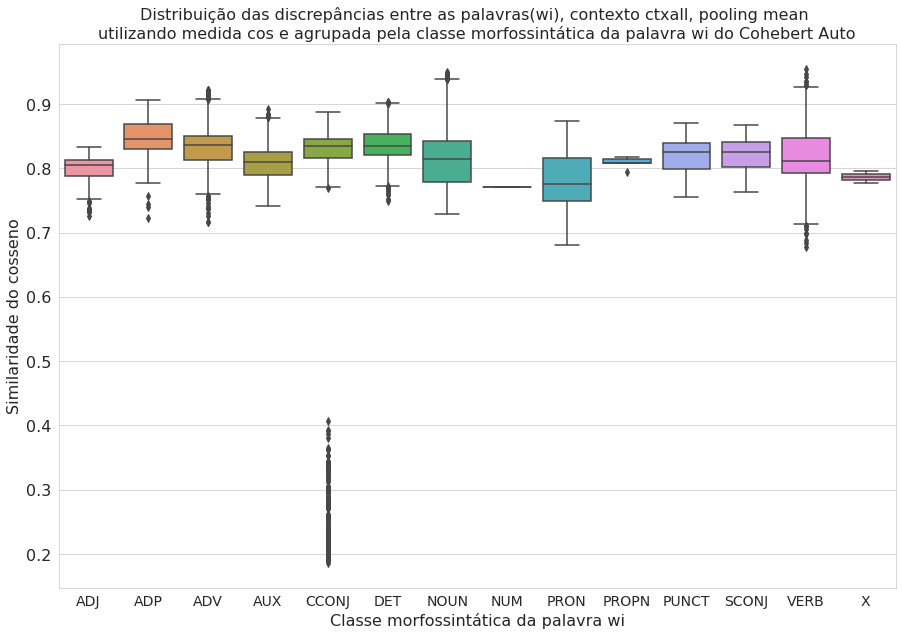

In [91]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [92]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [93]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     96.000000 0.795549 0.026032 0.726019 0.788310 0.804323 0.812735   
ADP   2037.000000 0.848258 0.023480 0.722255 0.830302 0.845610 0.868841   
ADV   1283.000000 0.810448 0.041470 0.673933 0.783590 0.825503 0.840537   
AUX   1046.000000 0.808175 0.023846 0.741718 0.789564 0.810508 0.825502   
CCONJ 1416.000000 0.736891 0.224660 0.185986 0.815572 0.835174 0.845784   
DET   3508.000000 0.829886 0.032549 0.676633 0.818902 0.833253 0.850304   
NOUN  5448.000000 0.793015 0.032889 0.696390 0.767692 0.788385 0.819288   
NUM      1.000000 0.770896      NaN 0.770896 0.770896 0.770896 0.770896   
PRON  2064.000000 0.779375 0.042172 0.681322 0.748793 0.776303 0.815278   
PROPN    5.000000 0.808443 0.008770 0.794753 0.807570 0.807925 0.814327   
PUNCT 2026.000000 0.818545 0.024346 0.754605 0.798322 0.824855 0.838654   
SCONJ  841.000000 0.821672 0.023128 0.763001 0.802735 0.825641 0.840906   
VERB  2144.000000 0.788542 0.038563 0.677554 0.760503 0.795271 0.815660   
X        2.000000 0.786759 0.012738 0.777752 0.782256 0.786759 0.791263   

           max  
pos_i           
ADJ   0.833398  
ADP   0.905457  
ADV   0.881016  
AUX   0.891467  
CCONJ 0.887877  
DET   0.886980  
NOUN  0.869701  
NUM   0.770896  
PRON  0.873064  
PROPN 0.817641  
PUNCT 0.870139  
SCONJ 0.867479  
VERB  0.881739  
X     0.795767

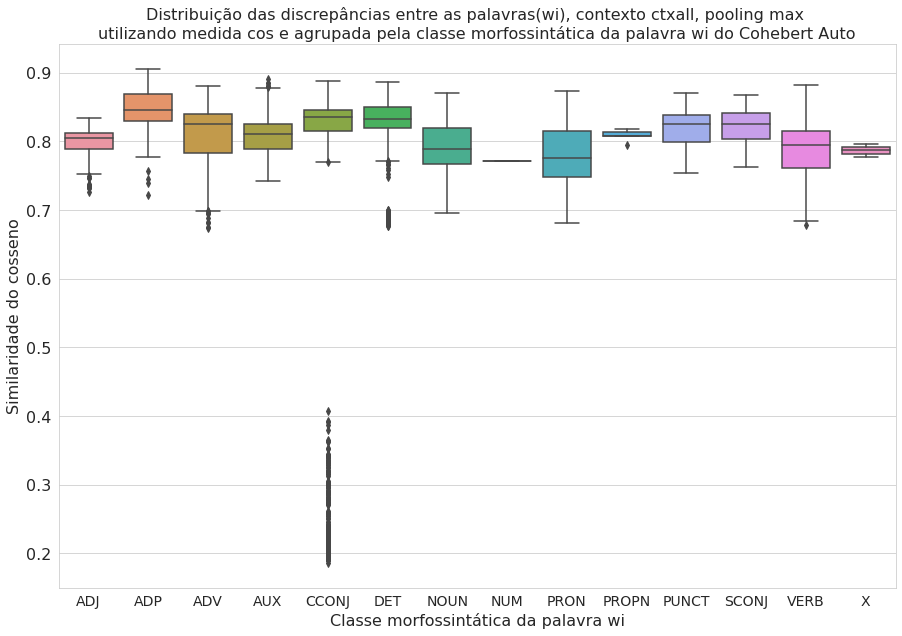

In [94]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [95]:
medida = "euc"

##### MEAN

In [96]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [97]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     96.000000 27.485282 2.905075 22.053478 25.516694 26.965997 28.368477   
ADP   2037.000000 21.458489 1.594642 17.718098 20.263628 21.525742 22.295918   
ADV   1283.000000 21.192423 3.015170 13.972826 20.903238 21.866789 22.762226   
AUX   1046.000000 23.153566 1.601081 18.430243 21.935442 23.026693 24.189886   
CCONJ 1416.000000 23.053714 5.212870 17.972332 20.245697 20.864233 22.080113   
DET   3508.000000 20.941764 1.783883 14.902146 20.042224 21.045527 21.785596   
NOUN  5448.000000 23.565447 4.336821 11.313010 20.999165 23.845531 26.503340   
NUM      1.000000 28.151350      NaN 28.151350 28.151350 28.151350 28.151350   
PRON  2064.000000 24.872171 2.898320 18.631201 22.029632 26.013107 27.131238   
PROPN    5.000000 27.219803 2.000281 24.266651 26.445955 27.449738 28.459929   
PUNCT 2026.000000 22.016181 1.390092 18.498266 20.884523 21.670028 23.201524   
SCONJ  841.000000 22.132475 1.291771 19.517862 20.968630 22.070332 23.172350   
VERB  2144.000000 24.265282 5.486711 10.737125 21.812787 24.924773 27.639659   
X        2.000000 24.204509 0.063967 24.159277 24.181893 24.204509 24.227125   

            max  
pos_i            
ADJ   37.424816  
ADP   36.604649  
ADV   36.365273  
AUX   33.336025  
CCONJ 35.809612  
DET   31.312202  
NOUN  40.800144  
NUM   28.151350  
PRON  37.206238  
PROPN 29.476742  
PUNCT 29.459644  
SCONJ 24.918846  
VERB  42.080738  
X     24.249741

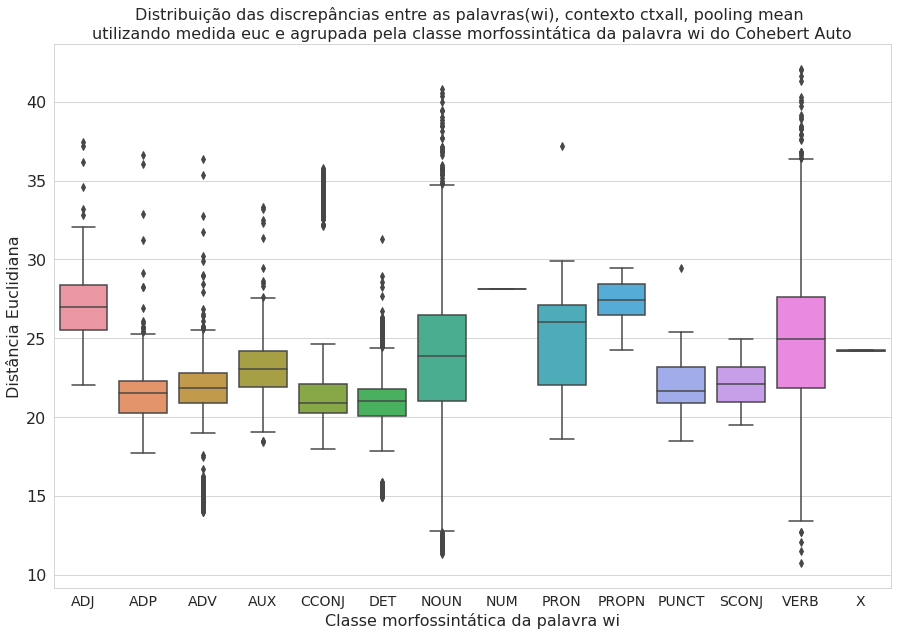

In [98]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [99]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [100]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     96.000000 27.485282 2.905075 22.053478 25.516694 26.965997 28.368477   
ADP   2037.000000 21.458489 1.594642 17.718098 20.263628 21.525742 22.295918   
ADV   1283.000000 23.246495 2.605714 18.968611 21.553910 22.405594 24.138131   
AUX   1046.000000 23.153566 1.601081 18.430243 21.935442 23.026693 24.189886   
CCONJ 1416.000000 23.053714 5.212870 17.972332 20.245697 20.864233 22.080113   
DET   3508.000000 21.392126 2.223750 17.821421 20.159404 21.125880 21.878677   
NOUN  5448.000000 25.415758 2.808544 19.694954 23.509811 25.410685 26.853451   
NUM      1.000000 28.151350      NaN 28.151350 28.151350 28.151350 28.151350   
PRON  2064.000000 24.872171 2.898320 18.631201 22.029632 26.013107 27.131238   
PROPN    5.000000 27.219803 2.000281 24.266651 26.445955 27.449738 28.459929   
PUNCT 2026.000000 22.016181 1.390092 18.498266 20.884523 21.670028 23.201524   
SCONJ  841.000000 22.132475 1.291771 19.517862 20.968630 22.070332 23.172350   
VERB  2144.000000 26.829000 3.284109 18.909819 24.748127 26.557864 28.470075   
X        2.000000 24.204509 0.063967 24.159277 24.181893 24.204509 24.227125   

            max  
pos_i            
ADJ   37.424816  
ADP   36.604649  
ADV   36.365273  
AUX   33.336025  
CCONJ 35.809612  
DET   31.684526  
NOUN  40.800144  
NUM   28.151350  
PRON  37.206238  
PROPN 29.476742  
PUNCT 29.459644  
SCONJ 24.918846  
VERB  42.080738  
X     24.249741

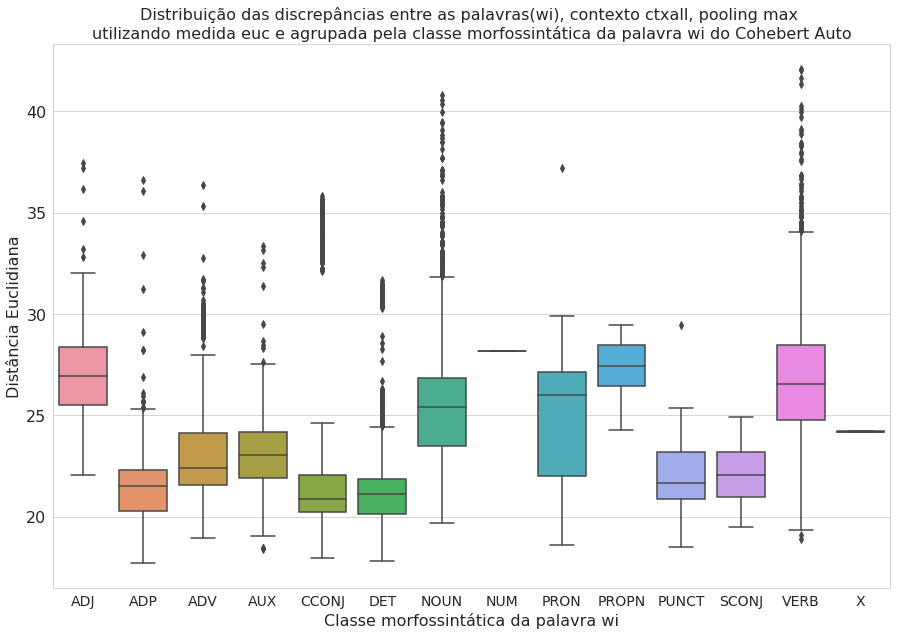

In [101]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [102]:
medida = "man"

##### MEAN

In [103]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [104]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     96.000000 1254.504775 114.922677 1050.937500 1181.029975 1223.890300   
ADP   2037.000000 1051.475546  73.252213  850.644900  995.476560 1056.408900   
ADV   1283.000000 1051.617965 153.130200  677.845500 1035.360450 1092.750500   
AUX   1046.000000 1107.136055  77.060175  873.821840 1042.595725 1098.258950   
CCONJ 1416.000000 1039.646268  53.852047  881.538940 1002.372735 1030.890000   
DET   3508.000000 1029.140798  90.833123  725.245850  987.517400 1035.633950   
NOUN  5448.000000 1099.233711 178.049797  550.818360  991.356525 1124.787700   
NUM      1.000000 1335.901500        NaN 1335.901500 1335.901500 1335.901500   
PRON  2064.000000 1209.803289 149.672843  896.515260 1058.959150 1268.573200   
PROPN    5.000000 1236.049660  86.107126 1110.503500 1202.522000 1249.104200   
PUNCT 2026.000000 1096.181945  67.993590  912.876950 1043.229575 1086.523100   
SCONJ  841.000000 1096.670363  64.744215  976.557900 1038.239900 1100.277500   
VERB  2144.000000 1131.837189 220.670718  523.811160 1043.863800 1167.705850   
X        2.000000 1130.881450  14.707467 1120.481700 1125.681575 1130.881450   

              75%         max  
pos_i                          
ADJ   1287.922975 1622.798000  
ADP   1100.774400 1653.370400  
ADV   1137.528200 1666.877300  
AUX   1167.153525 1530.688200  
CCONJ 1085.284550 1204.895300  
DET   1073.931350 1490.320100  
NOUN  1227.003725 1606.093000  
NUM   1335.901500 1335.901500  
PRON  1327.352000 1647.155800  
PROPN 1277.909900 1340.208700  
PUNCT 1145.679300 1429.763400  
SCONJ 1147.606900 1231.842000  
VERB  1276.831775 1649.376100  
X     1136.081325 1141.281200

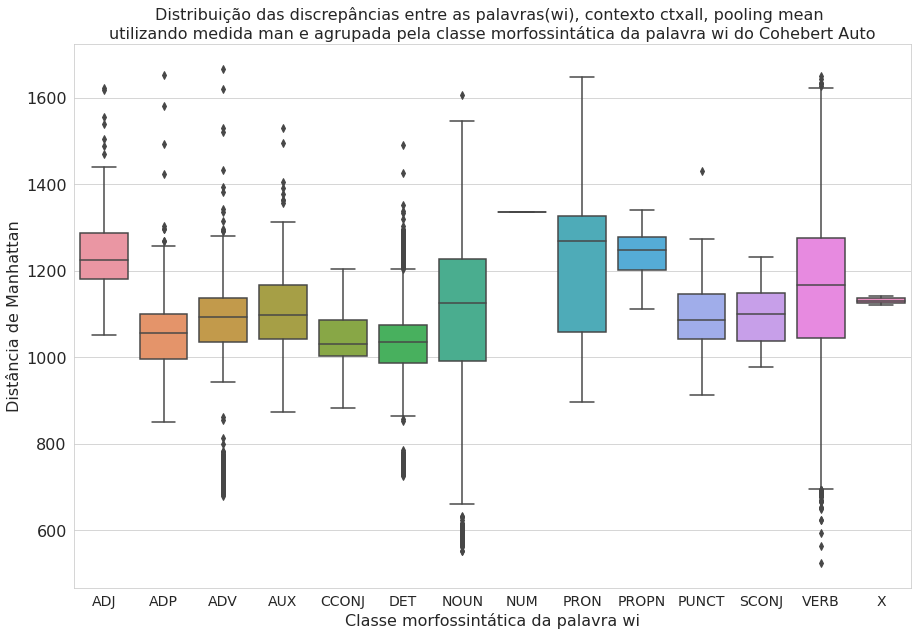

In [105]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [106]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [107]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     96.000000 1254.504775 114.922677 1050.937500 1181.029975 1223.890300   
ADP   2037.000000 1051.475546  73.252213  850.644900  995.476560 1056.408900   
ADV   1283.000000 1160.211961 133.968533  942.990050 1075.526500 1119.393600   
AUX   1046.000000 1107.136055  77.060175  873.821840 1042.595725 1098.258950   
CCONJ 1416.000000 1039.646268  53.852047  881.538940 1002.372735 1030.890000   
DET   3508.000000 1052.205769 115.670814  852.407700  993.118100 1039.188500   
NOUN  5448.000000 1193.125959 120.852788  924.427700 1113.083425 1198.879400   
NUM      1.000000 1335.901500        NaN 1335.901500 1335.901500 1335.901500   
PRON  2064.000000 1209.803289 149.672843  896.515260 1058.959150 1268.573200   
PROPN    5.000000 1236.049660  86.107126 1110.503500 1202.522000 1249.104200   
PUNCT 2026.000000 1096.181945  67.993590  912.876950 1043.229575 1086.523100   
SCONJ  841.000000 1096.670363  64.744215  976.557900 1038.239900 1100.277500   
VERB  2144.000000 1258.529808 129.407555  902.745000 1166.218500 1257.011850   
X        2.000000 1130.881450  14.707467 1120.481700 1125.681575 1130.881450   

              75%         max  
pos_i                          
ADJ   1287.922975 1622.798000  
ADP   1100.774400 1653.370400  
ADV   1187.820850 1666.877300  
AUX   1167.153525 1530.688200  
CCONJ 1085.284550 1204.895300  
DET   1079.222625 1595.537100  
NOUN  1272.415275 1606.093000  
NUM   1335.901500 1335.901500  
PRON  1327.352000 1647.155800  
PROPN 1277.909900 1340.208700  
PUNCT 1145.679300 1429.763400  
SCONJ 1147.606900 1231.842000  
VERB  1350.501675 1649.376100  
X     1136.081325 1141.281200

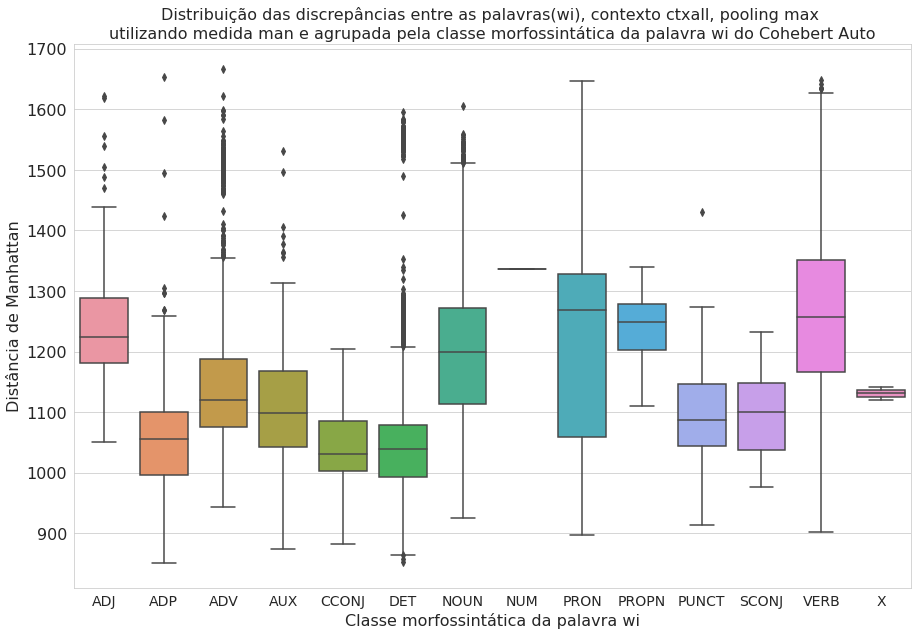

In [108]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras sem as stopwords(ctxclean)

In [109]:
equacao_medida = "ctxclean"

#### COS

In [110]:
medida = "cos"

##### MEAN

In [111]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [112]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     96.000000 0.845103 0.029134 0.737951 0.832617 0.853361 0.863616   
ADP   2037.000000 0.791849 0.027501 0.673809 0.774466 0.790109 0.814518   
ADV   1283.000000 0.760557 0.053103 0.673134 0.727841 0.745113 0.763931   
AUX   1046.000000 0.695574 0.038473 0.621822 0.669267 0.684200 0.710072   
CCONJ 1416.000000 0.653810 0.209339 0.148969 0.712366 0.736546 0.757899   
DET   3508.000000 0.769463 0.035375 0.660221 0.744656 0.765995 0.795839   
NOUN  5448.000000 0.855697 0.022280 0.769810 0.840642 0.856172 0.873547   
NUM      1.000000 0.825649      NaN 0.825649 0.825649 0.825649 0.825649   
PRON  2064.000000 0.681338 0.097105 0.503541 0.592932 0.684181 0.711940   
PROPN    5.000000 0.865215 0.012939 0.847146 0.859028 0.864836 0.876683   
PUNCT 2026.000000 0.801128 0.025366 0.738972 0.785455 0.800840 0.816349   
SCONJ  841.000000 0.759213 0.020247 0.693065 0.745848 0.759251 0.775067   
VERB  2144.000000 0.849353 0.032713 0.673699 0.830713 0.856636 0.873610   
X        2.000000 0.840443 0.012064 0.831913 0.836178 0.840443 0.844709   

           max  
pos_i           
ADJ   0.898566  
ADP   0.854975  
ADV   0.897194  
AUX   0.880854  
CCONJ 0.831267  
DET   0.870179  
NOUN  0.910874  
NUM   0.825649  
PRON  0.903345  
PROPN 0.878379  
PUNCT 0.877499  
SCONJ 0.805645  
VERB  0.920360  
X     0.848974

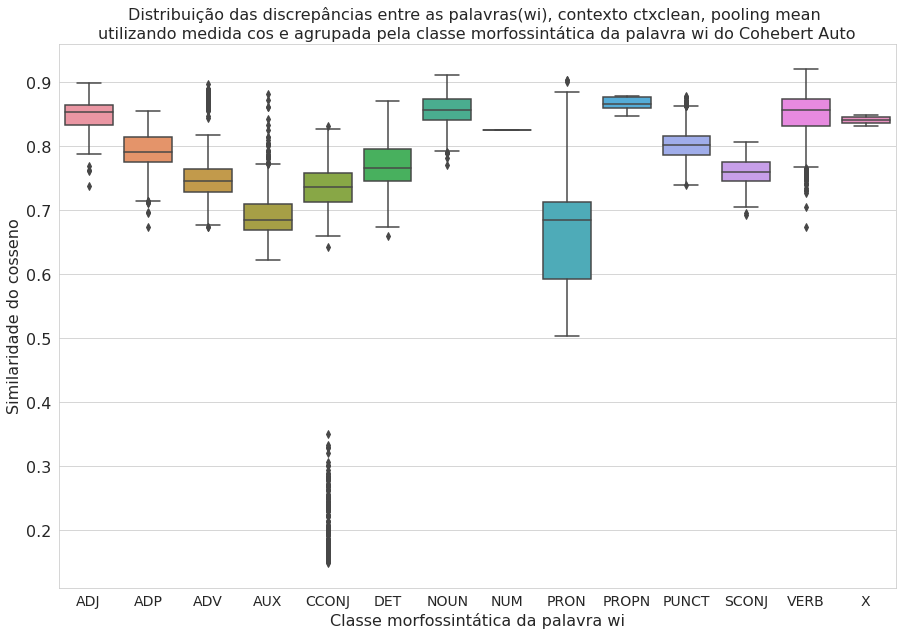

In [113]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [114]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [115]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     96.000000 0.845103 0.029134 0.737951 0.832617 0.853361 0.863616   
ADP   2037.000000 0.791849 0.027501 0.673809 0.774466 0.790109 0.814518   
ADV   1283.000000 0.734045 0.024544 0.651253 0.718935 0.736086 0.751446   
AUX   1046.000000 0.695574 0.038473 0.621822 0.669267 0.684200 0.710072   
CCONJ 1416.000000 0.653810 0.209339 0.148969 0.712366 0.736546 0.757899   
DET   3508.000000 0.763725 0.038512 0.632715 0.741862 0.763218 0.792941   
NOUN  5448.000000 0.832185 0.048695 0.664724 0.805217 0.848196 0.867397   
NUM      1.000000 0.825649      NaN 0.825649 0.825649 0.825649 0.825649   
PRON  2064.000000 0.681338 0.097105 0.503541 0.592932 0.684181 0.711940   
PROPN    5.000000 0.865215 0.012939 0.847146 0.859028 0.864836 0.876683   
PUNCT 2026.000000 0.801128 0.025366 0.738972 0.785455 0.800840 0.816349   
SCONJ  841.000000 0.759213 0.020247 0.693065 0.745848 0.759251 0.775067   
VERB  2144.000000 0.817206 0.069347 0.635793 0.764745 0.846542 0.869603   
X        2.000000 0.840443 0.012064 0.831913 0.836178 0.840443 0.844709   

           max  
pos_i           
ADJ   0.898566  
ADP   0.854975  
ADV   0.817890  
AUX   0.880854  
CCONJ 0.831267  
DET   0.864677  
NOUN  0.909093  
NUM   0.825649  
PRON  0.903345  
PROPN 0.878379  
PUNCT 0.877499  
SCONJ 0.805645  
VERB  0.912413  
X     0.848974

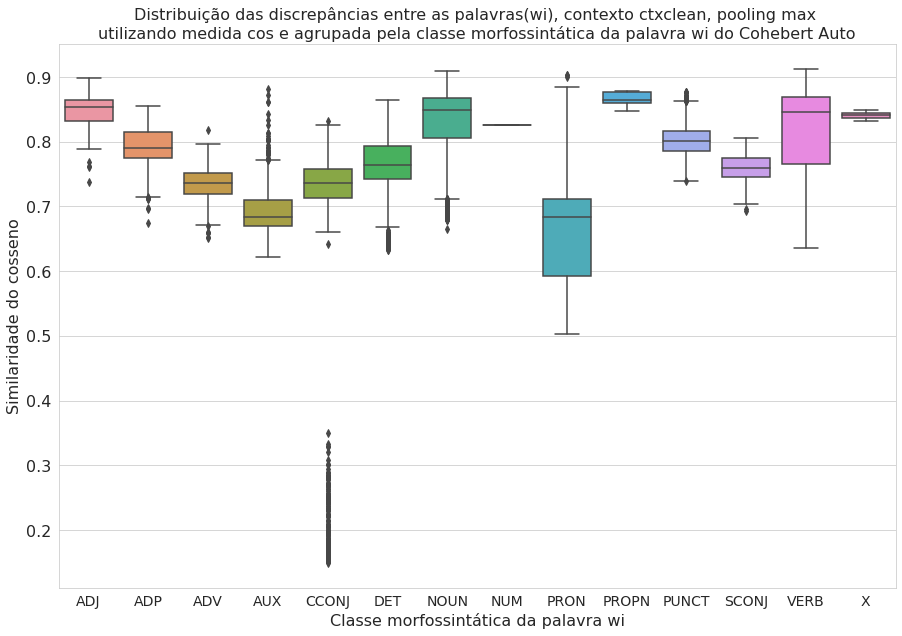

In [116]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [117]:
medida = "euc"

##### MEAN

In [118]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [119]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     96.000000 24.486440 2.826243 18.766317 22.821854 23.979373 26.052419   
ADP   2037.000000 24.797217 1.601559 21.396029 23.551958 24.764286 25.796598   
ADV   1283.000000 25.574907 3.730397 15.306025 25.333739 26.758457 27.871384   
AUX   1046.000000 29.109913 2.114805 19.966869 28.428555 29.708022 30.509206   
CCONJ 1416.000000 27.892050 4.542845 22.148685 25.229853 26.367446 27.815998   
DET   3508.000000 24.848457 2.043357 17.315102 23.626669 24.812147 26.017975   
NOUN  5448.000000 21.272765 2.235410 15.049208 19.830615 21.061183 22.580863   
NUM      1.000000 25.182383      NaN 25.182383 25.182383 25.182383 25.182383   
PRON  2064.000000 29.735921 4.607785 20.188398 27.626921 29.160762 34.125539   
PROPN    5.000000 23.399521 1.242617 21.397427 23.369516 23.448622 24.075943   
PUNCT 2026.000000 23.204334 1.471443 18.104719 22.350061 23.307462 24.142035   
SCONJ  841.000000 25.696124 1.218515 23.008318 24.747255 25.657888 26.473997   
VERB  2144.000000 22.526125 3.495565 13.852946 20.187375 22.187858 24.312386   
X        2.000000 21.200868 0.135055 21.105370 21.153119 21.200868 21.248617   

            max  
pos_i            
ADJ   32.914833  
ADP   38.462208  
ADV   33.998493  
AUX   35.003155  
CCONJ 40.750187  
DET   33.357311  
NOUN  36.571972  
NUM   25.182383  
PRON  39.601845  
PROPN 24.706099  
PUNCT 26.666542  
SCONJ 29.539457  
VERB  38.754295  
X     21.296366

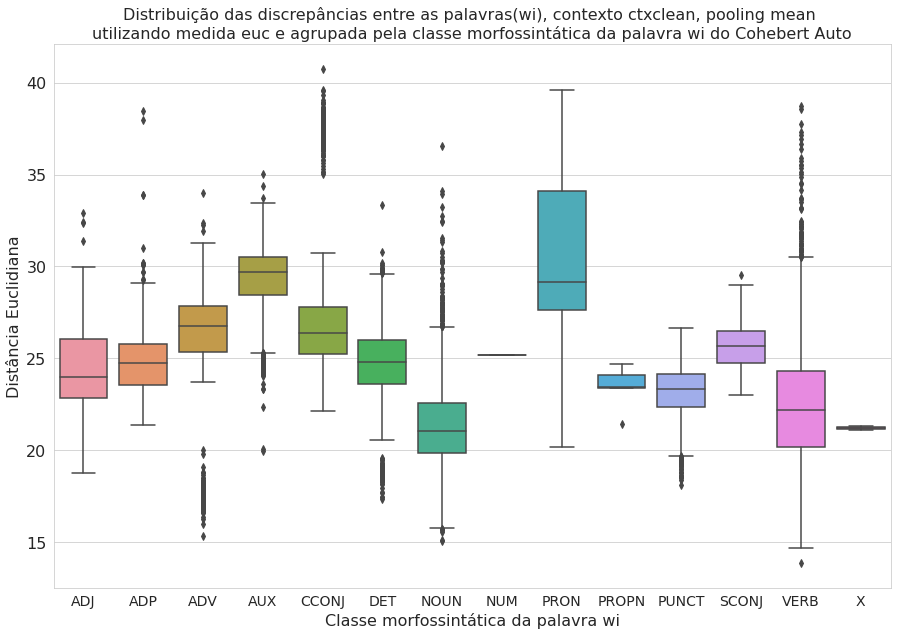

In [120]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [121]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [122]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     96.000000 24.486440 2.826243 18.766317 22.821854 23.979373 26.052419   
ADP   2037.000000 24.797217 1.601559 21.396029 23.551958 24.764286 25.796598   
ADV   1283.000000 27.527144 1.717234 23.706490 26.292593 27.466269 28.513700   
AUX   1046.000000 29.109913 2.114805 19.966869 28.428555 29.708022 30.509206   
CCONJ 1416.000000 27.892050 4.542845 22.148685 25.229853 26.367446 27.815998   
DET   3508.000000 25.257115 2.203220 20.575109 23.765305 24.969700 26.222650   
NOUN  5448.000000 23.030113 2.817696 16.700401 20.904384 22.604998 25.018266   
NUM      1.000000 25.182383      NaN 25.182383 25.182383 25.182383 25.182383   
PRON  2064.000000 29.735921 4.607785 20.188398 27.626921 29.160762 34.125539   
PROPN    5.000000 23.399521 1.242617 21.397427 23.369516 23.448622 24.075943   
PUNCT 2026.000000 23.204334 1.471443 18.104719 22.350061 23.307462 24.142035   
SCONJ  841.000000 25.696124 1.218515 23.008318 24.747255 25.657888 26.473997   
VERB  2144.000000 24.858775 3.906917 16.645185 21.665194 24.226096 27.472869   
X        2.000000 21.200868 0.135055 21.105370 21.153119 21.200868 21.248617   

            max  
pos_i            
ADJ   32.914833  
ADP   38.462208  
ADV   33.998493  
AUX   35.003155  
CCONJ 40.750187  
DET   33.671074  
NOUN  36.571972  
NUM   25.182383  
PRON  39.601845  
PROPN 24.706099  
PUNCT 26.666542  
SCONJ 29.539457  
VERB  38.754295  
X     21.296366

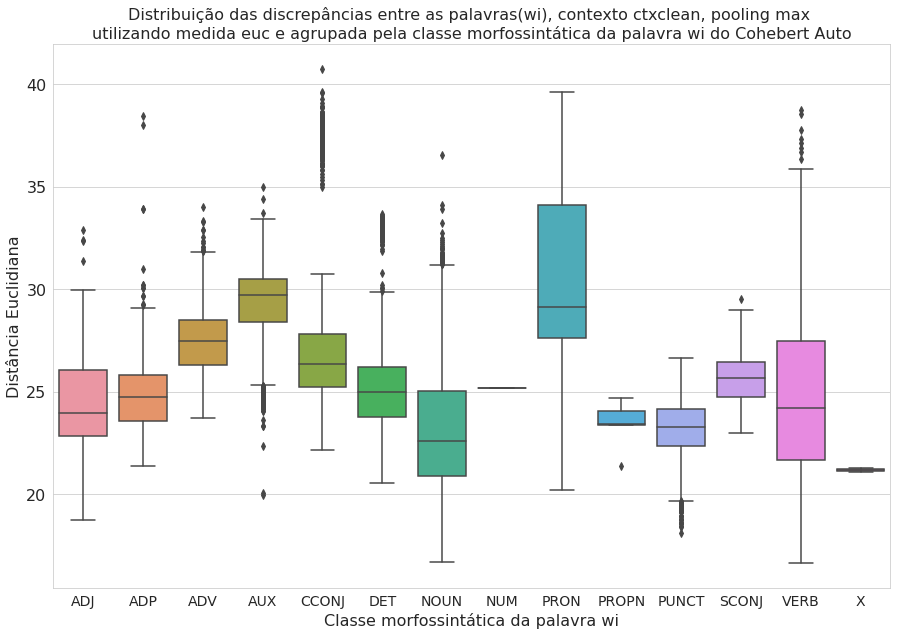

In [123]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [124]:
medida = "man"

##### MEAN

In [125]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [126]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     96.000000 1122.148548 122.737246  899.035500 1034.858725 1086.693850   
ADP   2037.000000 1207.784456  73.767962 1031.877900 1151.854100 1210.037600   
ADV   1283.000000 1248.497748 189.891699  730.089500 1233.708150 1312.765900   
AUX   1046.000000 1357.465607  89.716305  970.065000 1330.270750 1381.495600   
CCONJ 1416.000000 1236.311906  63.897826 1093.007600 1178.321500 1239.865250   
DET   3508.000000 1193.234179  88.771110  818.028700 1148.469075 1188.177800   
NOUN  5448.000000 1001.547106  93.305269  738.976900  934.978178  993.900520   
NUM      1.000000 1195.082900        NaN 1195.082900 1195.082900 1195.082900   
PRON  2064.000000 1411.776729 204.660345 1002.923770 1305.533525 1367.024700   
PROPN    5.000000 1075.077932  56.910208  980.767760 1075.080300 1085.519700   
PUNCT 2026.000000 1130.010520  71.420220  889.183500 1088.589700 1143.015750   
SCONJ  841.000000 1246.576764  56.805795 1128.567400 1199.617900 1245.717900   
VERB  2144.000000 1063.668614 145.843331  672.883540  962.018405 1056.647200   
X        2.000000  983.075675   9.365028  976.453600  979.764638  983.075675   

              75%         max  
pos_i                          
ADJ   1171.541300 1459.199200  
ADP   1252.811000 1774.981800  
ADV   1367.540300 1626.698500  
AUX   1414.660075 1626.771900  
CCONJ 1283.710750 1432.524500  
DET   1241.280700 1621.886600  
NOUN  1070.345025 1448.290200  
NUM   1195.082900 1195.082900  
PRON  1622.286450 1759.430700  
PROPN 1102.264900 1131.757000  
PUNCT 1181.438200 1292.393100  
SCONJ 1284.013700 1456.367700  
VERB  1154.902675 1631.399000  
X      986.386713  989.697750

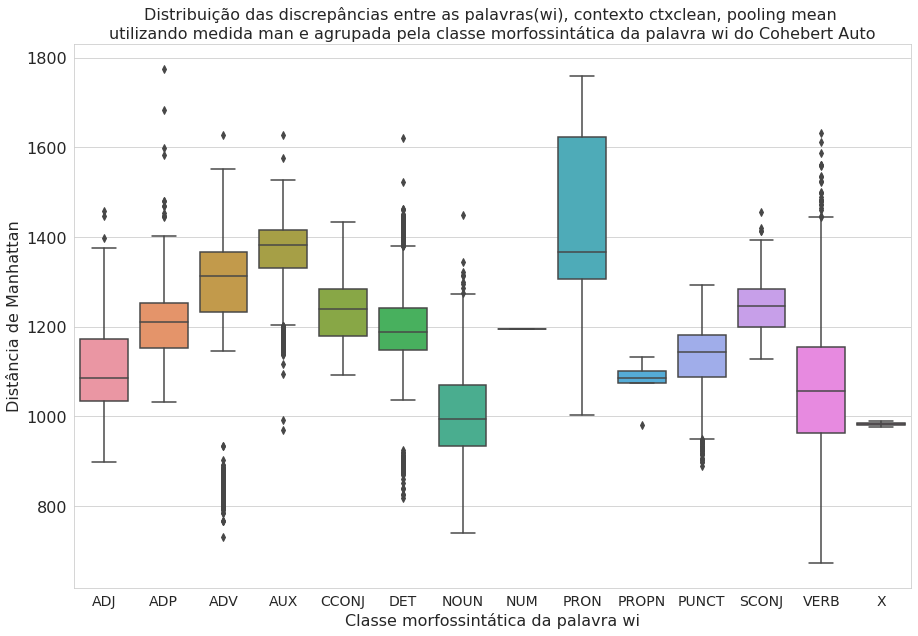

In [127]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [128]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [129]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     96.000000 1122.148548 122.737246  899.035500 1034.858725 1086.693850   
ADP   2037.000000 1207.784456  73.767962 1031.877900 1151.854100 1210.037600   
ADV   1283.000000 1350.792237  91.862848 1145.123900 1284.565000 1348.554300   
AUX   1046.000000 1357.465607  89.716305  970.065000 1330.270750 1381.495600   
CCONJ 1416.000000 1236.311906  63.897826 1093.007600 1178.321500 1239.865250   
DET   3508.000000 1214.142503  99.504458 1036.498200 1152.991125 1194.449900   
NOUN  5448.000000 1090.843042 144.596910  810.405400  982.461913 1072.411800   
NUM      1.000000 1195.082900        NaN 1195.082900 1195.082900 1195.082900   
PRON  2064.000000 1411.776729 204.660345 1002.923770 1305.533525 1367.024700   
PROPN    5.000000 1075.077932  56.910208  980.767760 1075.080300 1085.519700   
PUNCT 2026.000000 1130.010520  71.420220  889.183500 1088.589700 1143.015750   
SCONJ  841.000000 1246.576764  56.805795 1128.567400 1199.617900 1245.717900   
VERB  2144.000000 1178.329098 178.335752  803.258200 1036.173800 1149.046850   
X        2.000000  983.075675   9.365028  976.453600  979.764638  983.075675   

              75%         max  
pos_i                          
ADJ   1171.541300 1459.199200  
ADP   1252.811000 1774.981800  
ADV   1400.078400 1636.887300  
AUX   1414.660075 1626.771900  
CCONJ 1283.710750 1432.524500  
DET   1247.113375 1646.763700  
NOUN  1174.898600 1619.117900  
NUM   1195.082900 1195.082900  
PRON  1622.286450 1759.430700  
PROPN 1102.264900 1131.757000  
PUNCT 1181.438200 1292.393100  
SCONJ 1284.013700 1456.367700  
VERB  1301.393750 1631.399000  
X      986.386713  989.697750

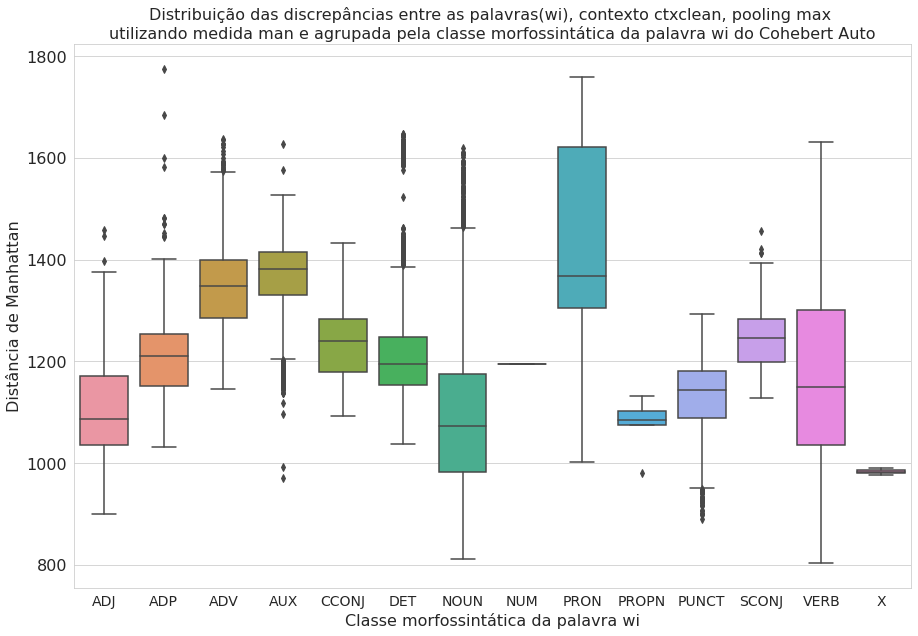

In [130]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

In [131]:
equacao_medida = "ctxverb"

#### COS

In [132]:
medida = "cos"

##### MEAN

In [133]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [134]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     22.000000 0.673671 0.048094 0.570493 0.651516 0.681828 0.707857   
ADP   1553.000000 0.675246 0.062545 0.481830 0.631523 0.673715 0.721178   
ADV   1279.000000 0.715366 0.055042 0.524372 0.670902 0.736185 0.757345   
AUX   1046.000000 0.889685 0.045471 0.805932 0.862013 0.879603 0.901444   
CCONJ 1416.000000 0.615231 0.207565 0.111985 0.661552 0.703826 0.726967   
DET   3303.000000 0.691513 0.071265 0.438784 0.640966 0.709570 0.738465   
NOUN  4767.000000 0.677232 0.055722 0.477852 0.647480 0.681817 0.719156   
NUM      0.000000      NaN      NaN      NaN      NaN      NaN      NaN   
PRON  2064.000000 0.694687 0.040542 0.519710 0.679275 0.699394 0.720460   
PROPN    0.000000      NaN      NaN      NaN      NaN      NaN      NaN   
PUNCT 1827.000000 0.669543 0.050909 0.513351 0.632952 0.678747 0.711090   
SCONJ  839.000000 0.696032 0.049499 0.555068 0.659596 0.690451 0.739029   
VERB  2144.000000 0.922090 0.057597 0.769599 0.886702 0.910614 1.000000   
X        0.000000      NaN      NaN      NaN      NaN      NaN      NaN   

           max  
pos_i           
ADJ   0.746225  
ADP   0.835404  
ADV   0.816233  
AUX   1.000000  
CCONJ 0.796351  
DET   0.857930  
NOUN  0.811667  
NUM        NaN  
PRON  0.777243  
PROPN      NaN  
PUNCT 0.795374  
SCONJ 0.806877  
VERB  1.000000  
X          NaN

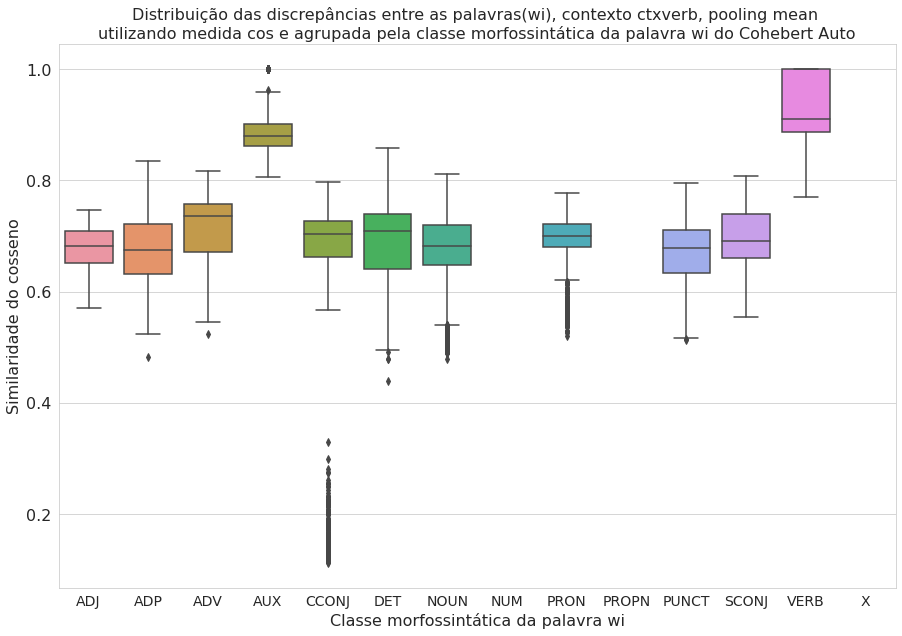

In [135]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [136]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [137]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     22.000000 0.673671 0.048094 0.570493 0.651516 0.681828 0.707857   
ADP   1553.000000 0.675246 0.062545 0.481830 0.631523 0.673715 0.721178   
ADV   1279.000000 0.696285 0.075051 0.498306 0.639591 0.729691 0.753087   
AUX   1046.000000 0.889685 0.045471 0.805932 0.862013 0.879603 0.901444   
CCONJ 1416.000000 0.615231 0.207565 0.111985 0.661552 0.703826 0.726967   
DET   3303.000000 0.685910 0.070004 0.438784 0.632797 0.705709 0.734223   
NOUN  4767.000000 0.659414 0.059871 0.477852 0.623129 0.663619 0.702420   
NUM      0.000000      NaN      NaN      NaN      NaN      NaN      NaN   
PRON  2064.000000 0.694687 0.040542 0.519710 0.679275 0.699394 0.720460   
PROPN    0.000000      NaN      NaN      NaN      NaN      NaN      NaN   
PUNCT 1827.000000 0.669543 0.050909 0.513351 0.632952 0.678747 0.711090   
SCONJ  839.000000 0.696032 0.049499 0.555068 0.659596 0.690451 0.739029   
VERB  2144.000000 0.889953 0.098299 0.616185 0.820024 0.906095 1.000000   
X        0.000000      NaN      NaN      NaN      NaN      NaN      NaN   

           max  
pos_i           
ADJ   0.746225  
ADP   0.835404  
ADV   0.803689  
AUX   1.000000  
CCONJ 0.796351  
DET   0.857930  
NOUN  0.811667  
NUM        NaN  
PRON  0.777243  
PROPN      NaN  
PUNCT 0.795374  
SCONJ 0.806877  
VERB  1.000000  
X          NaN

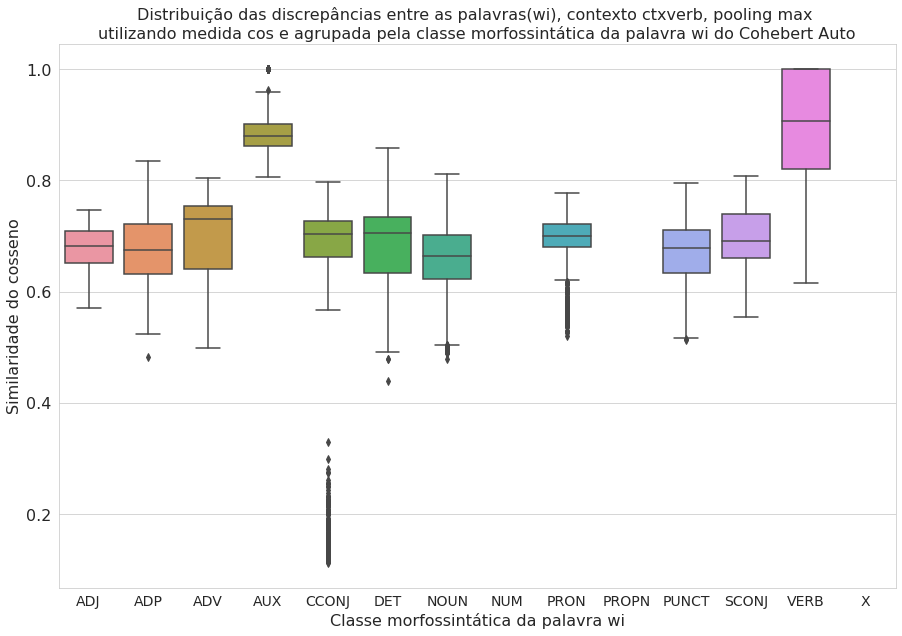

In [138]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [139]:
medida = "euc"

##### MEAN

In [140]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [141]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     22.000000 34.966646 4.797226 28.269611 31.337999 34.077587 38.897937   
ADP   1553.000000 32.919197 3.903581 22.782196 29.349216 33.323402 35.964581   
ADV   1279.000000 28.975935 3.478289 20.747015 26.375706 28.123331 31.902597   
AUX   1046.000000 16.976020 6.247314  0.000000 17.241476 18.891722 20.169112   
CCONJ 1416.000000 30.803470 4.524970 24.326063 27.732612 29.000285 32.007321   
DET   3303.000000 30.150235 4.656641 19.502630 27.262641 28.801394 33.337116   
NOUN  4767.000000 32.559816 3.703687 22.345469 30.169966 32.274189 34.690399   
NUM      0.000000       NaN      NaN       NaN       NaN       NaN       NaN   
PRON  2064.000000 30.355021 2.685724 25.009298 28.560758 29.955029 31.497886   
PROPN    0.000000       NaN      NaN       NaN       NaN       NaN       NaN   
PUNCT 1827.000000 31.522253 3.640374 23.393629 28.719727 30.747259 34.186386   
SCONJ  839.000000 30.441829 3.682725 22.443602 27.370835 30.459717 33.142138   
VERB  2144.000000 13.821816 9.047782  0.000000  0.000000 17.892559 20.159017   
X        0.000000       NaN      NaN       NaN       NaN       NaN       NaN   

            max  
pos_i            
ADJ   46.153847  
ADP   46.341908  
ADV   44.095184  
AUX   25.404711  
CCONJ 43.874687  
DET   47.702663  
NOUN  52.019901  
NUM         NaN  
PRON  41.738556  
PROPN       NaN  
PUNCT 44.999214  
SCONJ 41.199566  
VERB  30.264620  
X           NaN

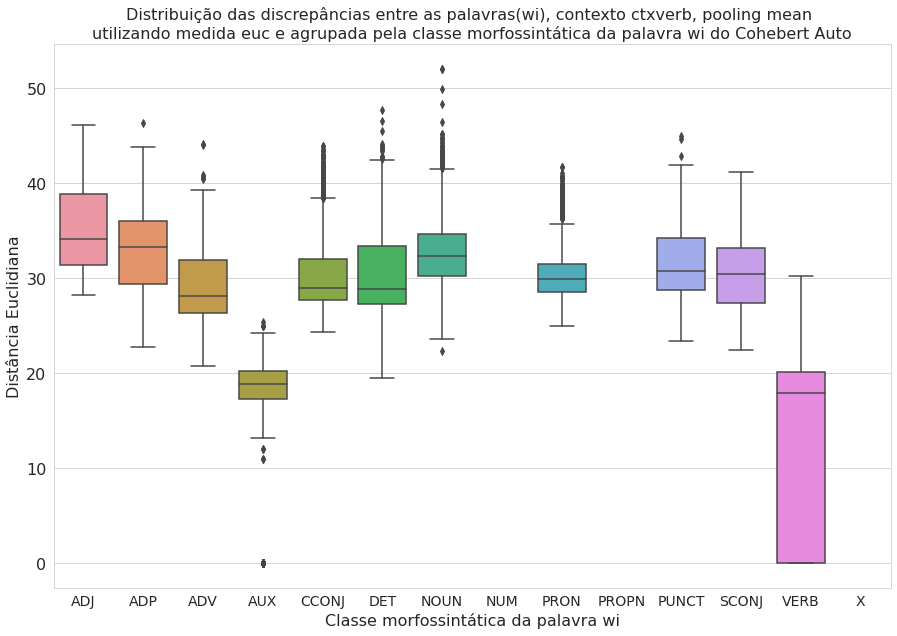

In [142]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [143]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [144]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg       std       min       25%       50%       75%  \
pos_i                                                                           
ADJ     22.000000 34.966646  4.797226 28.269611 31.337999 34.077587 38.897937   
ADP   1553.000000 32.919197  3.903581 22.782196 29.349216 33.323402 35.964581   
ADV   1279.000000 30.264153  4.495024 23.285460 27.121545 28.595079 33.956570   
AUX   1046.000000 16.976020  6.247314  0.000000 17.241476 18.891722 20.169112   
CCONJ 1416.000000 30.803470  4.524970 24.326063 27.732612 29.000285 32.007321   
DET   3303.000000 30.539003  4.485396 20.682617 27.443030 29.137787 33.854351   
NOUN  4767.000000 33.717717  3.470313 25.471758 31.477604 33.121807 35.755278   
NUM      0.000000       NaN       NaN       NaN       NaN       NaN       NaN   
PRON  2064.000000 30.355021  2.685724 25.009298 28.560758 29.955029 31.497886   
PROPN    0.000000       NaN       NaN       NaN       NaN       NaN       NaN   
PUNCT 1827.000000 31.522253  3.640374 23.393629 28.719727 30.747259 34.186386   
SCONJ  839.000000 30.441829  3.682725 22.443602 27.370835 30.459717 33.142138   
VERB  2144.000000 16.357635 10.845653  0.000000  0.000000 19.186313 24.942219   
X        0.000000       NaN       NaN       NaN       NaN       NaN       NaN   

            max  
pos_i            
ADJ   46.153847  
ADP   46.341908  
ADV   44.095184  
AUX   25.404711  
CCONJ 43.874687  
DET   47.702663  
NOUN  52.019901  
NUM         NaN  
PRON  41.738556  
PROPN       NaN  
PUNCT 44.999214  
SCONJ 41.199566  
VERB  35.630196  
X           NaN

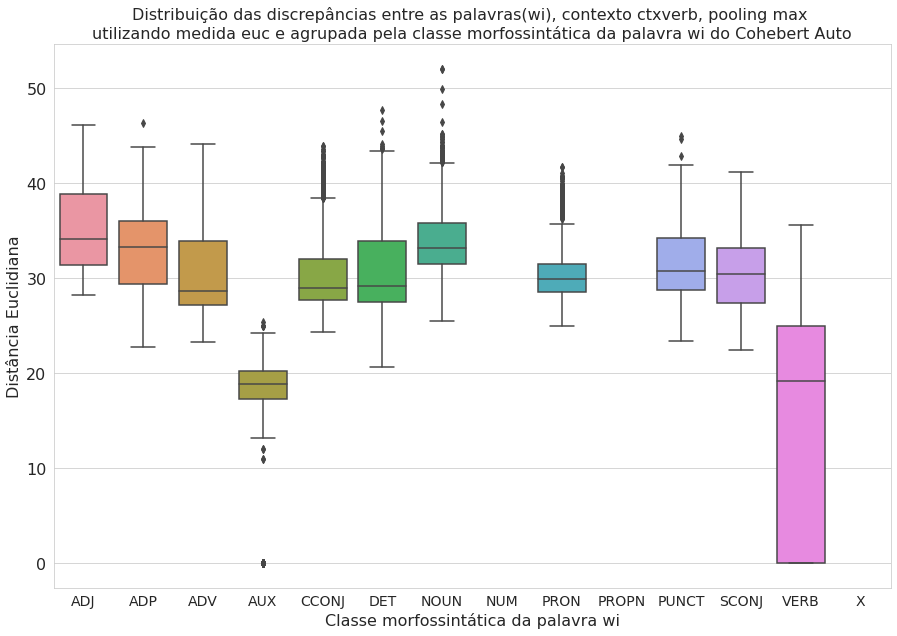

In [145]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [146]:
medida = "man"

##### MEAN

In [147]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [148]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     22.000000 1581.262928 150.406994 1337.208008 1475.448730 1569.770508   
ADP   1553.000000 1595.602423 176.780570 1124.919434 1444.151733 1612.495605   
ADV   1279.000000 1420.812971 158.459773  994.032898 1302.884033 1392.847412   
AUX   1046.000000  784.937137 286.550947    0.000000  807.301392  871.090454   
CCONJ 1416.000000 1413.129889 106.549024 1202.311401 1344.663208 1389.853394   
DET   3303.000000 1455.608112 207.604579  942.367859 1332.256104 1402.931641   
NOUN  4767.000000 1538.433868 160.580224 1084.597900 1434.045715 1527.980103   
NUM      0.000000         NaN        NaN         NaN         NaN         NaN   
PRON  2064.000000 1462.030135 123.445736 1217.188232 1384.761322 1442.801575   
PROPN    0.000000         NaN        NaN         NaN         NaN         NaN   
PUNCT 1827.000000 1538.215220 154.251502 1140.653198 1423.322205 1501.410522   
SCONJ  839.000000 1473.712403 154.492944 1122.051392 1354.654053 1477.861328   
VERB  2144.000000  638.263957 414.613239    0.000000    0.000000  837.096191   
X        0.000000         NaN        NaN         NaN         NaN         NaN   

              75%         max  
pos_i                          
ADJ   1700.631958 1869.155518  
ADP   1736.062988 2211.243652  
ADV   1547.042236 2086.806641  
AUX    934.491791 1103.889893  
CCONJ 1475.190277 1926.605957  
DET   1594.109436 2212.333984  
NOUN  1635.203857 2125.240234  
NUM           NaN         NaN  
PRON  1516.369720 1949.277832  
PROPN         NaN         NaN  
PUNCT 1647.336670 2127.001221  
SCONJ 1586.199219 1917.301025  
VERB   919.855011 1350.928711  
X             NaN         NaN

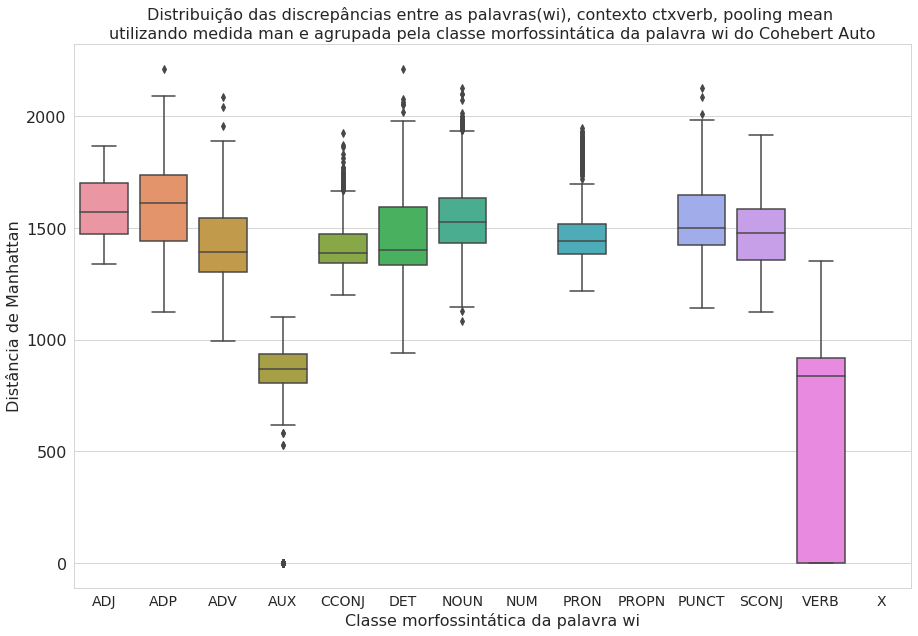

In [149]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [150]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [151]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     22.000000 1581.262928 150.406994 1337.208008 1475.448730 1569.770508   
ADP   1553.000000 1595.602423 176.780570 1124.919434 1444.151733 1612.495605   
ADV   1279.000000 1488.396796 208.687524 1157.545898 1344.725098 1414.857178   
AUX   1046.000000  784.937137 286.550947    0.000000  807.301392  871.090454   
CCONJ 1416.000000 1413.129889 106.549024 1202.311401 1344.663208 1389.853394   
DET   3303.000000 1475.331223 199.504221 1022.276855 1342.738708 1414.235352   
NOUN  4767.000000 1595.195052 158.297737 1190.834961 1484.276001 1573.610596   
NUM      0.000000         NaN        NaN         NaN         NaN         NaN   
PRON  2064.000000 1462.030135 123.445736 1217.188232 1384.761322 1442.801575   
PROPN    0.000000         NaN        NaN         NaN         NaN         NaN   
PUNCT 1827.000000 1538.215220 154.251502 1140.653198 1423.322205 1501.410522   
SCONJ  839.000000 1473.712403 154.492944 1122.051392 1354.654053 1477.861328   
VERB  2144.000000  767.257342 514.728254    0.000000    0.000000  877.542206   
X        0.000000         NaN        NaN         NaN         NaN         NaN   

              75%         max  
pos_i                          
ADJ   1700.631958 1869.155518  
ADP   1736.062988 2211.243652  
ADV   1660.469666 2086.806641  
AUX    934.491791 1103.889893  
CCONJ 1475.190277 1926.605957  
DET   1628.190735 2212.333984  
NOUN  1695.030212 2139.425293  
NUM           NaN         NaN  
PRON  1516.369720 1949.277832  
PROPN         NaN         NaN  
PUNCT 1647.336670 2127.001221  
SCONJ 1586.199219 1917.301025  
VERB  1180.061279 1652.410522  
X             NaN         NaN

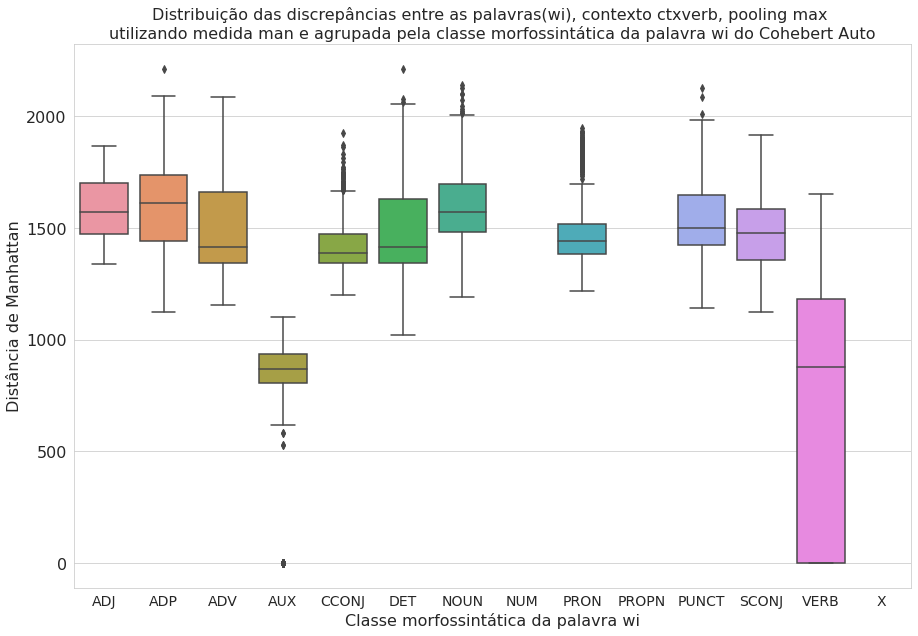

In [152]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

In [153]:
equacao_medida = "ctxnoun"

#### COS

In [154]:
medida = "cos"

##### MEAN

In [155]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [156]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     96.000000 0.753836 0.029099 0.664650 0.736108 0.758834 0.772558   
ADP   2037.000000 0.764113 0.040759 0.627636 0.734567 0.767811 0.796092   
ADV   1283.000000 0.651645 0.050754 0.515823 0.612726 0.645998 0.679864   
AUX   1046.000000 0.605795 0.046619 0.503142 0.573254 0.593266 0.629016   
CCONJ 1416.000000 0.567412 0.178435 0.133210 0.577636 0.617402 0.672228   
DET   3508.000000 0.729741 0.041817 0.612689 0.701230 0.728482 0.760571   
NOUN  5448.000000 0.892781 0.027131 0.775607 0.872986 0.891997 0.914176   
NUM      1.000000 0.711114      NaN 0.711114 0.711114 0.711114 0.711114   
PRON  2064.000000 0.576517 0.082667 0.428298 0.512272 0.557156 0.615095   
PROPN    5.000000 0.762505 0.012520 0.753359 0.755303 0.758028 0.761635   
PUNCT 2026.000000 0.664850 0.031782 0.592774 0.639389 0.661337 0.688228   
SCONJ  841.000000 0.676275 0.033533 0.556186 0.656792 0.673122 0.689513   
VERB  2144.000000 0.739556 0.035111 0.613015 0.715172 0.738865 0.763492   
X        2.000000 0.752081 0.016992 0.740066 0.746074 0.752081 0.758089   

           max  
pos_i           
ADJ   0.820402  
ADP   0.849963  
ADV   0.774252  
AUX   0.808654  
CCONJ 0.784333  
DET   0.853191  
NOUN  0.954686  
NUM   0.711114  
PRON  0.817884  
PROPN 0.784200  
PUNCT 0.776598  
SCONJ 0.783406  
VERB  0.845182  
X     0.764096

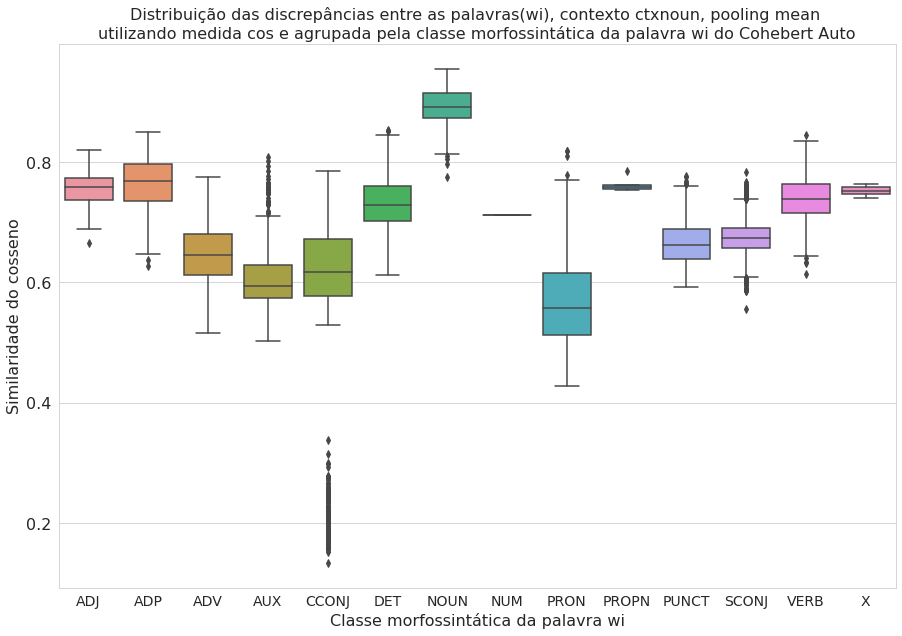

In [157]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [158]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [159]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     96.000000 0.753836 0.029099 0.664650 0.736108 0.758834 0.772558   
ADP   2037.000000 0.764113 0.040759 0.627636 0.734567 0.767811 0.796092   
ADV   1283.000000 0.629422 0.036673 0.515823 0.600674 0.629581 0.657812   
AUX   1046.000000 0.605795 0.046619 0.503142 0.573254 0.593266 0.629016   
CCONJ 1416.000000 0.567412 0.178435 0.133210 0.577636 0.617402 0.672228   
DET   3508.000000 0.724721 0.052171 0.526953 0.697626 0.728385 0.760571   
NOUN  5448.000000 0.869404 0.059707 0.646790 0.831491 0.888337 0.914166   
NUM      1.000000 0.711114      NaN 0.711114 0.711114 0.711114 0.711114   
PRON  2064.000000 0.576517 0.082667 0.428298 0.512272 0.557156 0.615095   
PROPN    5.000000 0.762505 0.012520 0.753359 0.755303 0.758028 0.761635   
PUNCT 2026.000000 0.664850 0.031782 0.592774 0.639389 0.661337 0.688228   
SCONJ  841.000000 0.676275 0.033533 0.556186 0.656792 0.673122 0.689513   
VERB  2144.000000 0.710408 0.062677 0.529881 0.687947 0.727708 0.754555   
X        2.000000 0.752081 0.016992 0.740066 0.746074 0.752081 0.758089   

           max  
pos_i           
ADJ   0.820402  
ADP   0.849963  
ADV   0.752021  
AUX   0.808654  
CCONJ 0.784333  
DET   0.853191  
NOUN  0.954686  
NUM   0.711114  
PRON  0.817884  
PROPN 0.784200  
PUNCT 0.776598  
SCONJ 0.783406  
VERB  0.834443  
X     0.764096

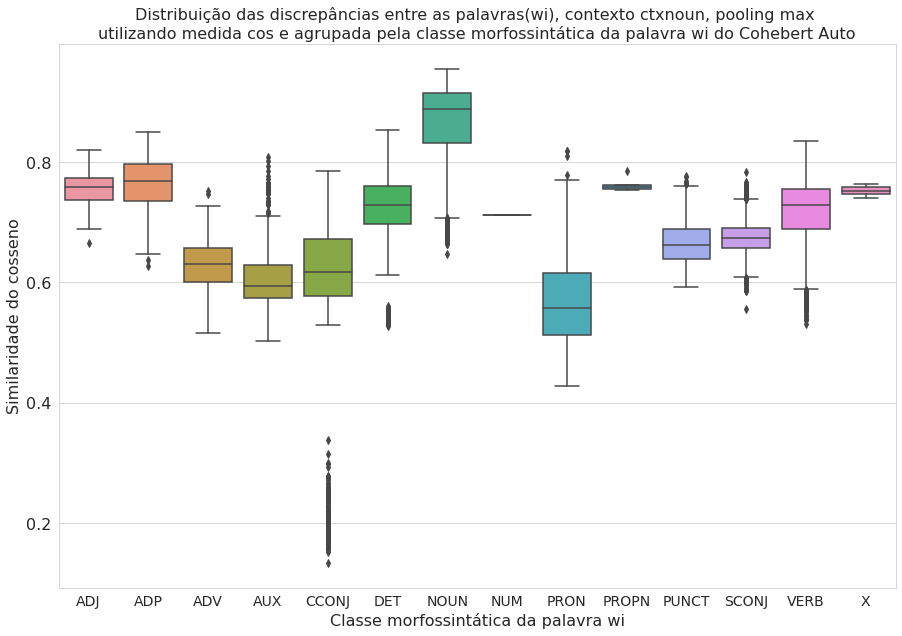

In [160]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [161]:
medida = "euc"

##### MEAN

In [162]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [163]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     96.000000 29.602226 2.802358 22.792593 27.779145 29.291552 31.020362   
ADP   2037.000000 26.592693 2.473065 21.896643 24.631161 26.419027 28.038349   
ADV   1283.000000 31.875679 3.011324 24.797171 29.915546 32.372231 34.310036   
AUX   1046.000000 34.064258 2.556271 25.340181 32.234055 34.667149 35.922763   
CCONJ 1416.000000 33.042978 4.212497 24.671202 29.588723 33.157539 35.108110   
DET   3508.000000 27.644732 2.376384 20.199186 26.053966 27.401444 29.208553   
NOUN  5448.000000 18.450445 2.051957 12.678499 16.901102 18.505751 19.825823   
NUM      1.000000 31.077429      NaN 31.077429 31.077429 31.077429 31.077429   
PRON  2064.000000 35.521286 3.577519 26.955944 33.130333 35.858948 38.532158   
PROPN    5.000000 29.781770 2.476990 26.088955 28.558144 30.536522 31.564049   
PUNCT 2026.000000 30.834368 1.945448 24.139624 29.472987 31.099554 32.294683   
SCONJ  841.000000 30.491786 2.013682 25.191910 29.619759 30.521303 31.601948   
VERB  2144.000000 29.225392 3.369894 18.897543 27.343770 29.220962 30.941974   
X        2.000000 26.134997 0.344238 25.891584 26.013291 26.134997 26.256704   

            max  
pos_i            
ADJ   38.370243  
ADP   39.059937  
ADV   39.014702  
AUX   39.341640  
CCONJ 44.097256  
DET   34.733021  
NOUN  29.895227  
NUM   31.077429  
PRON  44.229790  
PROPN 32.161182  
PUNCT 35.573391  
SCONJ 36.894924  
VERB  45.103558  
X     26.378410

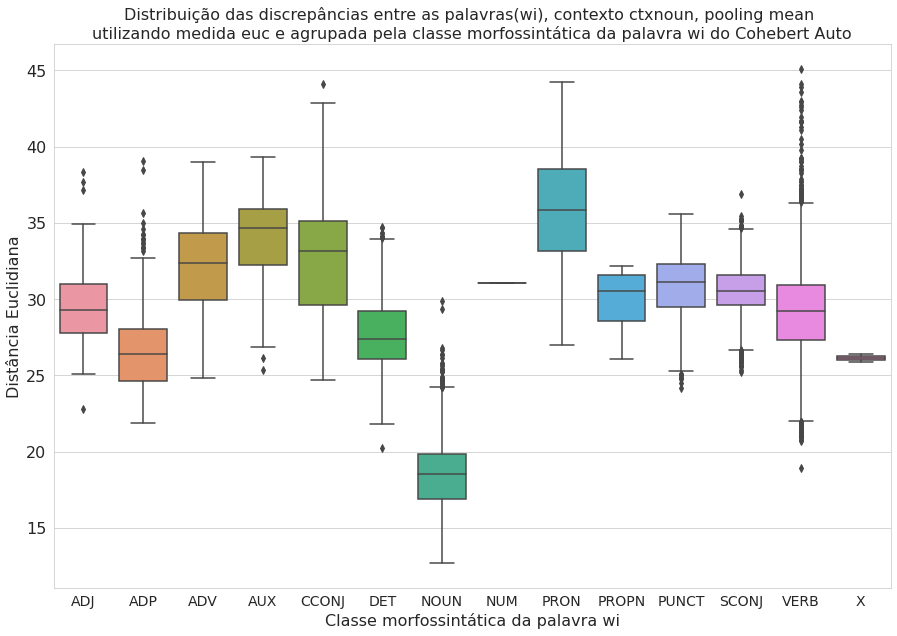

In [164]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [165]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [166]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     96.000000 29.602226 2.802358 22.792593 27.779145 29.291552 31.020362   
ADP   2037.000000 26.592693 2.473065 21.896643 24.631161 26.419027 28.038349   
ADV   1283.000000 33.327697 2.370458 28.291952 31.242836 33.564926 35.145735   
AUX   1046.000000 34.064258 2.556271 25.340181 32.234055 34.667149 35.922763   
CCONJ 1416.000000 33.042978 4.212497 24.671202 29.588723 33.157539 35.108110   
DET   3508.000000 27.974317 2.963300 20.199186 26.055260 27.559044 29.535004   
NOUN  5448.000000 20.249109 3.798347 12.678499 17.208298 19.577990 22.695449   
NUM      1.000000 31.077429      NaN 31.077429 31.077429 31.077429 31.077429   
PRON  2064.000000 35.521286 3.577519 26.955944 33.130333 35.858948 38.532158   
PROPN    5.000000 29.781770 2.476990 26.088955 28.558144 30.536522 31.564049   
PUNCT 2026.000000 30.834368 1.945448 24.139624 29.472987 31.099554 32.294683   
SCONJ  841.000000 30.491786 2.013682 25.191910 29.619759 30.521303 31.601948   
VERB  2144.000000 31.145475 3.342599 22.833176 28.846178 30.390471 32.997500   
X        2.000000 26.134997 0.344238 25.891584 26.013291 26.134997 26.256704   

            max  
pos_i            
ADJ   38.370243  
ADP   39.059937  
ADV   39.248234  
AUX   39.341640  
CCONJ 44.097256  
DET   39.042725  
NOUN  33.306309  
NUM   31.077429  
PRON  44.229790  
PROPN 32.161182  
PUNCT 35.573391  
SCONJ 36.894924  
VERB  45.103558  
X     26.378410

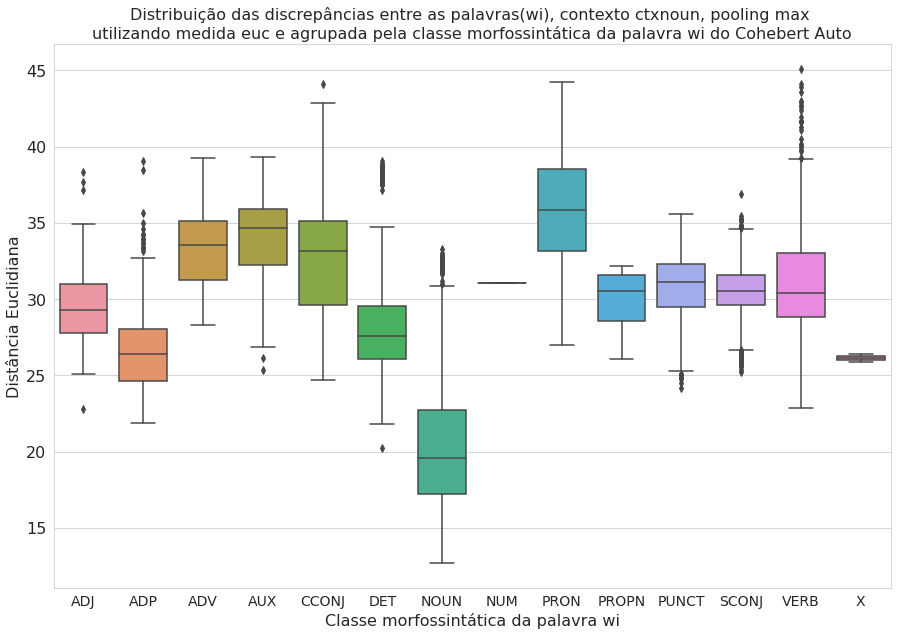

In [167]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [168]:
medida = "man"

##### MEAN

In [169]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [170]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     96.000000 1362.085030 129.035435 1096.179100 1265.587250 1333.232450   
ADP   2037.000000 1279.062499 109.209227 1060.830700 1201.384500 1256.995500   
ADV   1283.000000 1540.785338 157.277015 1155.842300 1463.524550 1567.829800   
AUX   1046.000000 1576.749582  99.234360 1220.643200 1512.499525 1600.718600   
CCONJ 1416.000000 1484.848829 138.714659 1224.096200 1336.940000 1522.396500   
DET   3508.000000 1304.943033  96.746711 1001.147200 1237.208800 1288.956950   
NOUN  5448.000000  862.337566  95.357200  579.876200  787.393862  867.728170   
NUM      1.000000 1474.963900        NaN 1474.963900 1474.963900 1474.963900   
PRON  2064.000000 1681.598892 148.213783 1327.291100 1581.069775 1680.396400   
PROPN    5.000000 1390.549600 138.385184 1207.381100 1335.945800 1353.811300   
PUNCT 2026.000000 1493.503750  81.138632 1185.577900 1439.589925 1493.286900   
SCONJ  841.000000 1461.294552  90.116371 1231.039600 1421.029300 1472.739600   
VERB  2144.000000 1381.288009 146.540174  897.340000 1287.425325 1394.181900   
X        2.000000 1210.411550  10.081009 1203.283200 1206.847375 1210.411550   

              75%         max  
pos_i                          
ADJ   1415.640850 1749.608800  
ADP   1338.570100 1850.620000  
ADV   1665.927250 1834.112300  
AUX   1643.020750 1787.671400  
CCONJ 1608.639625 1787.580000  
DET   1362.751600 1681.467800  
NOUN   933.911530 1299.002900  
NUM   1474.963900 1474.963900  
PRON  1818.223575 1993.807400  
PROPN 1504.981400 1550.628400  
PUNCT 1562.682900 1717.736300  
SCONJ 1503.804000 1788.438200  
VERB  1471.461000 1822.874300  
X     1213.975725 1217.539900

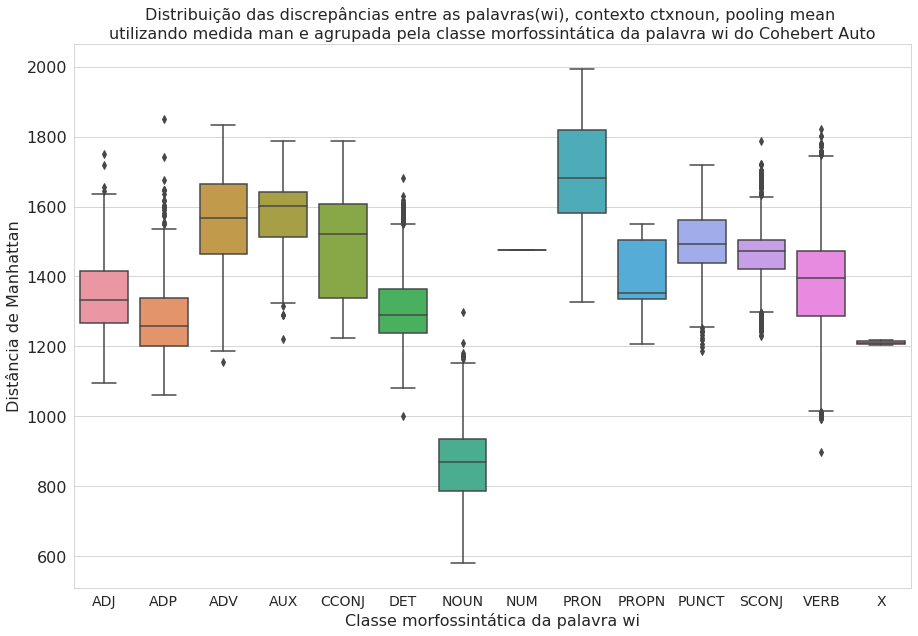

In [171]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [172]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [173]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     96.000000 1362.085030 129.035435 1096.179100 1265.587250 1333.232450   
ADP   2037.000000 1279.062499 109.209227 1060.830700 1201.384500 1256.995500   
ADV   1283.000000 1617.634302 110.108754 1378.614300 1505.492900 1639.716200   
AUX   1046.000000 1576.749582  99.234360 1220.643200 1512.499525 1600.718600   
CCONJ 1416.000000 1484.848829 138.714659 1224.096200 1336.940000 1522.396500   
DET   3508.000000 1321.508713 127.920851 1001.147200 1239.178050 1297.633100   
NOUN  5448.000000  955.770261 194.537736  579.876200  802.184450  925.166030   
NUM      1.000000 1474.963900        NaN 1474.963900 1474.963900 1474.963900   
PRON  2064.000000 1681.598892 148.213783 1327.291100 1581.069775 1680.396400   
PROPN    5.000000 1390.549600 138.385184 1207.381100 1335.945800 1353.811300   
PUNCT 2026.000000 1493.503750  81.138632 1185.577900 1439.589925 1493.286900   
SCONJ  841.000000 1461.294552  90.116371 1231.039600 1421.029300 1472.739600   
VERB  2144.000000 1475.511205 138.155712 1088.467200 1380.218500 1450.724900   
X        2.000000 1210.411550  10.081009 1203.283200 1206.847375 1210.411550   

              75%         max  
pos_i                          
ADJ   1415.640850 1749.608800  
ADP   1338.570100 1850.620000  
ADV   1699.263900 1900.606200  
AUX   1643.020750 1787.671400  
CCONJ 1608.639625 1787.580000  
DET   1374.061250 1841.162400  
NOUN  1067.793350 1654.907500  
NUM   1474.963900 1474.963900  
PRON  1818.223575 1993.807400  
PROPN 1504.981400 1550.628400  
PUNCT 1562.682900 1717.736300  
SCONJ 1503.804000 1788.438200  
VERB  1566.909025 1822.874300  
X     1213.975725 1217.539900

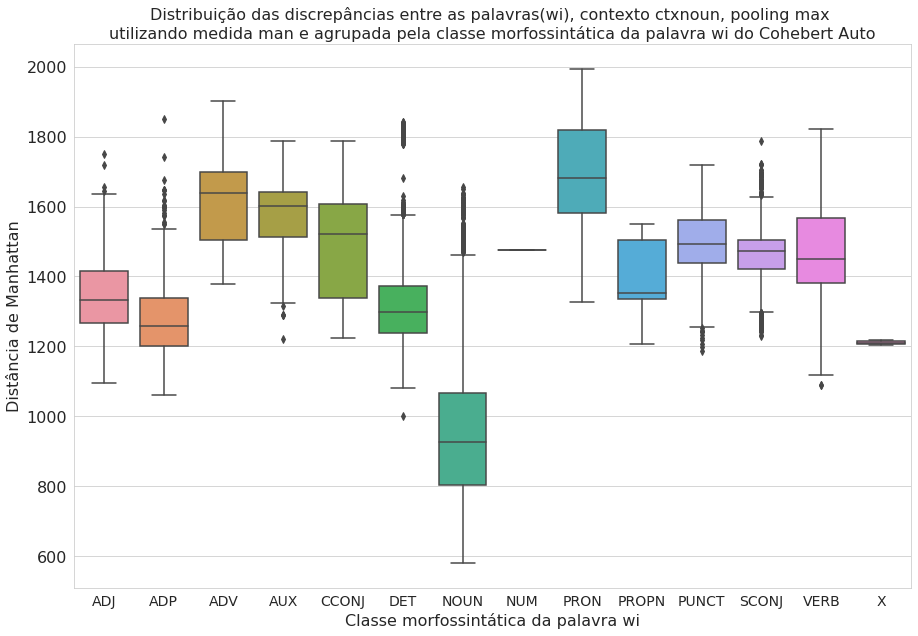

In [174]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

In [175]:
equacao_medida = "ctxverbnoun"

#### COS

In [176]:
medida = "cos"

##### MEAN

In [177]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [178]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     96.000000 0.760785 0.022540 0.716600 0.741834 0.764528 0.776422   
ADP   2037.000000 0.774779 0.034143 0.675486 0.752572 0.778975 0.800947   
ADV   1283.000000 0.733598 0.034021 0.648762 0.709170 0.732260 0.751344   
AUX   1046.000000 0.788231 0.024569 0.728083 0.773558 0.785550 0.798626   
CCONJ 1416.000000 0.631695 0.203368 0.143648 0.682915 0.712271 0.737281   
DET   3508.000000 0.762396 0.040155 0.615020 0.739062 0.764768 0.790948   
NOUN  5448.000000 0.862728 0.027337 0.775607 0.843757 0.862512 0.881221   
NUM      1.000000 0.711114      NaN 0.711114 0.711114 0.711114 0.711114   
PRON  2064.000000 0.680760 0.043219 0.563355 0.647576 0.675865 0.706113   
PROPN    5.000000 0.762505 0.012520 0.753359 0.755303 0.758028 0.761635   
PUNCT 2026.000000 0.710982 0.022685 0.635260 0.699930 0.714611 0.725592   
SCONJ  841.000000 0.723153 0.030763 0.663459 0.700191 0.714098 0.743018   
VERB  2144.000000 0.859241 0.032753 0.748076 0.836825 0.867402 0.884020   
X        2.000000 0.752081 0.016992 0.740066 0.746074 0.752081 0.758089   

           max  
pos_i           
ADJ   0.820402  
ADP   0.858303  
ADV   0.835253  
AUX   0.925030  
CCONJ 0.809713  
DET   0.870029  
NOUN  0.941285  
NUM   0.711114  
PRON  0.815548  
PROPN 0.784200  
PUNCT 0.780773  
SCONJ 0.803121  
VERB  0.930165  
X     0.764096

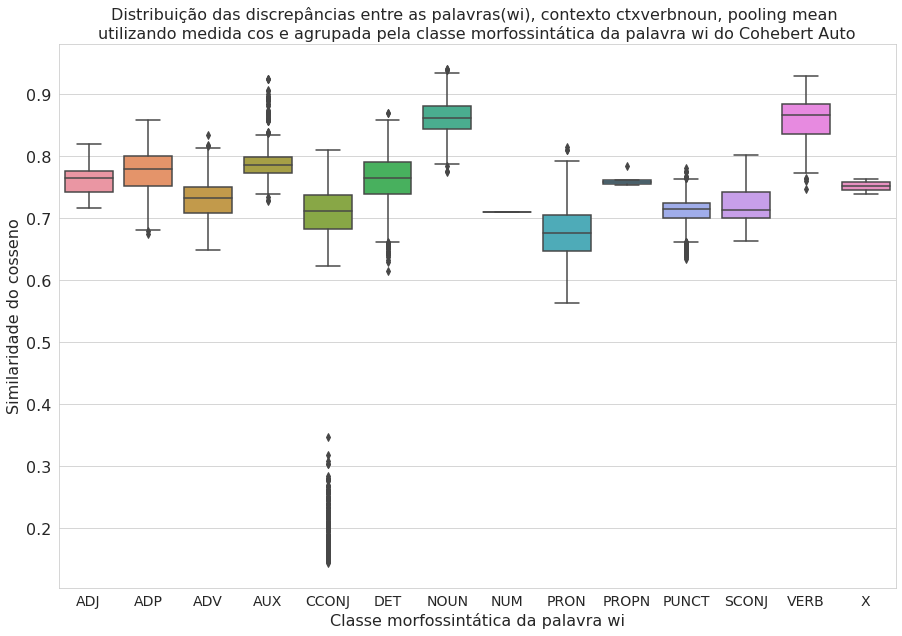

In [179]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [180]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [181]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                     
ADJ     96.000000 0.760785 0.022540 0.716600 0.741834 0.764528 0.776422   
ADP   2037.000000 0.774779 0.034143 0.675486 0.752572 0.778975 0.800947   
ADV   1283.000000 0.710640 0.037413 0.584556 0.688457 0.719602 0.740289   
AUX   1046.000000 0.788231 0.024569 0.728083 0.773558 0.785550 0.798626   
CCONJ 1416.000000 0.631695 0.203368 0.143648 0.682915 0.712271 0.737281   
DET   3508.000000 0.756975 0.047539 0.585560 0.735724 0.761145 0.788620   
NOUN  5448.000000 0.839608 0.054359 0.664612 0.807405 0.854361 0.876845   
NUM      1.000000 0.711114      NaN 0.711114 0.711114 0.711114 0.711114   
PRON  2064.000000 0.680760 0.043219 0.563355 0.647576 0.675865 0.706113   
PROPN    5.000000 0.762505 0.012520 0.753359 0.755303 0.758028 0.761635   
PUNCT 2026.000000 0.710982 0.022685 0.635260 0.699930 0.714611 0.725592   
SCONJ  841.000000 0.723153 0.030763 0.663459 0.700191 0.714098 0.743018   
VERB  2144.000000 0.827315 0.076691 0.621991 0.784584 0.857979 0.881735   
X        2.000000 0.752081 0.016992 0.740066 0.746074 0.752081 0.758089   

           max  
pos_i           
ADJ   0.820402  
ADP   0.858303  
ADV   0.785904  
AUX   0.925030  
CCONJ 0.809713  
DET   0.870029  
NOUN  0.941285  
NUM   0.711114  
PRON  0.815548  
PROPN 0.784200  
PUNCT 0.780773  
SCONJ 0.803121  
VERB  0.930165  
X     0.764096

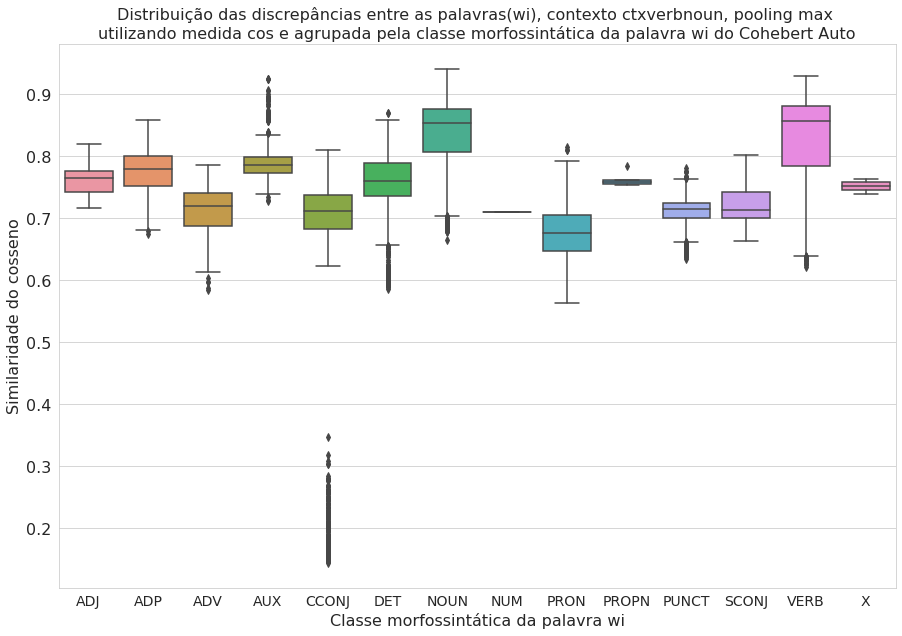

In [182]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [183]:
medida = "euc"

##### MEAN

In [184]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [185]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     96.000000 29.224632 2.610588 22.792593 27.246830 29.186428 30.232780   
ADP   2037.000000 25.881285 1.815381 21.532887 24.545181 25.789360 27.018854   
ADV   1283.000000 27.194871 2.346822 19.414307 26.111341 27.623713 28.751826   
AUX   1046.000000 24.467437 1.440735 15.920229 23.652963 24.627344 25.432447   
CCONJ 1416.000000 29.096942 4.300254 23.718983 26.392316 27.649679 29.326786   
DET   3508.000000 25.406640 2.352288 19.492071 23.680083 25.076853 26.699295   
NOUN  5448.000000 20.746476 2.393341 14.569008 19.145518 20.730470 22.155801   
NUM      1.000000 31.077429      NaN 31.077429 31.077429 31.077429 31.077429   
PRON  2064.000000 30.152316 2.010815 26.086239 28.434232 29.929830 31.887876   
PROPN    5.000000 29.781770 2.476990 26.088955 28.558144 30.536522 31.564049   
PUNCT 2026.000000 28.123228 1.291457 24.139624 27.235083 27.998245 28.847426   
SCONJ  841.000000 27.813495 1.795973 23.305571 26.814421 28.327759 29.011959   
VERB  2144.000000 21.817504 3.201940 13.450162 19.476600 21.769080 23.625577   
X        2.000000 26.134997 0.344238 25.891584 26.013291 26.134997 26.256704   

            max  
pos_i            
ADJ   37.544685  
ADP   38.323582  
ADV   36.077942  
AUX   28.234886  
CCONJ 40.750755  
DET   33.319431  
NOUN  37.192081  
NUM   31.077429  
PRON  36.959354  
PROPN 32.161182  
PUNCT 33.584991  
SCONJ 33.094658  
VERB  36.040161  
X     26.378410

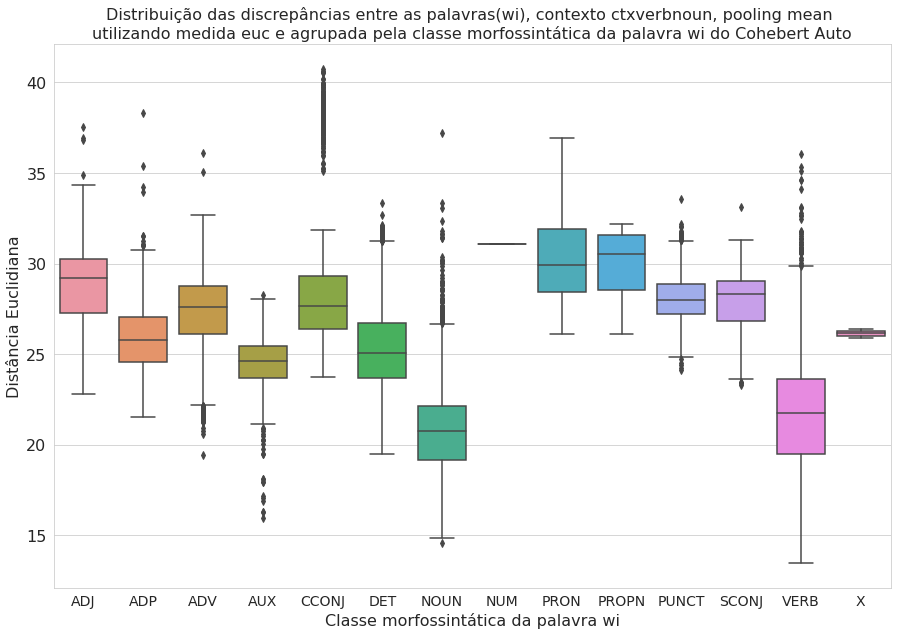

In [186]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [187]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [188]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                          
ADJ     96.000000 29.224632 2.610588 22.792593 27.246830 29.186428 30.232780   
ADP   2037.000000 25.881285 1.815381 21.532887 24.545181 25.789360 27.018854   
ADV   1283.000000 28.778759 2.306546 24.862608 27.119429 28.318844 29.839990   
AUX   1046.000000 24.467437 1.440735 15.920229 23.652963 24.627344 25.432447   
CCONJ 1416.000000 29.096942 4.300254 23.718983 26.392316 27.649679 29.326786   
DET   3508.000000 25.778972 2.759484 19.492071 23.832139 25.304037 26.871962   
NOUN  5448.000000 22.479272 3.308791 14.845482 19.965848 22.050944 24.943474   
NUM      1.000000 31.077429      NaN 31.077429 31.077429 31.077429 31.077429   
PRON  2064.000000 30.152316 2.010815 26.086239 28.434232 29.929830 31.887876   
PROPN    5.000000 29.781770 2.476990 26.088955 28.558144 30.536522 31.564049   
PUNCT 2026.000000 28.123228 1.291457 24.139624 27.235083 27.998245 28.847426   
SCONJ  841.000000 27.813495 1.795973 23.305571 26.814421 28.327759 29.011959   
VERB  2144.000000 24.115476 4.356482 15.222116 20.609271 23.542373 26.720424   
X        2.000000 26.134997 0.344238 25.891584 26.013291 26.134997 26.256704   

            max  
pos_i            
ADJ   37.544685  
ADP   38.323582  
ADV   36.663410  
AUX   28.234886  
CCONJ 40.750755  
DET   36.347576  
NOUN  37.192081  
NUM   31.077429  
PRON  36.959354  
PROPN 32.161182  
PUNCT 33.584991  
SCONJ 33.094658  
VERB  36.040161  
X     26.378410

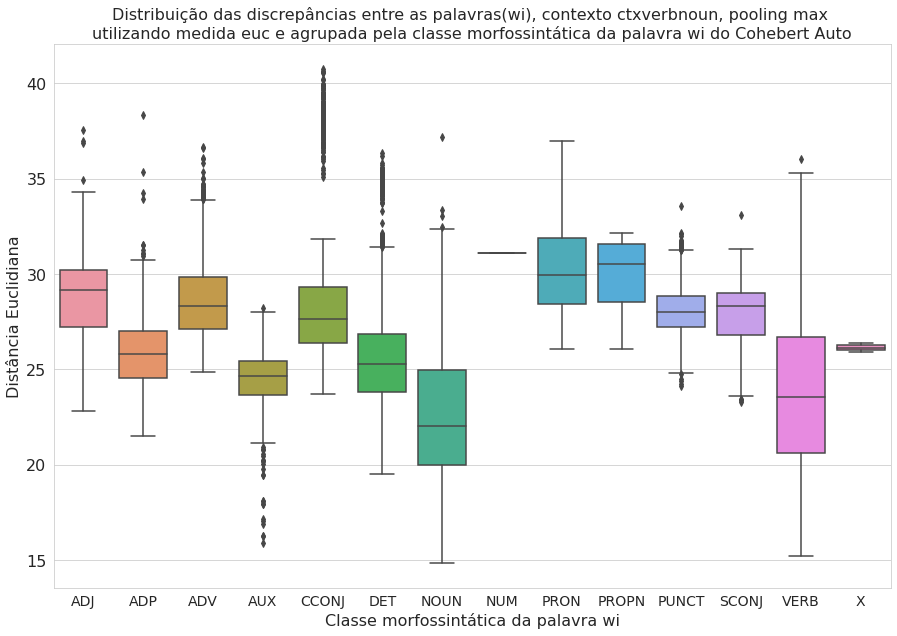

In [189]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [190]:
medida = "man"

##### MEAN

In [191]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [192]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     96.000000 1340.026153 103.153854 1096.179100 1265.587250 1309.620650   
ADP   2037.000000 1251.839221  81.717293 1036.712400 1194.157500 1245.021500   
ADV   1283.000000 1333.785135 123.585339  931.587000 1282.716300 1365.840600   
AUX   1046.000000 1127.110117  58.062026  770.128500 1093.450625 1129.635400   
CCONJ 1416.000000 1310.095026  79.387152 1164.498900 1242.238175 1315.806650   
DET   3508.000000 1214.001704  97.397072  979.898300 1148.455150 1201.073200   
NOUN  5448.000000  974.842090 103.451784  697.053400  899.060485  980.612200   
NUM      1.000000 1474.963900        NaN 1474.963900 1474.963900 1474.963900   
PRON  2064.000000 1444.673689  83.869321 1276.279900 1372.367325 1424.987300   
PROPN    5.000000 1390.549600 138.385184 1207.381100 1335.945800 1353.811300   
PUNCT 2026.000000 1375.807644  46.972312 1185.577900 1345.327850 1376.318800   
SCONJ  841.000000 1342.238417  76.686483 1139.973100 1301.345800 1370.273200   
VERB  2144.000000 1025.778449 132.949316  655.001100  930.330340 1013.582780   
X        2.000000 1210.411550  10.081009 1203.283200 1206.847375 1210.411550   

              75%         max  
pos_i                          
ADJ   1400.576225 1640.687900  
ADP   1306.344700 1689.013500  
ADV   1410.919400 1674.829300  
AUX   1162.828600 1302.070300  
CCONJ 1368.986050 1528.319100  
DET   1259.974025 1541.136200  
NOUN  1044.686500 1345.252200  
NUM   1474.963900 1474.963900  
PRON  1523.899350 1653.078500  
PROPN 1504.981400 1550.628400  
PUNCT 1408.401000 1549.771500  
SCONJ 1394.523000 1534.176100  
VERB  1120.168650 1447.413000  
X     1213.975725 1217.539900

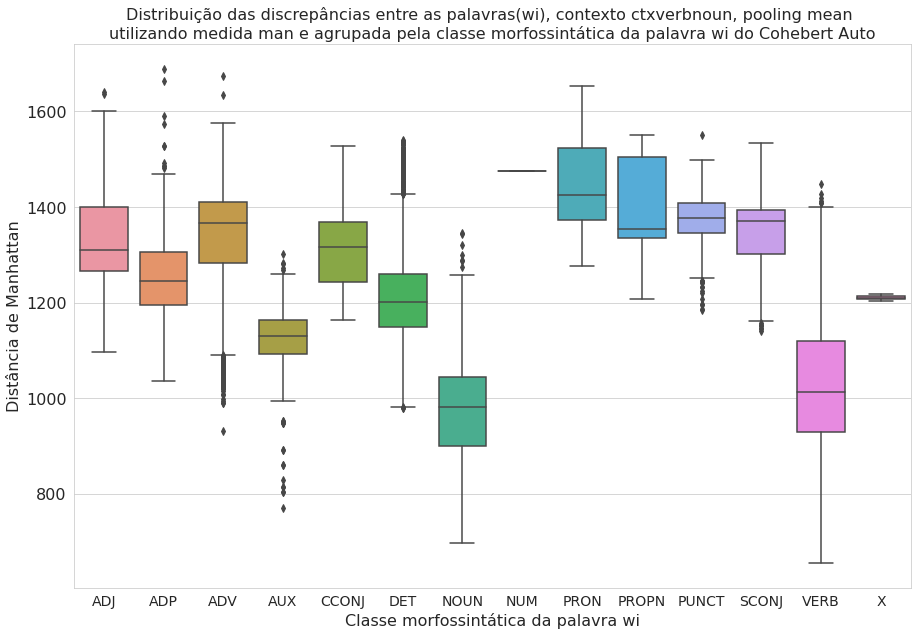

In [193]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [194]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [195]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                          
ADJ     96.000000 1340.026153 103.153854 1096.179100 1265.587250 1309.620650   
ADP   2037.000000 1251.839221  81.717293 1036.712400 1194.157500 1245.021500   
ADV   1283.000000 1416.156736 110.778458 1214.603500 1344.016500 1392.538600   
AUX   1046.000000 1127.110117  58.062026  770.128500 1093.450625 1129.635400   
CCONJ 1416.000000 1310.095026  79.387152 1164.498900 1242.238175 1315.806650   
DET   3508.000000 1232.910540 121.403592  984.296700 1153.706900 1207.191950   
NOUN  5448.000000 1063.802283 166.724601  711.161130  941.058950 1042.541200   
NUM      1.000000 1474.963900        NaN 1474.963900 1474.963900 1474.963900   
PRON  2064.000000 1444.673689  83.869321 1276.279900 1372.367325 1424.987300   
PROPN    5.000000 1390.549600 138.385184 1207.381100 1335.945800 1353.811300   
PUNCT 2026.000000 1375.807644  46.972312 1185.577900 1345.327850 1376.318800   
SCONJ  841.000000 1342.238417  76.686483 1139.973100 1301.345800 1370.273200   
VERB  2144.000000 1139.873823 199.089943  725.644800  977.540240 1115.809450   
X        2.000000 1210.411550  10.081009 1203.283200 1206.847375 1210.411550   

              75%         max  
pos_i                          
ADJ   1400.576225 1640.687900  
ADP   1306.344700 1689.013500  
ADV   1462.528950 1774.104700  
AUX   1162.828600 1302.070300  
CCONJ 1368.986050 1528.319100  
DET   1266.299575 1730.400900  
NOUN  1169.597150 1613.944800  
NUM   1474.963900 1474.963900  
PRON  1523.899350 1653.078500  
PROPN 1504.981400 1550.628400  
PUNCT 1408.401000 1549.771500  
SCONJ 1394.523000 1534.176100  
VERB  1267.413500 1611.613300  
X     1213.975725 1217.539900

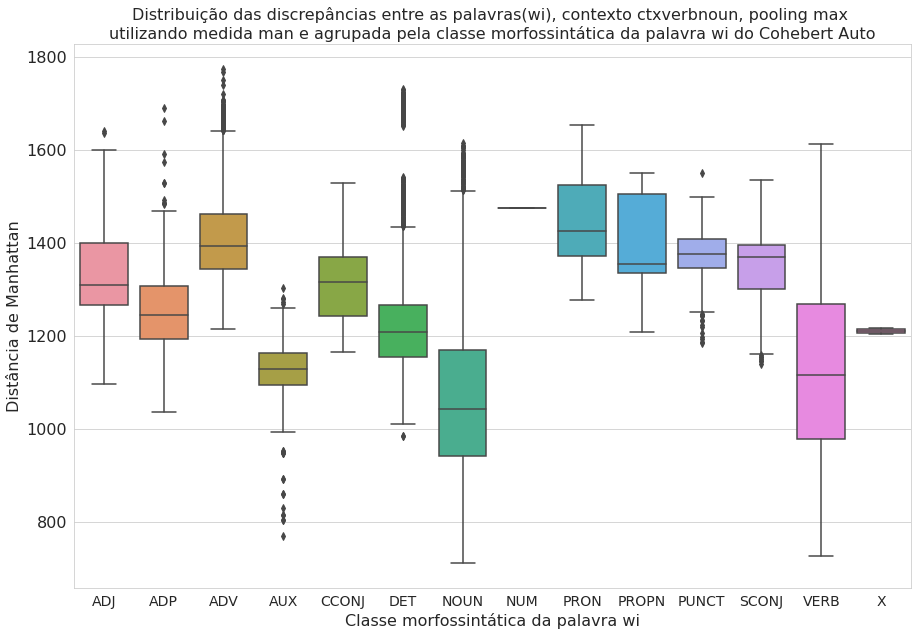

In [196]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do Cohebert Auto")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias do contexto e palavras

### Geral

Conta pares de classes de palavras

In [197]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_contexto.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_contexto))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao[4]] += 1

Documentos:   0%|          | 0/21917 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [198]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

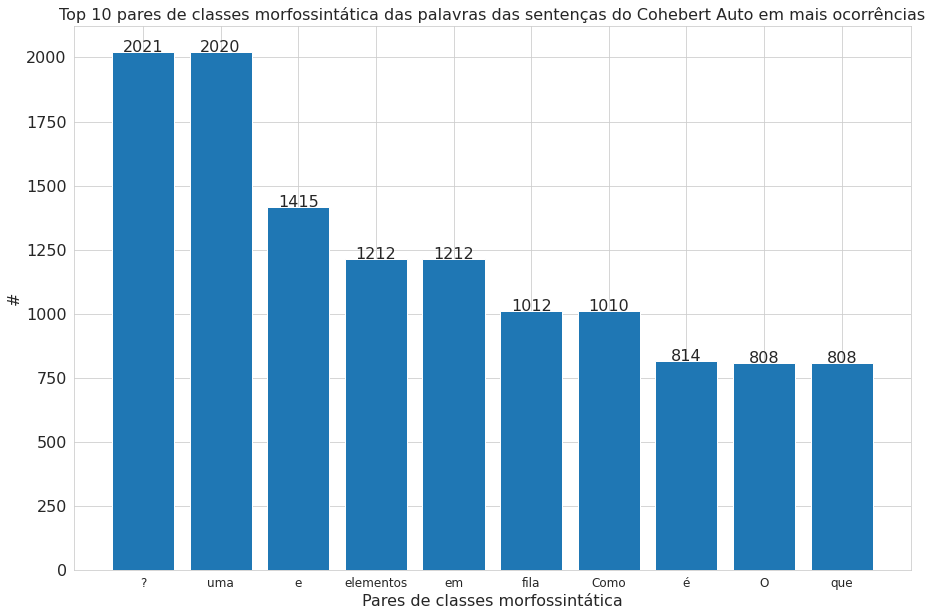

In [199]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do Cohebert Auto em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras (ctxall)

#### VERB

In [200]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [201]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2144


Estatísticas das medidas dos contextos e palavras

In [202]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean" ,"euc_ctxall_mean",
                          "man_ctxall_max"  ,"cos_ctxall_max",
                          "euc_ctxall_max"  ,"man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_max  cos_ctxall_max  \
count      2144.000000      2144.000000     2144.000000     2144.000000   
mean          0.821660        24.265282     1258.529808        0.788542   
std           0.047939         5.486711      129.407555        0.038563   
min           0.677554        10.737125      902.745000        0.677554   
25%           0.792281        21.812787     1166.218500        0.760503   
50%           0.811214        24.924773     1257.011850        0.795271   
75%           0.846454        27.639659     1350.501675        0.815660   
max           0.954515        42.080738     1649.376100        0.881739   

       euc_ctxall_max  man_ctxall_max  
count     2144.000000     2144.000000  
mean        26.829000     1258.529808  
std          3.284109      129.407555  
min         18.909819      902.745000  
25%         24.748127     1166.218500  
50%         26.557864     1257.011850  
75%         28.470075     1350.501675  
max         42.080738     1649.376100

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [203]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2144 [00:00<?, ? documento/s]

In [204]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [205]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  850
      2        1  591
      3        6  310
      4        2  168
      5        3  114
      6        8  111


##### COS - MEAN

In [206]:
medida = "cos_ctxall_mean"

Documentos outliers

In [207]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.054172590374946594
Limite superior             : 0.9277124330401421
Limite inferior             : 0.7110220715403557


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [208]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 7 de 2144 ( 0.0032649253731343282 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [209]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 9 de 2144 ( 0.004197761194029851 )


In [210]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  16 de 2144 ( 0.007462686567164179 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [211]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.954514741897583 enfileirar
         Como enfileirar elementos em uma pilha?

 2 0.9462554454803468 empilhar
         Como empilhar e desempilhar elementos em uma fila?

 3 0.9417277574539183 desenfileirar
         Como desenfileirar elementos em uma pilha?

 4 0.9360277056694032 empilhar
         Como empilhar elementos em uma fila?

 5 0.9342679977416992 enfileirar
         O que é uma pilha e como enfileirar e desenfileirar seus elementos?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [212]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6775538921356201 fechar
         Como são implementadas as operações de empilhar e fechar elementos em uma fila ?

 2 0.6839336156845093 remover
         Como são implementadas as operações de empilhar e remover elementos em uma fila ?

 3 0.6889811754226685 pôr
         Como são implementadas as operações de empilhar e pôr elementos em uma fila ?

 4 0.698283851146698 colar
         Como são implementadas as operações de empilhar e colar elementos em uma fila ?

 5 0.7000384330749512 chamadas
         Como são chamadas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [213]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e ver elementos em uma fila ?
       1 0.891673743724823 empilhar
       2 0.7756856679916382 implementadas
       3 0.7103151082992554 ver

 2 Como são conhecidas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 0.9060392379760742 enfileirar
       2 0.7102940678596497 conhecidas

 3 Como são implementadas as operações de empilhar e enviar elementos em uma fila ?
       1 0.8910483121871948 empilhar
       2 0.791749894618988 implementadas
       3 0.7095881700515747 enviar

 4 Como são implementadas as operações de empilhar e retirar elementos em uma fila ?
       1 0.8840426802635193 empilhar
       2 0.7974769473075867 implementadas
       3 0.705891489982605 retirar

 5 Como são chamadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 0.9060643911361694 enfileirar
       2 0.7000384330749512 chamadas


##### COS - MAX

In [214]:
medida = "cos_ctxall_max"

Documentos outliers

In [215]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05515679717063904
Limite superior             : 0.8983950316905975
Limite inferior             : 0.6777678430080414


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [216]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [217]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 2144 ( 0.0004664179104477612 )


In [218]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 2144 ( 0.0004664179104477612 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [219]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [220]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6775538921356201 fechar
         Como são implementadas as operações de empilhar e fechar elementos em uma fila ?


###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [221]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e fechar elementos em uma fila ?
       1 0.7682785391807556 empilhar
       2 0.7440029382705688 implementadas
       3 0.6775538921356201 fechar


##### EUC - MEAN

In [222]:
medida = "euc_ctxall_mean"

Documentos outliers

In [223]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.826871871948242
Limite superior             : 36.379966735839844
Limite inferior             : 13.072479248046875


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [224]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 27 de 2144 ( 0.012593283582089552 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [225]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 5 de 2144 ( 0.0023320895522388058 )


In [226]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  32 de 2144 ( 0.014925373134328358 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [227]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.08073806762695 disputadas
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 42.00661087036133 Ocorre
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?

 3 41.61915588378906 acontecem
         Em uma pilha a operação de enfileirar acontecem em qual extremidade ?

 4 41.3343391418457 ocorrem
         Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?

 5 40.27592468261719 ocorrer
         Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [228]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 10.737125396728516 enfileirar
         Como enfileirar elementos em uma pilha?

 2 11.495111465454102 empilhar
         Como empilhar e desempilhar elementos em uma fila?

 3 12.061164855957031 desenfileirar
         Como desenfileirar elementos em uma pilha?

 4 12.719804763793944 empilhar
         Como empilhar elementos em uma fila?

 5 12.722736358642578 enfileirar
         O que é uma pilha e como enfileirar e desenfileirar seus elementos?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [229]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 42.08073806762695 disputadas
       2 14.441685676574709 enfileirar

 2 Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?
       1 42.00661087036133 Ocorre
       2 16.206682205200195 enfileirar

 3 Em uma pilha a operação de enfileirar acontecem em qual extremidade ?
       1 41.61915588378906 acontecem
       2 16.38022232055664 enfileirar

 4 Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?
       1 41.3343391418457 ocorrem
       2 16.264902114868164 enfileirar

 5 Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?
       1 40.27592468261719 ocorrer
       2 16.104219436645508 enfileirar


##### EUC - MAX

In [230]:
medida = "euc_ctxall_max"

Documentos outliers

In [231]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.72194766998291
Limite superior             : 34.05299615859985
Limite inferior             : 19.165205478668213


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [232]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 63 de 2144 ( 0.029384328358208957 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [233]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 2144 ( 0.0009328358208955224 )


In [234]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  65 de 2144 ( 0.03031716417910448 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [235]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.08073806762695 disputadas
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 42.00661087036133 Ocorre
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?

 3 41.61915588378906 acontecem
         Em uma pilha a operação de enfileirar acontecem em qual extremidade ?

 4 41.3343391418457 ocorrem
         Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?

 5 40.27592468261719 ocorrer
         Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [236]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 18.909818649291992 criar
         Como criar elementos em uma fila ?

 2 19.084943771362305 deixar
         Como deixar elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [237]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 42.08073806762695 disputadas
       2 27.373687744140625 enfileirar

 2 Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?
       1 42.00661087036133 Ocorre
       2 27.579490661621094 enfileirar

 3 Em uma pilha a operação de enfileirar acontecem em qual extremidade ?
       1 41.61915588378906 acontecem
       2 27.852706909179688 enfileirar

 4 Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?
       1 41.3343391418457 ocorrem
       2 27.762056350708008 enfileirar

 5 Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?
       1 40.27592468261719 ocorrer
       2 28.160951614379883 enfileirar


##### MAN - MEAN

In [238]:
medida = "man_ctxall_mean"

Documentos outliers

In [239]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 232.96797500000002
Limite superior             : 1626.2837375000001
Limite inferior             : 694.4118375


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [240]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 6 de 2144 ( 0.002798507462686567 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [241]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 40 de 2144 ( 0.018656716417910446 )


In [242]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  46 de 2144 ( 0.021455223880597014 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [243]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1649.3761 feito
         Como são feito as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 1642.5815 dados
         Como são dados as operações de enfileirar e desenfileirar elementos em uma pilha ?

 3 1634.7971 realizado
         Como são realizado as operações de enfileirar e desenfileirar elementos em uma pilha ?

 4 1634.5925 ocorrem
         Como são ocorrem as operações de enfileirar e desenfileirar elementos em uma pilha ?

 5 1633.0039 enviadas
         Como são enviadas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [244]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 523.81116 enfileirar
         Como enfileirar elementos em uma pilha?

 2 564.3269 empilhar
         Como empilhar e desempilhar elementos em uma fila?

 3 593.1605 desenfileirar
         Como desenfileirar elementos em uma pilha?

 4 623.1359 enfileirar
         O que é uma pilha e como enfileirar e desenfileirar seus elementos?

 5 623.9054 empilhar
         Como empilhar elementos em uma fila?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [245]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são feito as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1649.3761 feito
       2 696.34143 enfileirar

 2 Como são dados as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1642.5815 dados
       2 693.34436 enfileirar

 3 Como são realizado as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1634.7971 realizado
       2 699.6156 enfileirar

 4 Como são ocorrem as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1634.5925 ocorrem
       2 705.3771 enfileirar

 5 Como são enviadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1633.0039 enviadas
       2 698.6072 enfileirar


##### MAN - MAX

In [246]:
medida = "man_ctxall_max"

Documentos outliers

In [247]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 184.28317500000003
Limite superior             : 1626.9264375
Limite inferior             : 889.7937374999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [248]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 5 de 2144 ( 0.0023320895522388058 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [249]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [250]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5 de 2144 ( 0.0023320895522388058 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [251]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1649.3761 feito
         Como são feito as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 1642.5815 dados
         Como são dados as operações de enfileirar e desenfileirar elementos em uma pilha ?

 3 1634.7971 realizado
         Como são realizado as operações de enfileirar e desenfileirar elementos em uma pilha ?

 4 1634.5925 ocorrem
         Como são ocorrem as operações de enfileirar e desenfileirar elementos em uma pilha ?

 5 1633.0039 enviadas
         Como são enviadas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [252]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [253]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são feito as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1649.3761 feito
       2 1383.6545 enfileirar

 2 Como são dados as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1642.5815 dados
       2 1387.7849 enfileirar

 3 Como são realizado as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1634.7971 realizado
       2 1375.4849 enfileirar

 4 Como são ocorrem as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1634.5925 ocorrem
       2 1409.7976 enfileirar

 5 Como são enviadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1633.0039 enviadas
       2 1370.0027 enfileirar


#### NOUN

In [254]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [255]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5448


Estatísticas das medidas dos contextos e palavras

In [256]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean", "cos_ctxall_max","euc_ctxall_max","man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxall_max  \
count      5448.000000      5448.000000      5448.000000     5448.000000   
mean          0.816695        23.565447      1099.233711        0.793015   
std           0.044210         4.336821       178.049797        0.032889   
min           0.729457        11.313010       550.818360        0.696390   
25%           0.778184        20.999165       991.356525        0.767692   
50%           0.814759        23.845531      1124.787700        0.788385   
75%           0.842372        26.503340      1227.003725        0.819288   
max           0.949666        40.800144      1606.093000        0.869701   

       euc_ctxall_max  man_ctxall_max  
count     5448.000000     5448.000000  
mean        25.415758     1193.125959  
std          2.808544      120.852788  
min         19.694954      924.427700  
25%         23.509811     1113.083425  
50%         25.410685     1198.879400  
75%         26.853451     1272.415275  
max         40.800144     1606.093000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [257]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5448 [00:00<?, ? documento/s]

In [258]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [259]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1010
      3        2  812
      4        5  606
      5        7  408
      6       10  303
      7        1  203
      8       11  202
      9       12  202
     10        8  106
     11        6   94
     12        3   88


##### COS - MEAN

In [260]:
medida = "cos_ctxall_mean"

Documentos outliers

In [261]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06418836116790771
Limite superior             : 0.9386546462774277
Limite inferior             : 0.6819012016057968


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [262]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 91 de 5448 ( 0.01670337738619677 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [263]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [264]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  91 de 5448 ( 0.01670337738619677 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [265]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9496655464172364 desempilhar
         Como desempilhar elementos em uma seleção ?

 2 0.9484610557556152 desempilhar
         Como desempilhar elementos em uma janela ?

 3 0.9481006264686584 desempilhar
         Como desempilhar elementos em uma campanha ?

 4 0.947579264640808 desempilhar
         Como desempilhar elementos em uma análise ?

 5 0.9473057985305786 desempilhar
         Como desempilhar elementos em uma cena ?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [266]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [267]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [268]:
medida = "cos_ctxall_max"

Documentos outliers

In [269]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05159614980220795
Limite superior             : 0.8966818824410439
Limite inferior             : 0.6902972832322121


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [270]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5448 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [271]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [272]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5448 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [273]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [274]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [275]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [276]:
medida = "euc_ctxall_mean"

Documentos outliers

In [277]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.504175186157223
Limite superior             : 34.75960254669189
Limite inferior             : 12.742901802062997


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [278]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 40


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [279]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 98 de 5448 ( 0.017988252569750368 )


In [280]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  138 de 5448 ( 0.025330396475770924 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [281]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 40.80014419555664 elemento
         O que é uma fila e como acontece seu elemento ?

 2 40.54894256591797 elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 3 40.35564804077149 elemento
         O que é uma fila e como fazer seu elemento ?

 4 39.9703254699707 elemento
         O que é uma fila e como ocorre seu elemento ?

 5 39.48630142211914 elementos
         Como se elementos em uma fila ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [282]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 11.313010215759276 desempilhar
         Como desempilhar elementos em uma seleção ?

 2 11.382184982299805 desempilhar
         Como desempilhar elementos em uma análise ?

 3 11.506821632385254 desempilhar
         Como desempilhar elementos em uma produção ?

 4 11.515725135803224 desempilhar
         Como desempilhar elementos em uma janela ?

 5 11.54100227355957 desempilhar
         Como desempilhar elementos em uma campanha ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [283]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como acontece seu elemento ?
       1 40.80014419555664 elemento
       2 22.28662109375 fila

 2 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 40.54894256591797 elementos
       2 25.788930892944336 operações
       3 19.53144836425781 fila

 3 O que é uma fila e como fazer seu elemento ?
       1 40.35564804077149 elemento
       2 21.971080780029297 fila

 4 O que é uma fila e como ocorre seu elemento ?
       1 39.9703254699707 elemento
       2 22.241079330444336 fila

 5 Como se elementos em uma fila ?
       1 39.48630142211914 elementos
       2 18.26912879943848 fila


##### EUC - MAX

In [284]:
medida = "euc_ctxall_max"

Documentos outliers

In [285]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.3436398506164586
Limite superior             : 31.868911027908332
Limite inferior             : 18.494351625442498


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [286]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 123


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [287]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [288]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  123 de 5448 ( 0.022577092511013214 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [289]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 40.80014419555664 elemento
         O que é uma fila e como acontece seu elemento ?

 2 40.54894256591797 elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 3 40.35564804077149 elemento
         O que é uma fila e como fazer seu elemento ?

 4 39.9703254699707 elemento
         O que é uma fila e como ocorre seu elemento ?

 5 39.48630142211914 elementos
         Como se elementos em uma fila ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [290]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [291]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como acontece seu elemento ?
       1 40.80014419555664 elemento
       2 26.64636993408203 fila

 2 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 40.54894256591797 elementos
       2 25.788930892944336 operações
       3 24.663745880126957 fila

 3 O que é uma fila e como fazer seu elemento ?
       1 40.35564804077149 elemento
       2 26.316545486450195 fila

 4 O que é uma fila e como ocorre seu elemento ?
       1 39.9703254699707 elemento
       2 26.59929084777832 fila

 5 Como se elementos em uma fila ?
       1 39.48630142211914 elementos
       2 23.49394416809082 fila


##### MAN - MEAN

In [292]:
medida = "man_ctxall_mean"

Documentos outliers

In [293]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 235.6472000000001
Limite superior             : 1580.474525
Limite inferior             : 637.8857249999998


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [294]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [295]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 101 de 5448 ( 0.018538913362701907 )


In [296]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  102 de 5448 ( 0.018722466960352423 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [297]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1606.093 etapas
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [298]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 550.81836 desempilhar
         Como desempilhar elementos em uma seleção ?

 2 551.8656 desempilhar
         Como desempilhar elementos em uma análise ?

 3 561.0103 desempilhar
         Como desempilhar elementos em uma produção ?

 4 564.65796 desempilhar
         Como desempilhar elementos em uma cena ?

 5 566.50415 desempilhar
         Como desempilhar elementos em uma janela ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [299]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1606.093 etapas
       2 1294.1174 elementos
       3 1245.7407 pilha
       4 1159.8152 operações


##### MAN - MAX

In [300]:
medida = "man_ctxall_max"

Documentos outliers

In [301]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 159.3318499999998
Limite superior             : 1511.4130499999997
Limite inferior             : 874.0856500000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [302]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 41


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [303]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [304]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  41 de 5448 ( 0.007525697503671072 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [305]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1606.093 etapas
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 1559.0308 desempilhar
         O que é uma fila e como atrair e desempilhar seus elementos ?

 3 1557.6427 desempilhar
         Como remover e desempilhar elementos em uma estrutura de dados fila ?

 4 1553.7448 desempilhar
         Como trazer e desempilhar elementos em uma estrutura de dados fila ?

 5 1550.759 desempilhar
         Como alterar e desempilhar elementos em uma estrutura de dados fila ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [306]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [307]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1606.093 etapas
       2 1294.1174 elementos
       3 1245.7407 pilha
       4 1159.8152 operações

 2 O que é uma fila e como atrair e desempilhar seus elementos ?
       1 1559.0308 desempilhar
       2 1326.3788 elementos
       3 1264.9482 fila

 3 Como remover e desempilhar elementos em uma estrutura de dados fila ?
       1 1557.6427 desempilhar
       2 1283.4161 fila
       3 1203.7339 elementos
       4 1128.6412 dados
       5 1125.2349 estrutura

 4 Como trazer e desempilhar elementos em uma estrutura de dados fila ?
       1 1553.7448 desempilhar
       2 1289.7698 fila
       3 1181.5514 dados
       4 1158.8193 elementos
       5 1121.8257 estrutura

 5 Como alterar e desempilhar elementos em uma estrutura de dados fila ?
       1 1550.759 desempilhar
       2 1296.8032 fila
       3 1165.4971 elementos
       4 1126.6656 dados
       5 1104.2515 estrutura


#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB(AUX) e NOUN.

##### COS, EUC, MAN

In [308]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    lista_comparacao_classesVV[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            VERB  \
      cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_mean   
count    21917.000000    21917.000000    21917.000000     2144.000000   
mean         0.815542       22.769637     1091.262665        0.821660   
std          0.072103        3.695844      147.396449        0.047939   
min          0.185986       10.737125      523.811160        0.677554   
25%          0.794802       20.720751     1013.578100        0.792281   
50%          0.824959       22.037470     1081.157800        0.811214   
75%          0.844566       24.762648     1173.660900        0.846454   
max          0.954515       42.080738     1666.877300        0.954515   

                                                 NOUN                  \
      euc_ctxall_mean man_ctxall_mean cos_ctxall_mean euc_ctxall_mean   
count     2144.000000     2144.000000     5448.000000     5448.000000   
mean        24.265282     1131.837189        0.816695       23.565447   
std          5.486711      220.670718        0.044210        4.336821   
min         10.737125      523.811160        0.729457       11.313010   
25%         21.812787     1043.863800        0.778184       20.999165   
50%         24.924773     1167.705850        0.814759       23.845531   
75%         27.639659     1276.831775        0.842372       26.503340   
max         42.080738     1649.376100        0.949666       40.800144   

                       
      man_ctxall_mean  
count     5448.000000  
mean      1099.233711  
std        178.049797  
min        550.818360  
25%        991.356525  
50%       1124.787700  
75%       1227.003725  
max       1606.093000

##### COS

In [309]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      cos_ctxall_mean cos_ctxall_mean cos_ctxall_mean
count    21917.000000     2144.000000     5448.000000
mean         0.815542        0.821660        0.816695
std          0.072103        0.047939        0.044210
min          0.185986        0.677554        0.729457
25%          0.794802        0.792281        0.778184
50%          0.824959        0.811214        0.814759
75%          0.844566        0.846454        0.842372
max          0.954515        0.954515        0.949666

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


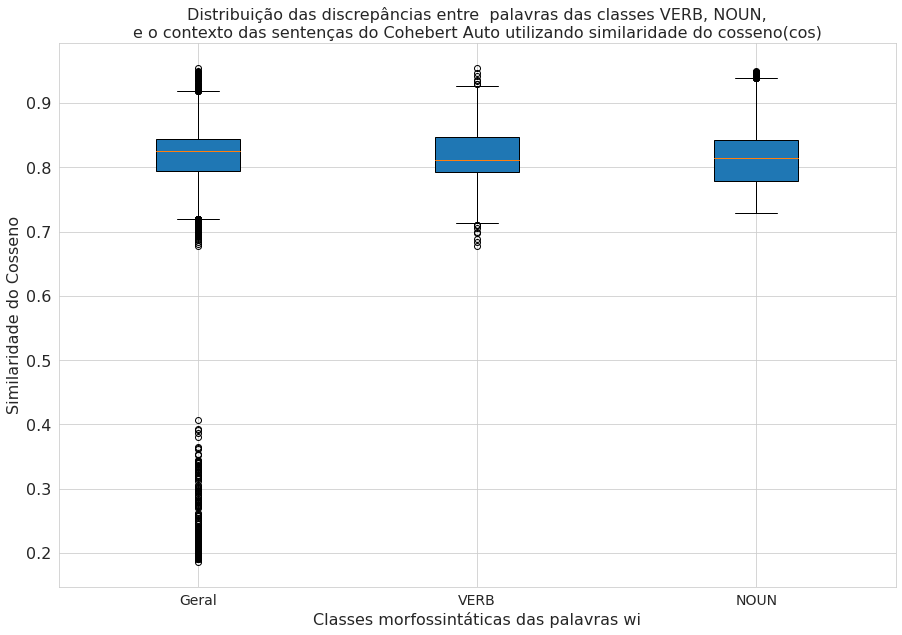

In [310]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxall_mean"]], lista_comparacao_classesVV[["cos_ctxall_mean"]], lista_comparacao_classesNN[["cos_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [311]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxall_mean"]],
                    lista_comparacao_classesVV[["euc_ctxall_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      euc_ctxall_mean euc_ctxall_mean euc_ctxall_mean
count    21917.000000     2144.000000     5448.000000
mean        22.769637       24.265282       23.565447
std          3.695844        5.486711        4.336821
min         10.737125       10.737125       11.313010
25%         20.720751       21.812787       20.999165
50%         22.037470       24.924773       23.845531
75%         24.762648       27.639659       26.503340
max         42.080738       42.080738       40.800144

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


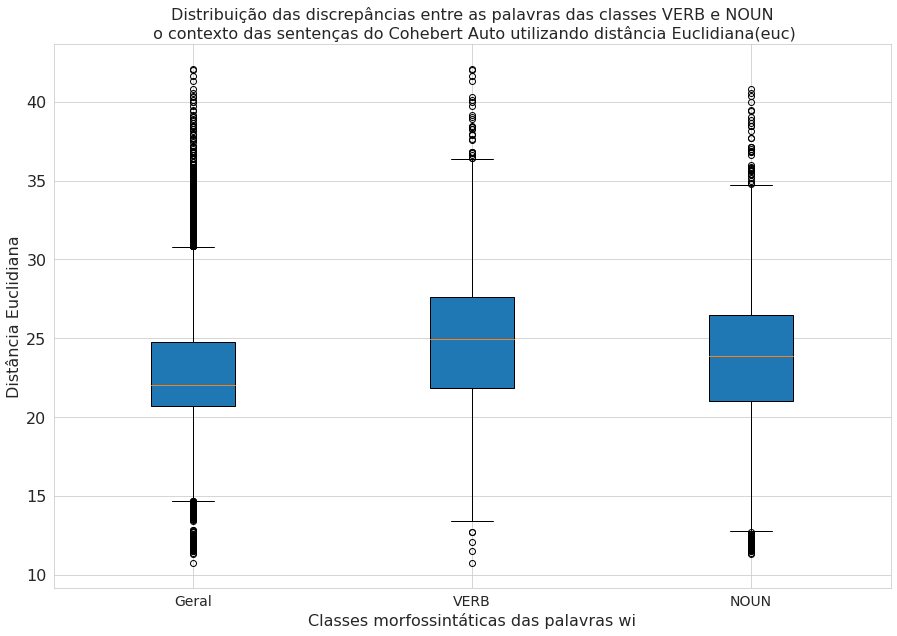

In [312]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxall_mean"]], lista_comparacao_classesVV[["euc_ctxall_mean"]], lista_comparacao_classesNN[["euc_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [313]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxall_mean"]],
                    lista_comparacao_classesVV[["man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["man_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      man_ctxall_mean man_ctxall_mean man_ctxall_mean
count    21917.000000     2144.000000     5448.000000
mean      1091.262665     1131.837189     1099.233711
std        147.396449      220.670718      178.049797
min        523.811160      523.811160      550.818360
25%       1013.578100     1043.863800      991.356525
50%       1081.157800     1167.705850     1124.787700
75%       1173.660900     1276.831775     1227.003725
max       1666.877300     1649.376100     1606.093000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


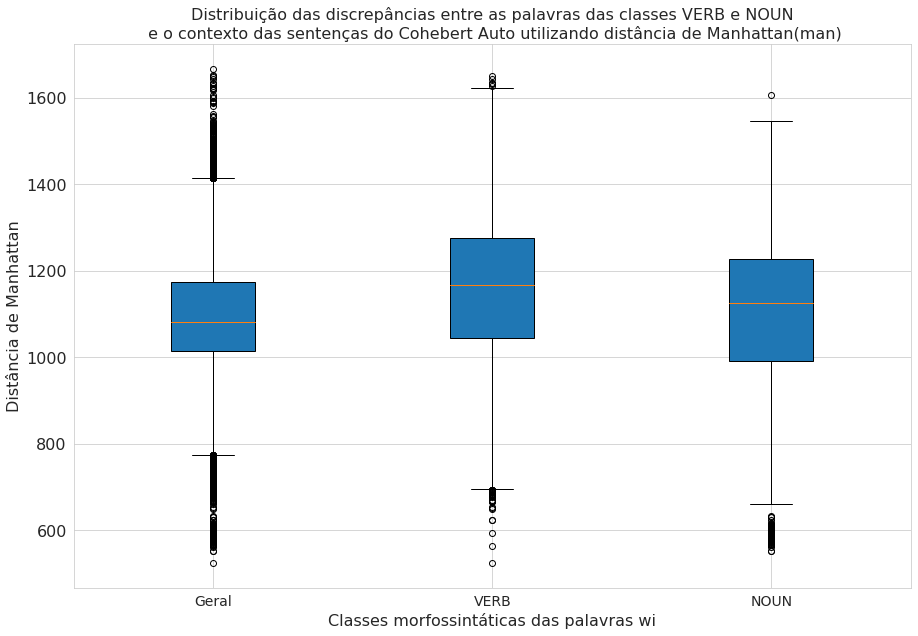

In [314]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxall_mean"]], lista_comparacao_classesVV[["man_ctxall_mean"]], lista_comparacao_classesNN[["man_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com todas as palavras sem stopwords(ctxclean)

#### VERB

In [315]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [316]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2144


Estatísticas das medidas dos contextos e palavras

In [317]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count        2144.000000        2144.000000       2144.000000   
mean            0.849353          22.526125          0.817206   
std             0.032713           3.495565          0.069347   
min             0.673699          13.852946          0.635793   
25%             0.830713          20.187375          0.764745   
50%             0.856636          22.187858          0.846542   
75%             0.873610          24.312386          0.869603   
max             0.920360          38.754295          0.912413   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count       2144.000000       2144.000000        2144.000000  
mean          24.858775       1178.329098        1063.668614  
std            3.906917        178.335752         145.843331  
min           16.645185        803.258200         672.883540  
25%           21.665194       1036.173800         962.018405  
50%           24.226096       1149.046850        1056.647200  
75%           27.472869       1301.393750        1154.902675  
max           38.754295       1631.399000        1631.399000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [318]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2144 [00:00<?, ? documento/s]

In [319]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [320]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  850
      2        1  591
      3        6  310
      4        2  168
      5        3  114
      6        8  111


##### COS - MEAN

In [321]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [322]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.04289698600769043
Limite superior             : 0.9379551112651825
Limite inferior             : 0.7663671672344208


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [323]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [324]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 39 de 2144 ( 0.018190298507462687 )


In [325]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  39 de 2144 ( 0.018190298507462687 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [326]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [327]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6736987829208374 ver
         Como são implementadas as operações de empilhar e ver elementos em uma fila ?

 2 0.7048445343971252 ter
         Como são implementadas as operações de empilhar e ter elementos em uma fila ?

 3 0.7259383201599121 fazer
         O que é uma fila e como fazer e desempilhar seus elementos ?

 4 0.729231059551239 usar
         O que é uma pilha e como usar e desenfileirar seus elementos ?

 5 0.7319311499595642 fazer
         O que é uma pilha e como fazer e desenfileirar seus elementos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [328]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e remover elementos em uma fila ?
       1 0.8686984777450562 empilhar
       2 0.7931743264198303 implementadas
       3 0.7655258178710938 remover

 2 Como são chamadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 0.8416067361831665 enfileirar
       2 0.764630913734436 chamadas

 3 O que é uma fila e como usar e desempilhar seus elementos ?
       1 0.764339029788971 usar

 4 O que é uma fila e como iniciar e desempilhar seus elementos ?
       1 0.7633715867996216 iniciar

 5 O que é uma fila e como falta um elemento nela ?
       1 0.7633327841758728 falta


##### COS - MAX

In [329]:
medida = "cos_ctxclean_max"

Documentos outliers

In [330]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.1048583984375
Limite superior             : 1.026890516281128
Limite inferior             : 0.6074569225311279


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [331]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [332]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [333]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2144 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [334]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [335]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [336]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [337]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [338]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.125010490417484
Limite superior             : 30.49990129470826
Limite inferior             : 13.999859333038325


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [339]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 62 de 2144 ( 0.028917910447761194 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [340]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 2144 ( 0.0004664179104477612 )


In [341]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  63 de 2144 ( 0.029384328358208957 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [342]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 38.75429534912109 fará
         Em uma pilha a operação de enfileirar fará em qual extremidade ?

 2 38.56212615966797 temos
         Em uma pilha a operação de enfileirar temos em qual extremidade ?

 3 37.76108932495117 Ocorre
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?

 4 37.3082160949707 disputadas
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 5 37.13544845581055 acontecem
         Em uma pilha a operação de enfileirar acontecem em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [343]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 13.852946281433104 empilhar
         Como empilhar e desempilhar elementos em uma fila?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [344]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar fará em qual extremidade ?
       1 38.75429534912109 fará
       2 19.964887619018555 enfileirar

 2 Em uma pilha a operação de enfileirar temos em qual extremidade ?
       1 38.56212615966797 temos
       2 20.41250228881836 enfileirar

 3 Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?
       1 37.76108932495117 Ocorre
       2 21.312498092651367 enfileirar

 4 Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 37.3082160949707 disputadas
       2 19.26014518737793 enfileirar

 5 Em uma pilha a operação de enfileirar acontecem em qual extremidade ?
       1 37.13544845581055 acontecem
       2 21.75157928466797 enfileirar


##### EUC - MAX

In [345]:
medida = "euc_ctxclean_max"

Documentos outliers

In [346]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.8076758384704625
Limite superior             : 36.18438315391541
Limite inferior             : 12.95367980003356


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [347]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 8 de 2144 ( 0.0037313432835820895 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [348]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [349]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  8 de 2144 ( 0.0037313432835820895 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [350]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 38.75429534912109 fará
         Em uma pilha a operação de enfileirar fará em qual extremidade ?

 2 38.56212615966797 temos
         Em uma pilha a operação de enfileirar temos em qual extremidade ?

 3 37.76108932495117 Ocorre
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?

 4 37.3082160949707 disputadas
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 5 37.13544845581055 acontecem
         Em uma pilha a operação de enfileirar acontecem em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [351]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [352]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar fará em qual extremidade ?
       1 38.75429534912109 fará
       2 30.589296340942383 enfileirar

 2 Em uma pilha a operação de enfileirar temos em qual extremidade ?
       1 38.56212615966797 temos
       2 30.83702087402344 enfileirar

 3 Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?
       1 37.76108932495117 Ocorre
       2 31.308229446411133 enfileirar

 4 Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 37.3082160949707 disputadas
       2 30.36968994140625 enfileirar

 5 Em uma pilha a operação de enfileirar acontecem em qual extremidade ?
       1 37.13544845581055 acontecem
       2 31.807870864868164 enfileirar


##### MAN - MEAN

In [353]:
medida = "man_ctxclean_mean"

Documentos outliers

In [354]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 192.8842699999998
Limite superior             : 1444.2290799999996
Limite inferior             : 672.6920000000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [355]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 27 de 2144 ( 0.012593283582089552 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [356]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [357]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  27 de 2144 ( 0.012593283582089552 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [358]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1631.399 ver
         Como são implementadas as operações de empilhar e ver elementos em uma fila ?

 2 1612.0624 ter
         Como são implementadas as operações de empilhar e ter elementos em uma fila ?

 3 1586.9476 falta
         O que é uma pilha e como falta um elemento nela ?

 4 1561.719 vem
         O que é uma pilha e como vem seu elemento ?

 5 1559.8936 vem
         O que é uma fila e como vem um elemento nela ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [359]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [360]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e ver elementos em uma fila ?
       1 1631.399 ver
       2 1115.0037 implementadas
       3 863.19434 empilhar

 2 Como são implementadas as operações de empilhar e ter elementos em uma fila ?
       1 1612.0624 ter
       2 1133.2991 implementadas
       3 852.5421 empilhar

 3 O que é uma pilha e como falta um elemento nela ?
       1 1586.9476 falta

 4 O que é uma pilha e como vem seu elemento ?
       1 1561.719 vem

 5 O que é uma fila e como vem um elemento nela ?
       1 1559.8936 vem


##### MAN - MAX

In [361]:
medida = "man_ctxclean_max"

Documentos outliers

In [362]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 265.2199499999999
Limite superior             : 1699.2236749999997
Limite inferior             : 638.3438750000001


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [363]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [364]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [365]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2144 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [366]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [367]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [368]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [369]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [370]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5448


Estatísticas das medidas dos contextos e palavras

In [371]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count        5448.000000        5448.000000       5448.000000   
mean            0.855697          21.272765          0.832185   
std             0.022280           2.235410          0.048695   
min             0.769810          15.049208          0.664724   
25%             0.840642          19.830615          0.805217   
50%             0.856172          21.061183          0.848196   
75%             0.873547          22.580863          0.867397   
max             0.910874          36.571972          0.909093   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count       5448.000000       5448.000000        5448.000000  
mean          23.030113       1090.843042        1001.547106  
std            2.817696        144.596910          93.305269  
min           16.700401        810.405400         738.976900  
25%           20.904384        982.461913         934.978178  
50%           22.604998       1072.411800         993.900520  
75%           25.018266       1174.898600        1070.345025  
max           36.571972       1619.117900        1448.290200

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [372]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5448 [00:00<?, ? documento/s]

In [373]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [374]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1010
      3        2  812
      4        5  606
      5        7  408
      6       10  303
      7        1  203
      8       11  202
      9       12  202
     10        8  106
     11        6   94
     12        3   88


##### COS - MEAN

In [375]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [376]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.03290499746799469
Limite superior             : 0.9229048117995262
Limite inferior             : 0.7912848219275475


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [377]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5448 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [378]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 7 de 5448 ( 0.0012848751835535977 )


In [379]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7 de 5448 ( 0.0012848751835535977 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [380]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [381]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7698097825050354 operações
         Como são implementadas as operações de empilhar e agrupa elementos em uma fila ?

 2 0.7815122604370117 operações
         Como são implementadas as operações de empilhar e expor elementos em uma fila ?

 3 0.788447916507721 operações
         Como são implementadas as operações de empilhar e apresentar elementos em uma fila ?

 4 0.7886896133422852 operações
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 5 0.7891075015068054 operações
         Como são implementadas as operações de empilhar e conter elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [382]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como surgiu seu elemento ?
       1 0.8825943470001221 elemento
       2 0.7910832762718201 fila

 2 Como são implementadas as operações de empilhar e trabalhar elementos em uma fila ?
       1 0.8514746427536011 elementos
       2 0.8236019015312195 fila
       3 0.7896522879600525 operações

 3 Como são implementadas as operações de empilhar e conter elementos em uma fila ?
       1 0.8481296896934509 elementos
       2 0.8226584196090698 fila
       3 0.7891075015068054 operações

 4 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 0.8281607031822205 elementos
       2 0.8230587840080261 fila
       3 0.7886896133422852 operações

 5 Como são implementadas as operações de empilhar e apresentar elementos em uma fila ?
       1 0.84934002161026 elementos
       2 0.8325191736221313 fila
       3 0.788447916507721 operações


##### COS - MAX

In [383]:
medida = "cos_ctxclean_max"

Documentos outliers

In [384]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06218062341213226
Limite superior             : 0.9606684073805809
Limite inferior             : 0.7119459137320518


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [385]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5448 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [386]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 132 de 5448 ( 0.024229074889867842 )


In [387]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  132 de 5448 ( 0.024229074889867842 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [388]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [389]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6647239327430725 desempilhar
         Como remover e desempilhar elementos em uma estrutura de dados fila ?

 2 0.679395318031311 desempilhar
         Como alterar e desempilhar elementos em uma estrutura de dados fila ?

 3 0.67963045835495 desempilhar
         Como detectar e desempilhar elementos em uma estrutura de dados fila ?

 4 0.6796602606773376 desempilhar
         Como introduzir e desempilhar elementos em uma estrutura de dados fila ?

 5 0.6799436807632446 desempilhar
         Como usar e desempilhar elementos em uma estrutura de dados fila ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [390]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como acabar e desempilhar seus elementos ?
       1 0.8459305763244629 elementos
       2 0.7598851919174194 fila
       3 0.7119107246398926 desempilhar

 2 O que é uma fila e como comprar e desempilhar seus elementos ?
       1 0.8482625484466553 elementos
       2 0.7523869872093201 fila
       3 0.7111566066741943 desempilhar

 3 O que é uma fila e como atravessar e desempilhar seus elementos ?
       1 0.8513809442520142 elementos
       2 0.7479479908943176 fila
       3 0.7111114859580994 desempilhar

 4 Como desempilhar elementos em uma estrutura de dados confiável ?
       1 0.8755604028701782 elementos
       2 0.8415510058403015 estrutura
       3 0.8214938044548035 dados
       4 0.7106934189796448 desempilhar

 5 O que é uma fila e como reconhecer e desempilhar seus elementos ?
       1 0.8441022634506226 elementos
       2 0.7565624117851257 fila
       3 0.7106845378875732 desempilhar


##### EUC - MEAN

In [391]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [392]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 2.7502479553222656
Limite superior             : 26.706234455108643
Limite inferior             : 15.70524263381958


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [393]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 85


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [394]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 7 de 5448 ( 0.0012848751835535977 )


In [395]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  92 de 5448 ( 0.016886930983847283 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [396]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 36.57197189331055 elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 2 34.08989715576172 etapas
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 3 33.922630310058594 elementos
         Como ficar elementos em uma fila ?

 4 33.229305267333984 elementos
         Como chegar elementos em uma fila ?

 5 32.76721954345703 elementos
         Como entrar elementos em uma fila ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [397]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 15.04920768737793 desempilhar
         Como desempilhar elementos em uma fila?

 2 15.132616996765137 desempilhar
         Como desempilhar elementos em uma área ?

 3 15.518457412719728 desempilhar
         Como desempilhar elementos em uma produção ?

 4 15.636308670043944 desempilhar
         Como desempilhar elementos em uma seleção ?

 5 15.656349182128906 desempilhar
         Como desempilhar elementos em uma montagem ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [398]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 36.57197189331055 elementos
       2 24.040847778320312 operações
       3 20.70413017272949 fila

 2 Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 34.08989715576172 etapas
       2 24.301607131958008 elementos
       3 24.224458694458008 pilha
       4 22.548688888549805 operações

 3 Como ficar elementos em uma fila ?
       1 33.922630310058594 elementos
       2 22.259286880493164 fila

 4 Como chegar elementos em uma fila ?
       1 33.229305267333984 elementos
       2 21.364864349365234 fila

 5 Como entrar elementos em uma fila ?
       1 32.76721954345703 elementos
       2 22.01584243774414 fila


##### EUC - MAX

In [399]:
medida = "euc_ctxclean_max"

Documentos outliers

In [400]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.113882064819332
Limite superior             : 31.189088821411126
Limite inferior             : 14.733560562133794


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [401]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 43


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [402]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [403]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  43 de 5448 ( 0.0078928046989721 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [404]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 36.57197189331055 elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 2 34.08989715576172 etapas
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 3 33.922630310058594 elementos
         Como ficar elementos em uma fila ?

 4 33.229305267333984 elementos
         Como chegar elementos em uma fila ?

 5 32.76721954345703 elementos
         Como entrar elementos em uma fila ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [405]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [406]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 36.57197189331055 elementos
       2 25.686994552612305 fila
       3 24.040847778320312 operações

 2 Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 34.08989715576172 etapas
       2 24.301607131958008 elementos
       3 24.224458694458008 pilha
       4 22.548688888549805 operações

 3 Como ficar elementos em uma fila ?
       1 33.922630310058594 elementos
       2 26.5461540222168 fila

 4 Como chegar elementos em uma fila ?
       1 33.229305267333984 elementos
       2 25.73863410949707 fila

 5 Como entrar elementos em uma fila ?
       1 32.76721954345703 elementos
       2 26.377988815307617 fila


##### MAN - MEAN

In [407]:
medida = "man_ctxclean_mean"

Documentos outliers

In [408]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 135.36684750000006
Limite superior             : 1273.3952962500002
Limite inferior             : 731.92790625


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [409]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 9


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [410]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [411]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  9 de 5448 ( 0.0016519823788546256 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [412]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1448.2902 etapas
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 1344.0171 coordenadas
         Como são coordenadas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 3 1321.7358 elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 4 1315.2913 medidas
         Como são medidas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 5 1312.5315 elementos
         Como passar elementos em uma fila ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [413]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [414]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1448.2902 etapas
       2 1164.5425 elementos
       3 1138.2167 pilha
       4 1068.4949 operações

 2 Como são coordenadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1344.0171 coordenadas
       2 1164.9609 elementos
       3 1099.8824 pilha
       4 1041.3372 operações

 3 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 1321.7358 elementos
       2 1114.3923 operações
       3 978.2398 fila

 4 Como são medidas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1315.2913 medidas
       2 1156.888 elementos
       3 1109.028 pilha
       4 1071.774 operações

 5 Como passar elementos em uma fila ?
       1 1312.5315 elementos
       2 875.7325 fila


##### MAN - MAX

In [415]:
medida = "man_ctxclean_max"

Documentos outliers

In [416]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 192.43668749999995
Limite superior             : 1463.5536312499999
Limite inferior             : 693.8068812500001


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [417]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 136


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [418]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [419]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  136 de 5448 ( 0.024963289280469897 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [420]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1619.1179 desempilhar
         Como trazer e desempilhar elementos em uma estrutura de dados fila ?

 2 1612.1987 desempilhar
         Como remover e desempilhar elementos em uma estrutura de dados fila ?

 3 1609.6055 desempilhar
         Como alterar e desempilhar elementos em uma estrutura de dados fila ?

 4 1607.8717 desempilhar
         Como introduzir e desempilhar elementos em uma estrutura de dados fila ?

 5 1605.968 desempilhar
         Como exibir e desempilhar elementos em uma estrutura de dados fila ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [421]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [422]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como trazer e desempilhar elementos em uma estrutura de dados fila ?
       1 1619.1179 desempilhar
       2 1271.4836 fila
       3 1087.2368 dados
       4 1079.9099 estrutura
       5 1042.4055 elementos

 2 Como remover e desempilhar elementos em uma estrutura de dados fila ?
       1 1612.1987 desempilhar
       2 1264.0537 fila
       3 1069.8359 elementos
       4 1055.6864 estrutura
       5 1050.8014 dados

 3 Como alterar e desempilhar elementos em uma estrutura de dados fila ?
       1 1609.6055 desempilhar
       2 1278.7864 fila
       3 1042.7927 dados
       4 1035.9954 estrutura
       5 1033.9241 elementos

 4 Como introduzir e desempilhar elementos em uma estrutura de dados fila ?
       1 1607.8717 desempilhar
       2 1278.5999 fila
       3 1073.3307 dados
       4 1045.9247 estrutura
       5 1036.4141 elementos

 5 Como exibir e desempilhar elementos em uma estrutura de dados fila ?
       1 1605.968 desempilhar
       2 1274.1162 fila
       3 1046.04 estrut

#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [423]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count      21917.000000      21917.000000     21917.000000     21917.000000   
mean           0.783871         24.508816         0.772412        25.353527   
std            0.093953          3.950912         0.092558         3.673964   
min            0.148969         13.852946         0.148969        16.645185   
25%            0.746768         21.923750         0.738078        22.930696   
50%            0.797754         24.169489         0.781108        24.920790   
75%            0.847322         26.465389         0.834240        27.132849   
max            0.920360         40.750187         0.912413        40.750187   

                                                      VERB                    \
      man_ctxclean_max man_ctxclean_mean cos_ctxclean_mean euc_ctxclean_mean   
count     21917.000000      21917.000000       2144.000000       2144.000000   
mean       1207.293647       1164.545709          0.849353         22.526125   
std         162.872458        173.018815          0.032713          3.495565   
min         803.258200        672.883540          0.673699         13.852946   
25%        1108.583300       1048.667400          0.830713         20.187375   
50%        1193.764200       1162.582300          0.856636         22.187858   
75%        1292.959000       1261.822000          0.873610         24.312386   
max        1774.981800       1774.981800          0.920360         38.754295   

                                                                            \
      cos_ctxclean_max euc_ctxclean_max man_ctxclean_max man_ctxclean_mean   
count      2144.000000      2144.000000      2144.000000       2144.000000   
mean          0.817206        24.858775      1178.329098       1063.668614   
std           0.069347         3.906917       178.335752        145.843331   
min           0.635793        16.645185       803.258200        672.883540   
25%           0.764745        21.665194      1036.173800        962.018405   
50%           0.846542        24.226096      1149.046850       1056.647200   
75%           0.869603        27.472869      1301.393750       1154.902675   
max           0.912413        38.754295      1631.399000       1631.399000   

                   NOUN                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count       5448.000000       5448.000000      5448.000000      5448.000000   
mean           0.855697         21.272765         0.832185        23.030113   
std            0.022280          2.235410         0.048695         2.817696   
min            0.769810         15.049208         0.664724        16.700401   
25%            0.840642         19.830615         0.805217        20.904384   
50%            0.856172         21.061183         0.848196        22.604998   
75%            0.873547         22.580863         0.867397        25.018266   
max            0.910874         36.571972         0.909093        36.571972   

                                          
      man_ctxclean_max man_ctxclean_mean  
count      5448.000000       5448.000000  
mean       1090.843042       1001.547106  
std         144.596910         93.305269  
min         810.405400        738.976900  
25%         982.461913        934.978178  
50%        1072.411800        993.900520  
75%        1174.898600       1070.345025  
max        1619.117900       1448.290200

##### COS

In [424]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      cos_ctxclean_mean cos_ctxclean_mean cos_ctxclean_mean
count      21917.000000       2144.000000       5448.000000
mean           0.783871          0.849353          0.855697
std            0.093953          0.032713          0.022280
min            0.148969          0.673699          0.769810
25%            0.746768          0.830713          0.840642
50%            0.797754          0.856636          0.856172
75%            0.847322          0.873610          0.873547
max            0.920360          0.920360          0.910874

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


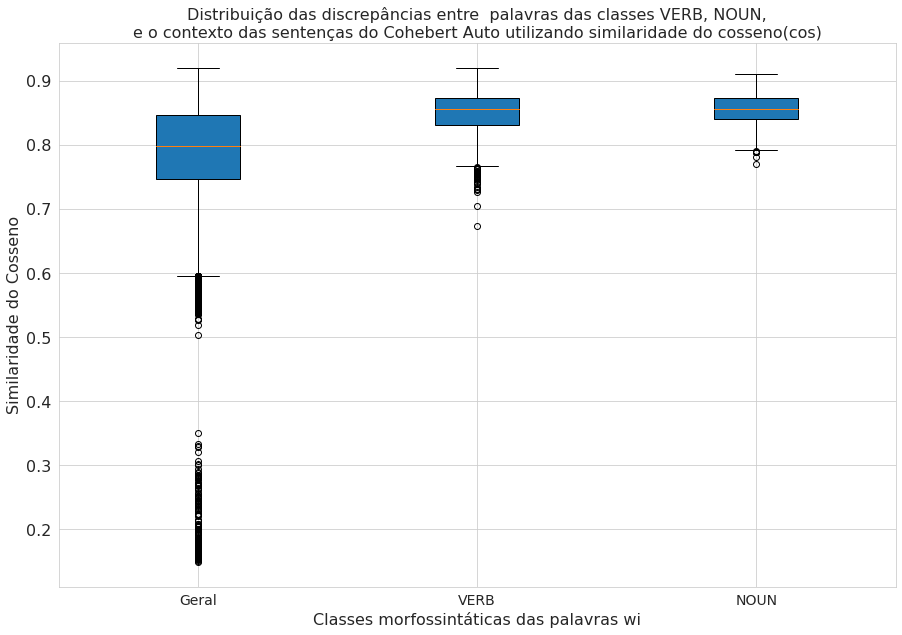

In [425]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxclean_mean"]], lista_comparacao_classesVV[["cos_ctxclean_mean"]], lista_comparacao_classesNN[["cos_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [426]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxclean_mean"]],
                    lista_comparacao_classesVV[["euc_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      euc_ctxclean_mean euc_ctxclean_mean euc_ctxclean_mean
count      21917.000000       2144.000000       5448.000000
mean          24.508816         22.526125         21.272765
std            3.950912          3.495565          2.235410
min           13.852946         13.852946         15.049208
25%           21.923750         20.187375         19.830615
50%           24.169489         22.187858         21.061183
75%           26.465389         24.312386         22.580863
max           40.750187         38.754295         36.571972

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


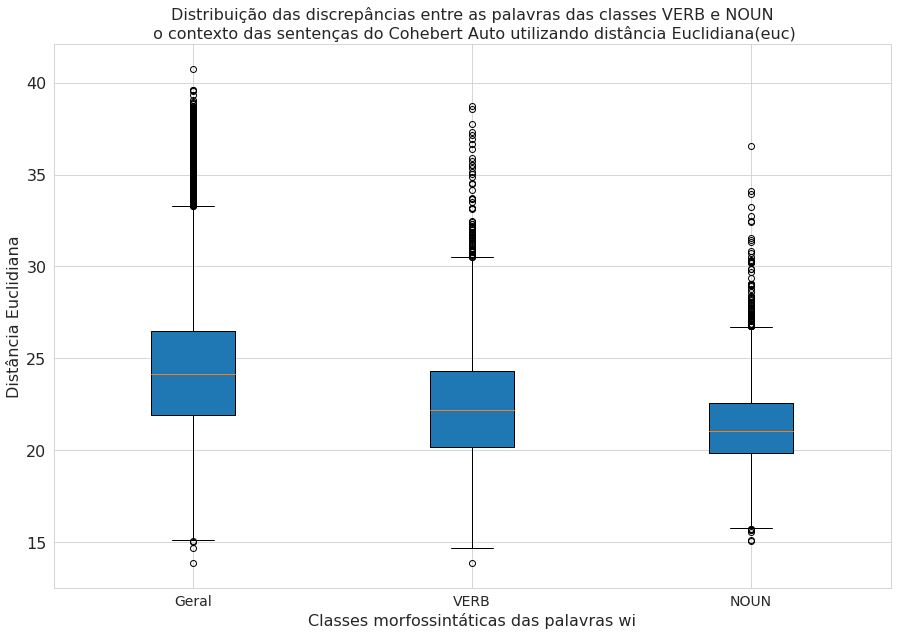

In [427]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxclean_mean"]], lista_comparacao_classesVV[["euc_ctxclean_mean"]], lista_comparacao_classesNN[["euc_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [428]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["man_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      man_ctxclean_mean man_ctxclean_mean man_ctxclean_mean
count      21917.000000       2144.000000       5448.000000
mean        1164.545709       1063.668614       1001.547106
std          173.018815        145.843331         93.305269
min          672.883540        672.883540        738.976900
25%         1048.667400        962.018405        934.978178
50%         1162.582300       1056.647200        993.900520
75%         1261.822000       1154.902675       1070.345025
max         1774.981800       1631.399000       1448.290200

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


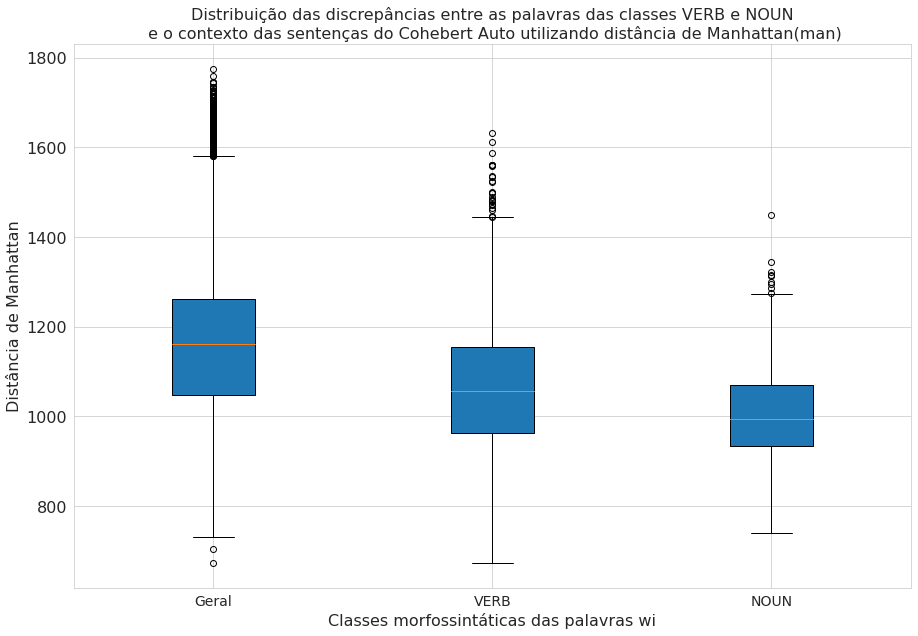

In [429]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxclean_mean"]], lista_comparacao_classesVV[["man_ctxclean_mean"]], lista_comparacao_classesNN[["man_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

#### VERB

In [430]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [431]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2144


Estatísticas das medidas dos contextos e palavras

In [432]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean", "euc_ctxverb_mean",
                          "man_ctxverb_mean", "cos_ctxverb_max",
                          "euc_ctxverb_max",  "man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count       2144.000000       2144.000000       2144.000000      2144.000000   
mean           0.922090         13.821816        638.263957         0.889953   
std            0.057597          9.047782        414.613239         0.098299   
min            0.769599          0.000000          0.000000         0.616185   
25%            0.886702          0.000000          0.000000         0.820024   
50%            0.910614         17.892559        837.096191         0.906095   
75%            1.000000         20.159017        919.855011         1.000000   
max            1.000000         30.264620       1350.928711         1.000000   

       euc_ctxverb_max  man_ctxverb_max  
count      2144.000000      2144.000000  
mean         16.357635       767.257342  
std          10.845653       514.728254  
min           0.000000         0.000000  
25%           0.000000         0.000000  
50%          19.186313       877.542206  
75%          24.942219      1180.061279  
max          35.630196      1652.410522

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [433]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2144 [00:00<?, ? documento/s]

In [434]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [435]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  850
      2        1  591
      3        6  310
      4        2  168
      5        3  114
      6        8  111


##### COS - MEAN

In [436]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [437]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.1132979542016983
Limite superior             : 1.1699469313025475
Limite inferior             : 0.7167551144957542


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [438]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [439]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [440]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2144 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [441]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [442]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [443]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [444]:
medida = "cos_ctxverb_max"

Documentos outliers

In [445]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.17997585237026215
Limite superior             : 1.2699637785553932
Limite inferior             : 0.5500603690743446


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [446]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [447]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [448]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2144 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [449]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [450]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [451]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [452]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [453]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 20.15901708602905
Limite superior             : 50.39754271507262
Limite inferior             : -30.238525629043572


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [454]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [455]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [456]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2144 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [457]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [458]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [459]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [460]:
medida = "euc_ctxverb_max"

Documentos outliers

In [461]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 24.942218780517578
Limite superior             : 62.355546951293945
Limite inferior             : -37.41332817077637


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [462]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [463]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [464]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2144 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [465]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [466]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [467]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [468]:
medida = "man_ctxverb_mean"

Documentos outliers

In [469]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 919.855010986328
Limite superior             : 2299.63752746582
Limite inferior             : -1379.782516479492


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [470]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [471]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [472]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2144 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [473]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [474]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [475]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [476]:
medida = "man_ctxverb_max"

Documentos outliers

In [477]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 1180.061279296875
Limite superior             : 2950.1531982421875
Limite inferior             : -1770.0919189453125


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [478]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [479]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [480]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2144 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [481]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [482]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [483]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [484]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [485]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5448


Estatísticas das medidas dos contextos e palavras

In [486]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean","euc_ctxverb_mean",
                          "man_ctxverb_mean","cos_ctxverb_max",
                          "euc_ctxverb_max","man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count       4767.000000       4767.000000       4767.000000      4767.000000   
mean           0.677232         32.559816       1538.433868         0.659414   
std            0.055722          3.703687        160.580224         0.059871   
min            0.477852         22.345469       1084.597900         0.477852   
25%            0.647480         30.169966       1434.045715         0.623129   
50%            0.681817         32.274189       1527.980103         0.663619   
75%            0.719156         34.690399       1635.203857         0.702420   
max            0.811667         52.019901       2125.240234         0.811667   

       euc_ctxverb_max  man_ctxverb_max  
count      4767.000000      4767.000000  
mean         33.717717      1595.195052  
std           3.470313       158.297737  
min          25.471758      1190.834961  
25%          31.477604      1484.276001  
50%          33.121807      1573.610596  
75%          35.755278      1695.030212  
max          52.019901      2139.425293

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [487]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5448 [00:00<?, ? documento/s]

In [488]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [489]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1010
      3        2  812
      4        5  606
      5        7  408
      6       10  303
      7        1  203
      8       11  202
      9       12  202
     10        8  106
     11        6   94
     12        3   88


##### COS - MEAN

In [490]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [491]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [492]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5448 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [493]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [494]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5448 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [495]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [496]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [497]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [498]:
medida = "cos_ctxverb_max"

Documentos outliers

In [499]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [500]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5448 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [501]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [502]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5448 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [503]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [504]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [505]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [506]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [507]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [508]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [509]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [510]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5448 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [511]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [512]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [513]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [514]:
medida = "euc_ctxverb_max"

Documentos outliers

In [515]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [516]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [517]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [518]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5448 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [519]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [520]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [521]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [522]:
medida = "man_ctxverb_mean"

Documentos outliers

In [523]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [524]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [525]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [526]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5448 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [527]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [528]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [529]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [530]:
medida = "man_ctxverb_max"

Documentos outliers

In [531]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [532]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [533]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [534]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 5448 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [535]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [536]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [537]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### Comparando discrepância entre o contexto de palavras da classe VERB e palavras de todas classes, VERB e NOUN.

##### COS, EUC, MAN

In [538]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean","euc_ctxverb_mean",
                                               "man_ctxverb_mean","cos_ctxverb_max",
                                               "euc_ctxverb_max","man_ctxverb_max"]],
                    lista_comparacao_classesVV[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count     20260.000000     20260.000000     20260.000000    20260.000000   
mean          0.716222        28.654743      1368.530809        0.706511   
std           0.116708         7.779623       367.829589        0.116754   
min           0.111985         0.000000         0.000000        0.111985   
25%           0.659953        26.810721      1306.021667        0.648525   
50%           0.707905        29.628299      1432.814697        0.701385   
75%           0.748918        33.113129      1573.336273        0.742697   
max           1.000000        52.019901      2212.333984        1.000000   

                                                  VERB                   \
      euc_ctxverb_max man_ctxverb_max cos_ctxverb_mean euc_ctxverb_mean   
count    20260.000000    20260.000000      2144.000000      2144.000000   
mean        29.340243     1403.018841         0.922090        13.821816   
std          7.696245      364.531035         0.057597         9.047782   
min          0.000000        0.000000         0.769599         0.000000   
25%         27.310514     1334.111420         0.886702         0.000000   
50%         30.216292     1452.581909         0.910614        17.892559   
75%         33.744778     1607.875732         1.000000        20.159017   
max         52.019901     2212.333984         1.000000        30.264620   

                                                                        \
      man_ctxverb_mean cos_ctxverb_max euc_ctxverb_max man_ctxverb_max   
count      2144.000000     2144.000000     2144.000000     2144.000000   
mean        638.263957        0.889953       16.357635      767.257342   
std         414.613239        0.098299       10.845653      514.728254   
min           0.000000        0.616185        0.000000        0.000000   
25%           0.000000        0.820024        0.000000        0.000000   
50%         837.096191        0.906095       19.186313      877.542206   
75%         919.855011        1.000000       24.942219     1180.061279   
max        1350.928711        1.000000       35.630196     1652.410522   

                  NOUN                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count      4767.000000      4767.000000      4767.000000     4767.000000   
mean          0.677232        32.559816      1538.433868        0.659414   
std           0.055722         3.703687       160.580224        0.059871   
min           0.477852        22.345469      1084.597900        0.477852   
25%           0.647480        30.169966      1434.045715        0.623129   
50%           0.681817        32.274189      1527.980103        0.663619   
75%           0.719156        34.690399      1635.203857        0.702420   
max           0.811667        52.019901      2125.240234        0.811667   

                                       
      euc_ctxverb_max man_ctxverb_max  
count     4767.000000     4767.000000  
mean        33.717717     1595.195052  
std          3.470313      158.297737  
min         25.471758     1190.834961  
25%         31.477604     1484.276001  
50%         33.121807     1573.610596  
75%         35.755278     1695.030212  
max         52.019901     2139.425293

##### COS

In [539]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxverb_mean cos_ctxverb_mean cos_ctxverb_mean
count     20260.000000      2144.000000      4767.000000
mean          0.716222         0.922090         0.677232
std           0.116708         0.057597         0.055722
min           0.111985         0.769599         0.477852
25%           0.659953         0.886702         0.647480
50%           0.707905         0.910614         0.681817
75%           0.748918         1.000000         0.719156
max           1.000000         1.000000         0.811667

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


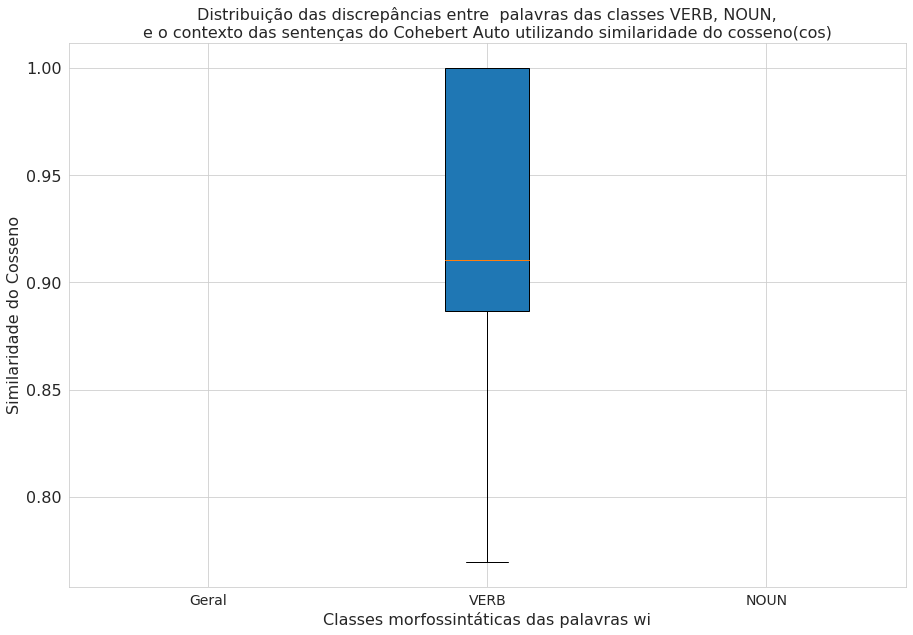

In [540]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverb_mean"]], lista_comparacao_classesVV[["cos_ctxverb_mean"]], lista_comparacao_classesNN[["cos_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [541]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverb_mean"]],
                    lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxverb_mean euc_ctxverb_mean euc_ctxverb_mean
count     20260.000000      2144.000000      4767.000000
mean         28.654743        13.821816        32.559816
std           7.779623         9.047782         3.703687
min           0.000000         0.000000        22.345469
25%          26.810721         0.000000        30.169966
50%          29.628299        17.892559        32.274189
75%          33.113129        20.159017        34.690399
max          52.019901        30.264620        52.019901

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


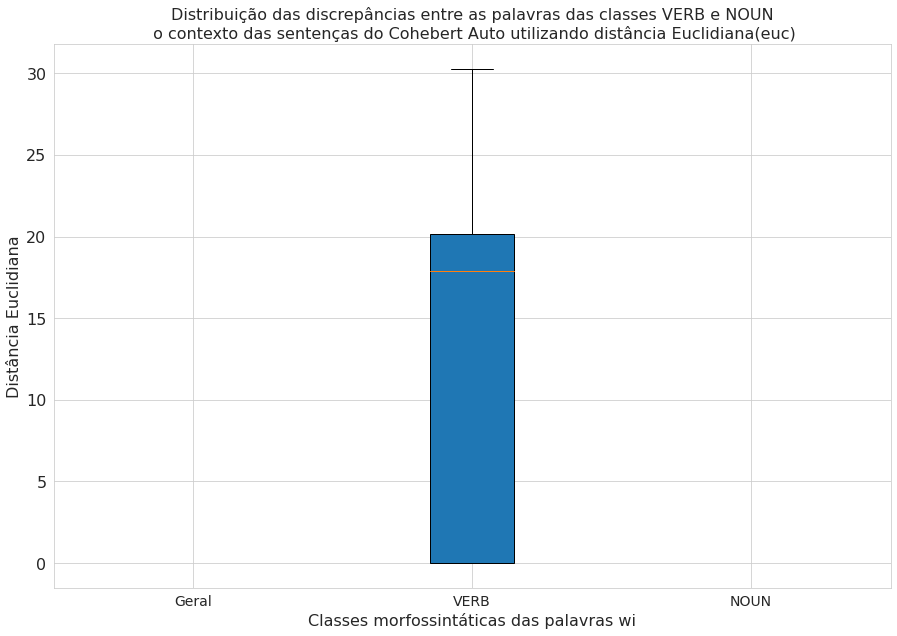

In [542]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverb_mean"]], 
           lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
           lista_comparacao_classesNN[["euc_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [543]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverb_mean"]],
                    lista_comparacao_classesVV[["man_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["man_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxverb_mean man_ctxverb_mean man_ctxverb_mean
count     20260.000000      2144.000000      4767.000000
mean       1368.530809       638.263957      1538.433868
std         367.829589       414.613239       160.580224
min           0.000000         0.000000      1084.597900
25%        1306.021667         0.000000      1434.045715
50%        1432.814697       837.096191      1527.980103
75%        1573.336273       919.855011      1635.203857
max        2212.333984      1350.928711      2125.240234

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


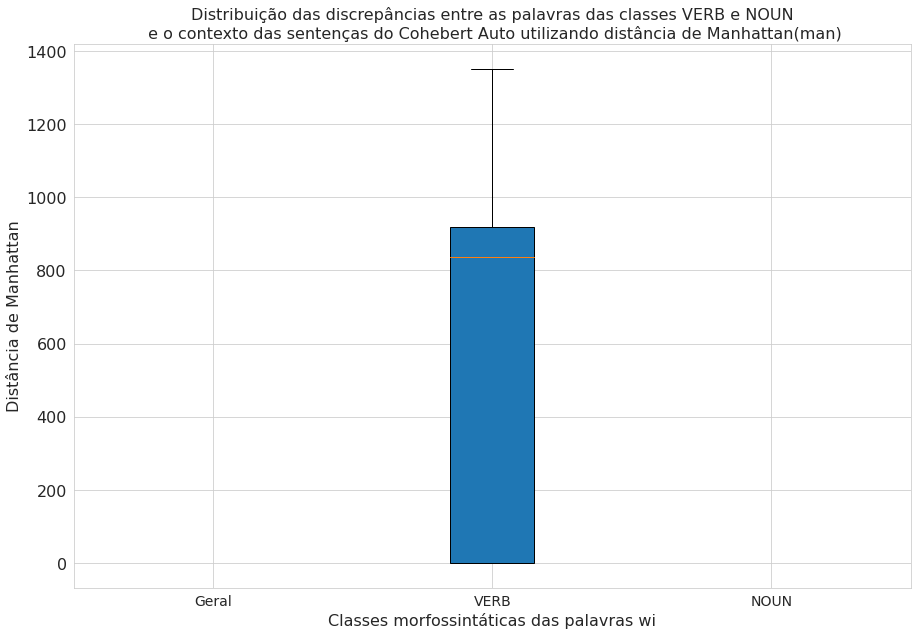

In [544]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverb_mean"]], 
           lista_comparacao_classesVV[["man_ctxverb_mean"]], 
           lista_comparacao_classesNN[["man_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

#### VERB

In [545]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [546]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2144


Estatísticas das medidas dos contextos e palavras

In [547]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean",
                          "man_ctxnoun_mean","cos_ctxnoun_max",
                          "euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count       2144.000000       2144.000000       2144.000000      2144.000000   
mean           0.739556         29.225392       1381.288009         0.710408   
std            0.035111          3.369894        146.540174         0.062677   
min            0.613015         18.897543        897.340000         0.529881   
25%            0.715172         27.343770       1287.425325         0.687947   
50%            0.738865         29.220962       1394.181900         0.727708   
75%            0.763492         30.941974       1471.461000         0.754555   
max            0.845182         45.103558       1822.874300         0.834443   

       euc_ctxnoun_max  man_ctxnoun_max  
count      2144.000000      2144.000000  
mean         31.145475      1475.511205  
std           3.342599       138.155712  
min          22.833176      1088.467200  
25%          28.846178      1380.218500  
50%          30.390471      1450.724900  
75%          32.997500      1566.909025  
max          45.103558      1822.874300

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [548]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2144 [00:00<?, ? documento/s]

In [549]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [550]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  850
      2        1  591
      3        6  310
      4        2  168
      5        3  114
      6        8  111


##### COS - MEAN

In [551]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [552]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.04831969738006592
Limite superior             : 0.8359716981649399
Limite inferior             : 0.6426929086446762


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [553]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 2144 ( 0.0004664179104477612 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [554]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 4 de 2144 ( 0.0018656716417910447 )


In [555]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  5 de 2144 ( 0.0023320895522388058 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [556]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.8451824188232422 empilhar
         O que é uma fila e como empilhar e desempilhar seus elementos?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [557]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6130152344703674 implementadas
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 2 0.6316013336181641 fechar
         Como são implementadas as operações de empilhar e fechar elementos em uma fila ?

 3 0.6337500810623169 chamadas
         Como são chamadas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 4 0.6411425471305847 mover
         Como mover e desempilhar elementos em uma estrutura de dados fila ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [558]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como mover e desempilhar elementos em uma estrutura de dados fila ?
       1 0.7435706257820129 desempilhar
       2 0.6411425471305847 mover

 2 Como são chamadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 0.7123904824256897 enfileirar
       2 0.6337500810623169 chamadas

 3 Como são implementadas as operações de empilhar e fechar elementos em uma fila ?
       1 0.8029941916465759 empilhar
       2 0.6784974932670593 implementadas
       3 0.6316013336181641 fechar

 4 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 0.7928672432899475 empilhar
       2 0.6130152344703674 implementadas


##### COS - MAX

In [559]:
medida = "cos_ctxnoun_max"

Documentos outliers

In [560]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06660756468772888
Limite superior             : 0.8544662594795227
Limite inferior             : 0.5880360007286072


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [561]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [562]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 196 de 2144 ( 0.0914179104477612 )


In [563]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  196 de 2144 ( 0.0914179104477612 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [564]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [565]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5298805832862854 enfileirar
         Em uma pilha a operação de enfileirar , em qual extremidade ?

 2 0.5368154048919678 enfileirar
         Em uma pilha a operação de enfileirar ou em qual extremidade ?

 3 0.5375494360923767 enfileirar
         Em uma pilha a operação de enfileirar : em qual extremidade ?

 4 0.5382916331291199 enfileirar
         O que é uma pilha e como enfileirar e desenfileirar seus elementos?

 5 0.539173424243927 enfileirar
         Em uma pilha a operação de enfileirar e em qual extremidade ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [566]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são simples as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 0.5878919363021851 enfileirar

 2 Como são tomadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 0.731554388999939 tomadas
       2 0.587698221206665 enfileirar

 3 Em uma pilha a operação de enfileirar funcionar em qual extremidade ?
       1 0.7772989273071289 funcionar
       2 0.586437463760376 enfileirar

 4 Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?
       1 0.7217079997062683 Ocorre
       2 0.5860809087753296 enfileirar

 5 Como são responsáveis as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 0.585321843624115 enfileirar


##### EUC - MEAN

In [567]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [568]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.598204135894779
Limite superior             : 36.33927989006043
Limite inferior             : 21.946463346481316


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [569]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 60 de 2144 ( 0.027985074626865673 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [570]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 74 de 2144 ( 0.03451492537313433 )


In [571]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  134 de 2144 ( 0.0625 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [572]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 45.10355758666992 Ocorre
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?

 2 44.09299850463867 acontecem
         Em uma pilha a operação de enfileirar acontecem em qual extremidade ?

 3 43.88446044921875 ocorrem
         Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?

 4 43.55878829956055 ocorrer
         Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?

 5 42.98821640014648 disputadas
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [573]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 18.89754295349121 empilhar
         O que é uma fila e como empilhar e desempilhar seus elementos?

 2 20.701513290405277 empilhar
         Como são implementadas as operações de empilhar e unir elementos em uma fila ?

 3 20.739208221435547 empilhar
         Como são implementadas as operações de empilhar e formar elementos em uma fila ?

 4 20.909297943115234 empilhar
         Como são implementadas as operações de empilhar e juntar elementos em uma fila ?

 5 20.946001052856445 empilhar
         Como são implementadas as operações de empilhar e colocar elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [574]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?
       1 45.10355758666992 Ocorre
       2 26.747722625732425 enfileirar

 2 Em uma pilha a operação de enfileirar acontecem em qual extremidade ?
       1 44.09299850463867 acontecem
       2 27.383935928344727 enfileirar

 3 Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?
       1 43.88446044921875 ocorrem
       2 26.96395301818848 enfileirar

 4 Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?
       1 43.55878829956055 ocorrer
       2 26.323978424072266 enfileirar

 5 Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 42.98821640014648 disputadas
       2 26.250186920166016 enfileirar


##### EUC - MAX

In [575]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [576]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.151322364807129
Limite superior             : 39.22448396682739
Limite inferior             : 22.619194507598877


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [577]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 24 de 2144 ( 0.011194029850746268 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [578]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [579]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  24 de 2144 ( 0.011194029850746268 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [580]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 45.10355758666992 Ocorre
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?

 2 44.09299850463867 acontecem
         Em uma pilha a operação de enfileirar acontecem em qual extremidade ?

 3 43.88446044921875 ocorrem
         Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?

 4 43.55878829956055 ocorrer
         Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?

 5 42.98821640014648 disputadas
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [581]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [582]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?
       1 45.10355758666992 Ocorre
       2 35.33437728881836 enfileirar

 2 Em uma pilha a operação de enfileirar acontecem em qual extremidade ?
       1 44.09299850463867 acontecem
       2 36.01054382324219 enfileirar

 3 Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?
       1 43.88446044921875 ocorrem
       2 35.61689758300781 enfileirar

 4 Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?
       1 43.55878829956055 ocorrer
       2 35.48598861694336 enfileirar

 5 Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 42.98821640014648 disputadas
       2 35.47267532348633 enfileirar


##### MAN - MEAN

In [583]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [584]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 184.03567500000008
Limite superior             : 1747.5145125000001
Limite inferior             : 1011.3718124999998


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [585]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 15 de 2144 ( 0.006996268656716418 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [586]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 13 de 2144 ( 0.006063432835820896 )


In [587]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  28 de 2144 ( 0.013059701492537313 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [588]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1822.8743 feito
         Como são feito as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 1802.9758 realizado
         Como são realizado as operações de enfileirar e desenfileirar elementos em uma pilha ?

 3 1802.6167 dados
         Como são dados as operações de enfileirar e desenfileirar elementos em uma pilha ?

 4 1780.9625 enviadas
         Como são enviadas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 5 1779.4834 disputadas
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [589]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 897.34 empilhar
         O que é uma fila e como empilhar e desempilhar seus elementos?

 2 990.8674 empilhar
         Como são implementadas as operações de empilhar e unir elementos em uma fila ?

 3 991.03186 empilhar
         Como são implementadas as operações de empilhar e formar elementos em uma fila ?

 4 998.3501 empilhar
         Como são implementadas as operações de empilhar e juntar elementos em uma fila ?

 5 998.7632 empilhar
         Como são implementadas as operações de empilhar e colocar elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [590]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são feito as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1822.8743 feito
       2 1209.7131 enfileirar

 2 Como são realizado as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1802.9758 realizado
       2 1204.0138 enfileirar

 3 Como são dados as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1802.6167 dados
       2 1202.0999 enfileirar

 4 Como são enviadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1780.9625 enviadas
       2 1203.687 enfileirar

 5 Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1779.4834 disputadas
       2 1198.0793 enfileirar


##### MAN - MAX

In [591]:
medida = "man_ctxnoun_max"

Documentos outliers

In [592]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 186.69052499999998
Limite superior             : 1846.9448125
Limite inferior             : 1100.1827125


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [593]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [594]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 2 de 2144 ( 0.0009328358208955224 )


In [595]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  2 de 2144 ( 0.0009328358208955224 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [596]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [597]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1088.4672 carregar
         Como carregar elementos em uma pilha ?

 2 1088.4672 carregar
         Como carregar elementos em uma pilha ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [598]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [599]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [600]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5448


Estatísticas das medidas dos contextos e palavras

In [601]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count       5448.000000       5448.000000       5448.000000      5448.000000   
mean           0.892781         18.450445        862.337566         0.869404   
std            0.027131          2.051957         95.357200         0.059707   
min            0.775607         12.678499        579.876200         0.646790   
25%            0.872986         16.901102        787.393862         0.831491   
50%            0.891997         18.505751        867.728170         0.888337   
75%            0.914176         19.825823        933.911530         0.914166   
max            0.954686         29.895227       1299.002900         0.954686   

       euc_ctxnoun_max  man_ctxnoun_max  
count      5448.000000      5448.000000  
mean         20.249109       955.770261  
std           3.798347       194.537736  
min          12.678499       579.876200  
25%          17.208298       802.184450  
50%          19.577990       925.166030  
75%          22.695449      1067.793350  
max          33.306309      1654.907500

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [602]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5448 [00:00<?, ? documento/s]

In [603]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [604]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1010
      3        2  812
      4        5  606
      5        7  408
      6       10  303
      7        1  203
      8       11  202
      9       12  202
     10        8  106
     11        6   94
     12        3   88


##### COS - MEAN

In [605]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [606]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0411900132894516
Limite superior             : 0.9759610816836357
Limite inferior             : 0.8112010285258293


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [607]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5448 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [608]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 4 de 5448 ( 0.0007342143906020558 )


In [609]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4 de 5448 ( 0.0007342143906020558 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [610]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [611]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7756072282791138 fila
         Como inser elementos em uma fila ?

 2 0.7964233160018921 operações
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 3 0.8044519424438477 fila
         Como se elementos em uma fila ?

 4 0.8094388842582703 fila
         Como ficar elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [612]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficar elementos em uma fila ?
       1 0.9424395561218262 elementos
       2 0.8094388842582703 fila

 2 Como se elementos em uma fila ?
       1 0.938964307308197 elementos
       2 0.8044519424438477 fila

 3 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 0.8987908959388733 elementos
       2 0.8293616771697998 fila
       3 0.7964233160018921 operações

 4 Como inser elementos em uma fila ?
       1 0.9284541010856628 elementos
       2 0.9154463410377502 inser
       3 0.7756072282791138 fila


##### COS - MAX

In [613]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [614]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0411900132894516
Limite superior             : 0.9759610816836357
Limite inferior             : 0.8112010285258293


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [615]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5448 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [616]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 4 de 5448 ( 0.0007342143906020558 )


In [617]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4 de 5448 ( 0.0007342143906020558 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [618]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [619]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7756072282791138 fila
         Como inser elementos em uma fila ?

 2 0.7964233160018921 operações
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 3 0.8044519424438477 fila
         Como se elementos em uma fila ?

 4 0.8094388842582703 fila
         Como ficar elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [620]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como ficar elementos em uma fila ?
       1 0.9424395561218262 elementos
       2 0.8094388842582703 fila

 2 Como se elementos em uma fila ?
       1 0.938964307308197 elementos
       2 0.8044519424438477 fila

 3 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 0.8987908959388733 elementos
       2 0.8293616771697998 fila
       3 0.7964233160018921 operações

 4 Como inser elementos em uma fila ?
       1 0.9284541010856628 elementos
       2 0.9154463410377502 inser
       3 0.7756072282791138 fila


##### EUC - MEAN

In [621]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [622]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 2.924721240997318
Limite superior             : 24.212904691696174
Limite inferior             : 12.514019727706904


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [623]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 39


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [624]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [625]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  39 de 5448 ( 0.007158590308370044 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [626]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 29.895227432250977 elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 2 29.321781158447266 etapas
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 3 26.79291534423828 ajuda
         Em uma pilha a operação de enfileirar ajuda em qual extremidade ?

 4 26.692293167114254 fila
         Como inser elementos em uma fila ?

 5 26.36611557006836 coordenadas
         Como são coordenadas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [627]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [628]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 29.895227432250977 elementos
       2 24.527286529541016 operações
       3 21.65053367614746 fila

 2 Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 29.321781158447266 etapas
       2 23.297212600708008 pilha
       3 22.537294387817383 elementos
       4 22.43903923034668 operações

 3 Em uma pilha a operação de enfileirar ajuda em qual extremidade ?
       1 26.79291534423828 ajuda
       2 21.30377769470215 pilha
       3 21.25645637512207 operação
       4 21.19536781311035 extremidade

 4 Como inser elementos em uma fila ?
       1 26.692293167114254 fila
       2 23.79884529113769 elementos
       3 20.702436447143555 inser

 5 Como são coordenadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 26.36611557006836 coordenadas
       2 22.330402374267575 pilha
       3 22.1042594909668 elementos
       4 21.63650703430

##### EUC - MAX

In [629]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [630]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.4871506690979
Limite superior             : 30.926174879074097
Limite inferior             : 8.977572202682495


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [631]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 44


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [632]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [633]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  44 de 5448 ( 0.008076358296622614 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [634]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 33.30630874633789 desempilhar
         Como remover e desempilhar elementos em uma estrutura de dados fila ?

 2 33.04709243774414 desempilhar
         Como trazer e desempilhar elementos em uma estrutura de dados fila ?

 3 32.890262603759766 desempilhar
         Como introduzir e desempilhar elementos em uma estrutura de dados fila ?

 4 32.797298431396484 desempilhar
         Como detectar e desempilhar elementos em uma estrutura de dados fila ?

 5 32.736228942871094 desempilhar
         Como alterar e desempilhar elementos em uma estrutura de dados fila ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [635]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [636]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como remover e desempilhar elementos em uma estrutura de dados fila ?
       1 33.30630874633789 desempilhar
       2 24.762012481689453 fila
       3 21.169893264770508 elementos
       4 20.041601181030277 estrutura
       5 19.9336051940918 dados

 2 Como trazer e desempilhar elementos em uma estrutura de dados fila ?
       1 33.04709243774414 desempilhar
       2 24.980939865112305 fila
       3 20.74848747253418 estrutura
       4 20.23675346374512 elementos
       5 20.196924209594727 dados

 3 Como introduzir e desempilhar elementos em uma estrutura de dados fila ?
       1 32.890262603759766 desempilhar
       2 24.88658332824707 fila
       3 20.499897003173828 elementos
       4 20.395923614501957 estrutura
       5 20.210947036743164 dados

 4 Como detectar e desempilhar elementos em uma estrutura de dados fila ?
       1 32.797298431396484 desempilhar
       2 24.60381507873535 fila
       3 20.78792381286621 elementos
       4 20.26102828979492 estrutura
       5 20.2

##### MAN - MEAN

In [637]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [638]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 146.51766750000002
Limite superior             : 1153.68803125
Limite inferior             : 567.6173612499999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [639]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 8


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [640]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [641]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  8 de 5448 ( 0.0014684287812041115 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [642]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1299.0029 etapas
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 1209.5674 coordenadas
         Como são coordenadas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 3 1181.2112 elementos
         Como são elementos em uma estrutura de dados fila ?

 4 1175.936 ajuda
         Em uma pilha a operação de enfileirar ajuda em qual extremidade ?

 5 1171.3538 medidas
         Como são medidas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [643]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [644]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1299.0029 etapas
       2 1114.4785 pilha
       3 1087.9646 elementos
       4 1031.2864 operações

 2 Como são coordenadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1209.5674 coordenadas
       2 1059.721 pilha
       3 1057.8335 elementos
       4 990.0299 operações

 3 Como são elementos em uma estrutura de dados fila ?
       1 1181.2112 elementos
       2 914.7245 estrutura
       3 897.4255 dados
       4 873.02264 fila

 4 Em uma pilha a operação de enfileirar ajuda em qual extremidade ?
       1 1175.936 ajuda
       2 1045.2122 operação
       3 1010.6006 extremidade
       4 982.6406 pilha

 5 Como são medidas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1171.3538 medidas
       2 1064.763 pilha
       3 1060.6235 elementos
       4 1004.08075 operações


##### MAN - MAX

In [645]:
medida = "man_ctxnoun_max"

Documentos outliers

In [646]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 265.6089000000002
Limite superior             : 1466.2067000000004
Limite inferior             : 403.7710999999997


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [647]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 127


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [648]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [649]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  127 de 5448 ( 0.023311306901615272 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [650]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1654.9075 desempilhar
         Como remover e desempilhar elementos em uma estrutura de dados fila ?

 2 1650.9768 desempilhar
         Como trazer e desempilhar elementos em uma estrutura de dados fila ?

 3 1638.8276 desempilhar
         Como introduzir e desempilhar elementos em uma estrutura de dados fila ?

 4 1634.5647 desempilhar
         Como esconder e desempilhar elementos em uma estrutura de dados fila ?

 5 1632.5906 desempilhar
         Como alterar e desempilhar elementos em uma estrutura de dados fila ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [651]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [652]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como remover e desempilhar elementos em uma estrutura de dados fila ?
       1 1654.9075 desempilhar
       2 1211.5537 fila
       3 1028.0598 elementos
       4 952.7805 estrutura
       5 951.7932 dados

 2 Como trazer e desempilhar elementos em uma estrutura de dados fila ?
       1 1650.9768 desempilhar
       2 1228.008 fila
       3 984.1443 elementos
       4 979.02704 estrutura
       5 976.9054 dados

 3 Como introduzir e desempilhar elementos em uma estrutura de dados fila ?
       1 1638.8276 desempilhar
       2 1222.5466 fila
       3 993.21564 elementos
       4 973.4258 dados
       5 961.279 estrutura

 4 Como esconder e desempilhar elementos em uma estrutura de dados fila ?
       1 1634.5647 desempilhar
       2 1255.0737 fila
       3 980.6105 dados
       4 970.59753 elementos
       5 969.7564 estrutura

 5 Como alterar e desempilhar elementos em uma estrutura de dados fila ?
       1 1632.5906 desempilhar
       2 1226.9675 fila
       3 982.99475 elementos
 

#### Comparando discrepância entre o contexto de palavras NOUN e palavras de todas classes, VERB e NOUN

##### COS, EUC, MAN

In [653]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    lista_comparacao_classesVV[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count     21917.000000     21917.000000     21917.000000    21917.000000   
mean          0.731083        27.473874      1297.556999        0.720316   
std           0.126737         6.379998       298.229059        0.124618   
min           0.133210        12.678499       579.876200        0.133210   
25%           0.655244        22.785503      1079.180300        0.643841   
50%           0.727786        28.383099      1342.104200        0.719429   
75%           0.827704        31.896654      1513.133300        0.795506   
max           0.954686        45.103558      1993.807400        0.954686   

                                                  VERB                   \
      euc_ctxnoun_max man_ctxnoun_max cos_ctxnoun_mean euc_ctxnoun_mean   
count    21917.000000    21917.000000      2144.000000      2144.000000   
mean        28.246557     1337.149346         0.739556        29.225392   
std          6.131016      285.746808         0.035111         3.369894   
min         12.678499      579.876200         0.613015        18.897543   
25%         24.601370     1188.576400         0.715172        27.343770   
50%         28.989351     1379.813500         0.738865        29.220962   
75%         32.439251     1546.001000         0.763492        30.941974   
max         45.103558     1993.807400         0.845182        45.103558   

                                                                        \
      man_ctxnoun_mean cos_ctxnoun_max euc_ctxnoun_max man_ctxnoun_max   
count      2144.000000     2144.000000     2144.000000     2144.000000   
mean       1381.288009        0.710408       31.145475     1475.511205   
std         146.540174        0.062677        3.342599      138.155712   
min         897.340000        0.529881       22.833176     1088.467200   
25%        1287.425325        0.687947       28.846178     1380.218500   
50%        1394.181900        0.727708       30.390471     1450.724900   
75%        1471.461000        0.754555       32.997500     1566.909025   
max        1822.874300        0.834443       45.103558     1822.874300   

                  NOUN                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count      5448.000000      5448.000000      5448.000000     5448.000000   
mean          0.892781        18.450445       862.337566        0.869404   
std           0.027131         2.051957        95.357200        0.059707   
min           0.775607        12.678499       579.876200        0.646790   
25%           0.872986        16.901102       787.393862        0.831491   
50%           0.891997        18.505751       867.728170        0.888337   
75%           0.914176        19.825823       933.911530        0.914166   
max           0.954686        29.895227      1299.002900        0.954686   

                                       
      euc_ctxnoun_max man_ctxnoun_max  
count     5448.000000     5448.000000  
mean        20.249109      955.770261  
std          3.798347      194.537736  
min         12.678499      579.876200  
25%         17.208298      802.184450  
50%         19.577990      925.166030  
75%         22.695449     1067.793350  
max         33.306309     1654.907500

##### COS

In [654]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxnoun_mean cos_ctxnoun_mean cos_ctxnoun_mean
count     21917.000000      2144.000000      5448.000000
mean          0.731083         0.739556         0.892781
std           0.126737         0.035111         0.027131
min           0.133210         0.613015         0.775607
25%           0.655244         0.715172         0.872986
50%           0.727786         0.738865         0.891997
75%           0.827704         0.763492         0.914176
max           0.954686         0.845182         0.954686

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


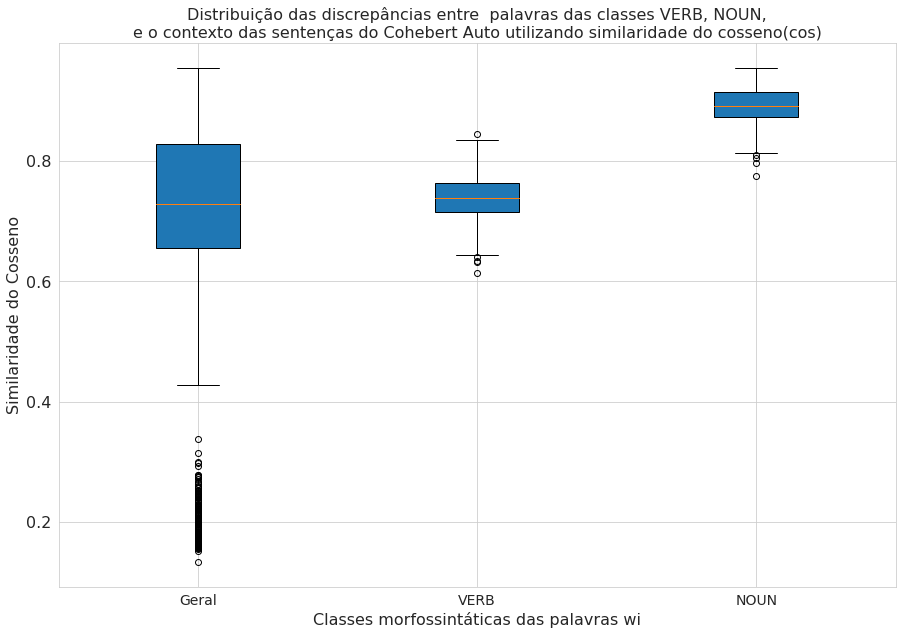

In [655]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do Cohebert Auto utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxnoun_mean"]], lista_comparacao_classesVV[["cos_ctxnoun_mean"]], lista_comparacao_classesNN[["cos_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [656]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["euc_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxnoun_mean euc_ctxnoun_mean euc_ctxnoun_mean
count     21917.000000      2144.000000      5448.000000
mean         27.473874        29.225392        18.450445
std           6.379998         3.369894         2.051957
min          12.678499        18.897543        12.678499
25%          22.785503        27.343770        16.901102
50%          28.383099        29.220962        18.505751
75%          31.896654        30.941974        19.825823
max          45.103558        45.103558        29.895227

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


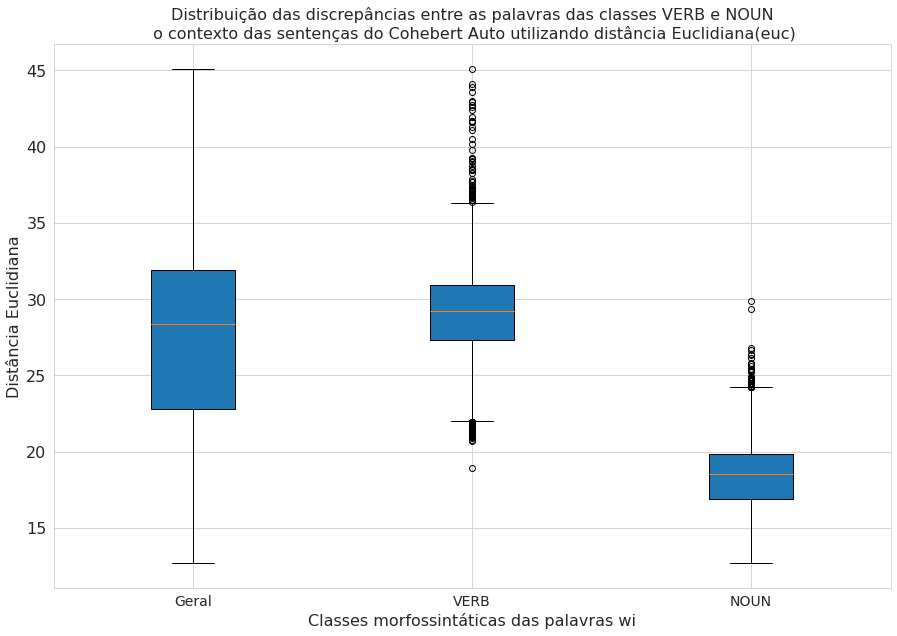

In [657]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do Cohebert Auto utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxnoun_mean"]], lista_comparacao_classesVV[["euc_ctxnoun_mean"]], lista_comparacao_classesNN[["euc_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [658]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["man_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["man_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxnoun_mean man_ctxnoun_mean man_ctxnoun_mean
count     21917.000000      2144.000000      5448.000000
mean       1297.556999      1381.288009       862.337566
std         298.229059       146.540174        95.357200
min         579.876200       897.340000       579.876200
25%        1079.180300      1287.425325       787.393862
50%        1342.104200      1394.181900       867.728170
75%        1513.133300      1471.461000       933.911530
max        1993.807400      1822.874300      1299.002900

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


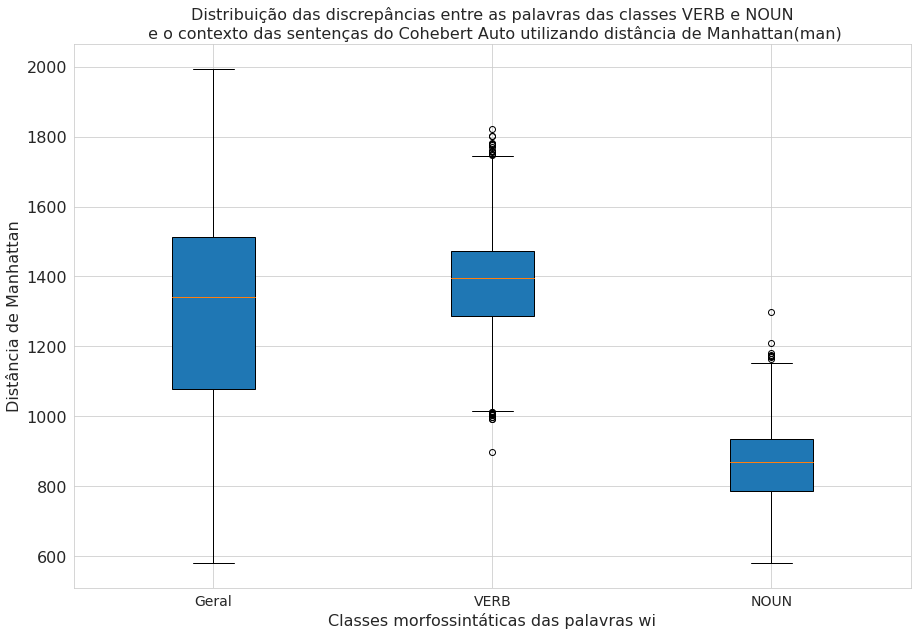

In [659]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do Cohebert Auto utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxnoun_mean"]], lista_comparacao_classesVV[["man_ctxnoun_mean"]], lista_comparacao_classesNN[["man_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### VERB

In [660]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [661]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 2144


Estatísticas das medidas dos contextos e palavras

In [662]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count           2144.000000           2144.000000           2144.000000   
mean               0.859241             21.817504           1025.778449   
std                0.032753              3.201940            132.949316   
min                0.748076             13.450162            655.001100   
25%                0.836825             19.476600            930.330340   
50%                0.867402             21.769080           1013.582780   
75%                0.884020             23.625577           1120.168650   
max                0.930165             36.040161           1447.413000   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count          2144.000000          2144.000000          2144.000000  
mean              0.827315            24.115476          1139.873823  
std               0.076691             4.356482           199.089943  
min               0.621991            15.222116           725.644800  
25%               0.784584            20.609271           977.540240  
50%               0.857979            23.542373          1115.809450  
75%               0.881735            26.720424          1267.413500  
max               0.930165            36.040161          1611.613300

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [663]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/2144 [00:00<?, ? documento/s]

In [664]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [665]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        7  850
      2        1  591
      3        6  310
      4        2  168
      5        3  114
      6        8  111


##### COS - MEAN

In [666]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [667]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.047194331884384155
Limite superior             : 0.9548110067844391
Limite inferior             : 0.7660336792469025


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [668]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [669]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 4 de 2144 ( 0.0018656716417910447 )


In [670]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4 de 2144 ( 0.0018656716417910447 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [671]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [672]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7480758428573608 fechar
         Como são implementadas as operações de empilhar e fechar elementos em uma fila ?

 2 0.7607141733169556 remover
         Como são implementadas as operações de empilhar e remover elementos em uma fila ?

 3 0.764380931854248 colar
         Como são implementadas as operações de empilhar e colar elementos em uma fila ?

 4 0.7651984095573425 pôr
         Como são implementadas as operações de empilhar e pôr elementos em uma fila ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [673]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e pôr elementos em uma fila ?
       1 0.8677727580070496 empilhar
       2 0.7998481392860413 implementadas
       3 0.7651984095573425 pôr

 2 Como são implementadas as operações de empilhar e colar elementos em uma fila ?
       1 0.8684818148612976 empilhar
       2 0.8090022206306458 implementadas
       3 0.764380931854248 colar

 3 Como são implementadas as operações de empilhar e remover elementos em uma fila ?
       1 0.8675590753555298 empilhar
       2 0.809472382068634 implementadas
       3 0.7607141733169556 remover

 4 Como são implementadas as operações de empilhar e fechar elementos em uma fila ?
       1 0.871510922908783 empilhar
       2 0.8049545288085938 implementadas
       3 0.7480758428573608 fechar


##### COS - MAX

In [674]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [675]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.09715168178081512
Limite superior             : 1.0274629965424538
Limite inferior             : 0.6388562694191933


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [676]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [677]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 27 de 2144 ( 0.012593283582089552 )


In [678]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  27 de 2144 ( 0.012593283582089552 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [679]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [680]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6219905614852905 enfileirar
         Como são realizar as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 0.6247681975364685 enfileirar
         Em uma pilha a operação de enfileirar pega em qual extremidade ?

 3 0.6270738840103149 enfileirar
         Em uma pilha a operação de enfileirar , em qual extremidade ?

 4 0.6274898648262024 enfileirar
         Como são fazer as operações de enfileirar e desenfileirar elementos em uma pilha ?

 5 0.628339946269989 enfileirar
         Como são denominadas as operações de enfileirar e desenfileirar elementos em uma pilha ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [681]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar age em qual extremidade ?
       1 0.8790163397789001 age
       2 0.63883376121521 enfileirar

 2 Como são atribuídas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 0.8355347514152527 atribuídas
       2 0.638495683670044 enfileirar

 3 Em uma pilha a operação de enfileirar falha em qual extremidade ?
       1 0.6382542252540588 enfileirar

 4 Em uma pilha a operação de enfileirar sai em qual extremidade ?
       1 0.8814855217933655 sai
       2 0.6381110548973083 enfileirar

 5 Em uma pilha a operação de enfileirar consiste em qual extremidade ?
       1 0.8683335185050964 consiste
       2 0.6377021670341492 enfileirar


##### EUC - MEAN

In [682]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [683]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.148977279663086
Limite superior             : 29.849042892456055
Limite inferior             : 13.253133773803711


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [684]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 39 de 2144 ( 0.018190298507462687 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [685]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [686]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  39 de 2144 ( 0.018190298507462687 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [687]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 36.0401611328125 Ocorre
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?

 2 35.3157958984375 acontecem
         Em uma pilha a operação de enfileirar acontecem em qual extremidade ?

 3 35.12629699707031 ocorrem
         Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?

 4 34.63576889038086 disputadas
         Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 5 34.59223556518555 ocorrer
         Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [688]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [689]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?
       1 36.0401611328125 Ocorre
       2 22.529071807861328 enfileirar

 2 Em uma pilha a operação de enfileirar acontecem em qual extremidade ?
       1 35.3157958984375 acontecem
       2 23.03514289855957 enfileirar

 3 Em uma pilha a operação de enfileirar ocorrem em qual extremidade ?
       1 35.12629699707031 ocorrem
       2 22.68440055847168 enfileirar

 4 Como são disputadas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 34.63576889038086 disputadas
       2 22.202470779418945 enfileirar

 5 Em uma pilha a operação de enfileirar ocorrer em qual extremidade ?
       1 34.59223556518555 ocorrer
       2 21.77092170715332 enfileirar


##### EUC - MAX

In [690]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [691]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 6.111153602600094
Limite superior             : 35.88715457916259
Limite inferior             : 11.442540168762212


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [692]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 1 de 2144 ( 0.0004664179104477612 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [693]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [694]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1 de 2144 ( 0.0004664179104477612 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [695]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 36.0401611328125 Ocorre
         Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [696]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [697]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma pilha a operação de enfileirar Ocorre em qual extremidade ?
       1 36.0401611328125 Ocorre
       2 32.40852355957031 enfileirar


##### MAN - MEAN

In [698]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [699]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 189.8383100000001
Limite superior             : 1404.9261150000002
Limite inferior             : 645.5728749999998


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [700]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 6 de 2144 ( 0.002798507462686567 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [701]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [702]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  6 de 2144 ( 0.002798507462686567 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [703]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1447.413 pôr
         Como são implementadas as operações de empilhar e pôr elementos em uma fila ?

 2 1426.5183 feito
         Como são feito as operações de enfileirar e desenfileirar elementos em uma pilha ?

 3 1417.8838 agrupa
         Como são implementadas as operações de empilhar e agrupa elementos em uma fila ?

 4 1412.7495 ver
         Como são implementadas as operações de empilhar e ver elementos em uma fila ?

 5 1408.3743 ter
         Como são implementadas as operações de empilhar e ter elementos em uma fila ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [704]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [705]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e pôr elementos em uma fila ?
       1 1447.413 pôr
       2 1106.035 implementadas
       3 836.41095 empilhar

 2 Como são feito as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1426.5183 feito
       2 1002.3412 enfileirar

 3 Como são implementadas as operações de empilhar e agrupa elementos em uma fila ?
       1 1417.8838 agrupa
       2 1157.8068 implementadas
       3 869.9413 empilhar

 4 Como são implementadas as operações de empilhar e ver elementos em uma fila ?
       1 1412.7495 ver
       2 1133.0391 implementadas
       3 853.96716 empilhar

 5 Como são implementadas as operações de empilhar e ter elementos em uma fila ?
       1 1408.3743 ter
       2 1145.0405 implementadas
       3 846.9425 empilhar


##### MAN - MAX

In [706]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [707]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 289.87325999999985
Limite superior             : 1702.2233899999997
Limite inferior             : 542.7303500000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [708]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 2144 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [709]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 2144 ( 0.0 )


In [710]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 2144 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [711]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [712]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [713]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [714]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [715]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 5448


Estatísticas das medidas dos contextos e palavras

In [716]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count           5448.000000           5448.000000           5448.000000   
mean               0.862728             20.746476            974.842090   
std                0.027337              2.393341            103.451784   
min                0.775607             14.569008            697.053400   
25%                0.843757             19.145518            899.060485   
50%                0.862512             20.730470            980.612200   
75%                0.881221             22.155801           1044.686500   
max                0.941285             37.192081           1345.252200   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count          5448.000000          5448.000000          5448.000000  
mean              0.839608            22.479272          1063.802283  
std               0.054359             3.308791           166.724601  
min               0.664612            14.845482           711.161130  
25%               0.807405            19.965848           941.058950  
50%               0.854361            22.050944          1042.541200  
75%               0.876845            24.943474          1169.597150  
max               0.941285            37.192081          1613.944800

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [717]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/5448 [00:00<?, ? documento/s]

In [718]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [719]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        4 1414
      2        9 1010
      3        2  812
      4        5  606
      5        7  408
      6       10  303
      7        1  203
      8       11  202
      9       12  202
     10        8  106
     11        6   94
     12        3   88


##### COS - MEAN

In [720]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [721]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.037464678287506104
Limite superior             : 0.9374182522296906
Limite inferior             : 0.7875595390796661


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [722]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 4 de 5448 ( 0.0007342143906020558 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [723]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 5448 ( 0.0005506607929515419 )


In [724]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7 de 5448 ( 0.0012848751835535977 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [725]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9412854909896852 elementos
         Como posicion elementos em uma fila ?

 2 0.9407013058662416 elementos
         Como encaix elementos em uma fila ?

 3 0.9390373229980468 elementos
         Como por elementos em uma fila ?

 4 0.938964307308197 elementos
         Como se elementos em uma fila ?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [726]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.7756072282791138 fila
         Como inser elementos em uma fila ?

 2 0.7772247195243835 operações
         Como são implementadas as operações de empilhar e agrupa elementos em uma fila ?

 3 0.7850751280784607 fila
         Em uma fila a operação de sair ocorre em qual extremidade ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [727]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Em uma fila a operação de sair ocorre em qual extremidade ?
       1 0.8860924243927002 operação
       2 0.8629411458969116 extremidade
       3 0.7850751280784607 fila

 2 Como são implementadas as operações de empilhar e agrupa elementos em uma fila ?
       1 0.8332404494285583 elementos
       2 0.806970477104187 fila
       3 0.7772247195243835 operações

 3 Como inser elementos em uma fila ?
       1 0.9284541010856628 elementos
       2 0.9154463410377502 inser
       3 0.7756072282791138 fila


##### COS - MAX

In [728]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [729]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06943966448307037
Limite superior             : 0.9810045287013054
Limite inferior             : 0.7032458707690239


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [730]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 5448 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [731]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 87 de 5448 ( 0.015969162995594713 )


In [732]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  87 de 5448 ( 0.015969162995594713 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [733]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [734]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6646121740341187 desempilhar
         Como remover e desempilhar elementos em uma estrutura de dados fila ?

 2 0.6783604025840759 desempilhar
         O que é uma fila e como evitar e desempilhar seus elementos ?

 3 0.6794247627258301 desempilhar
         Como detectar e desempilhar elementos em uma estrutura de dados fila ?

 4 0.679602861404419 desempilhar
         Como alterar e desempilhar elementos em uma estrutura de dados fila ?

 5 0.6798405051231384 desempilhar
         O que é uma fila e como incorporar e desempilhar seus elementos ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [735]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que é uma fila e como partir e desempilhar seus elementos ?
       1 0.8428766131401062 elementos
       2 0.7638823390007019 fila
       3 0.7031816840171814 desempilhar

 2 O que é uma fila e como usar e desempilhar seus elementos ?
       1 0.8446825742721558 elementos
       2 0.7661811709403992 fila
       3 0.703113317489624 desempilhar

 3 O que é uma fila e como colocar e desempilhar seus elementos ?
       1 0.84017413854599 elementos
       2 0.7702972888946533 fila
       3 0.7025881409645081 desempilhar

 4 O que é uma fila e como acomodar e desempilhar seus elementos ?
       1 0.8401296734809875 elementos
       2 0.7609110474586487 fila
       3 0.7017016410827637 desempilhar

 5 O que é uma fila e como quebrar e desempilhar seus elementos ?
       1 0.8513360023498535 elementos
       2 0.759894073009491 fila
       3 0.7015038728713989 desempilhar


##### EUC - MEAN

In [736]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [737]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.010282993316647
Limite superior             : 26.67122530937194
Limite inferior             : 14.630093336105356


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [738]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 81


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [739]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1 de 5448 ( 0.00018355359765051394 )


In [740]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  82 de 5448 ( 0.015051395007342145 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [741]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 37.192081451416016 elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 2 33.35778045654297 elemento
         O que é uma fila e como acontece seu elemento ?

 3 33.061275482177734 elemento
         O que é uma fila e como fazer seu elemento ?

 4 32.348655700683594 elemento
         O que é uma fila e como ocorre seu elemento ?

 5 31.781843185424805 elemento
         O que é uma fila e como será seu elemento ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [742]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 14.569007873535156 desempilhar
         Como desempilhar elementos em uma fila?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [743]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 37.192081451416016 elementos
       2 23.534257888793945 operações
       3 21.097660064697266 fila

 2 O que é uma fila e como acontece seu elemento ?
       1 33.35778045654297 elemento
       2 23.60658264160156 fila

 3 O que é uma fila e como fazer seu elemento ?
       1 33.061275482177734 elemento
       2 22.198097229003903 fila

 4 O que é uma fila e como ocorre seu elemento ?
       1 32.348655700683594 elemento
       2 23.57421875 fila

 5 O que é uma fila e como será seu elemento ?
       1 31.781843185424805 elemento
       2 22.25482177734375 fila


##### EUC - MAX

In [744]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [745]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.977625846862793
Limite superior             : 32.409913063049316
Limite inferior             : 12.499409675598145


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [746]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 4


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [747]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [748]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4 de 5448 ( 0.0007342143906020558 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [749]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 37.192081451416016 elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 2 33.35778045654297 elemento
         O que é uma fila e como acontece seu elemento ?

 3 33.061275482177734 elemento
         O que é uma fila e como fazer seu elemento ?

 4 32.446834564208984 desempilhar
         Como remover e desempilhar elementos em uma estrutura de dados fila ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [750]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [751]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 37.192081451416016 elementos
       2 25.954816818237305 fila
       3 23.534257888793945 operações

 2 O que é uma fila e como acontece seu elemento ?
       1 33.35778045654297 elemento
       2 27.87932014465332 fila

 3 O que é uma fila e como fazer seu elemento ?
       1 33.061275482177734 elemento
       2 26.623008728027344 fila

 4 Como remover e desempilhar elementos em uma estrutura de dados fila ?
       1 32.446834564208984 desempilhar
       2 25.803024291992188 fila
       3 21.54910659790039 estrutura
       4 21.40364646911621 dados
       5 21.21661758422852 elementos


##### MAN - MEAN

In [752]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [753]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 145.62601500000005
Limite superior             : 1263.1255225
Limite inferior             : 680.6214624999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [754]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 7


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [755]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [756]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  7 de 5448 ( 0.0012848751835535977 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [757]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1345.2522 etapas
         Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?

 2 1343.2653 elementos
         Como são implementadas as operações de empilhar e de elementos em uma fila ?

 3 1319.6475 elemento
         O que é uma fila e como começa seu elemento ?

 4 1300.279 elementos
         Como são implementadas as operações de empilhar e entre elementos em uma fila ?

 5 1289.4088 elementos
         Como são implementadas as operações de empilhar e agrupa elementos em uma fila ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [758]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [759]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como são etapas as operações de enfileirar e desenfileirar elementos em uma pilha ?
       1 1345.2522 etapas
       2 1163.0717 pilha
       3 1159.4126 elementos
       4 1034.4071 operações

 2 Como são implementadas as operações de empilhar e de elementos em uma fila ?
       1 1343.2653 elementos
       2 1099.0149 operações
       3 999.37787 fila

 3 O que é uma fila e como começa seu elemento ?
       1 1319.6475 elemento
       2 1069.086 fila

 4 Como são implementadas as operações de empilhar e entre elementos em uma fila ?
       1 1300.279 elementos
       2 1076.2549 operações
       3 966.73315 fila

 5 Como são implementadas as operações de empilhar e agrupa elementos em uma fila ?
       1 1289.4088 elementos
       2 1190.0801 operações
       3 1025.9282 fila


##### MAN - MAX

In [760]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [761]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 228.53820000000007
Limite superior             : 1512.4044500000002
Limite inferior             : 598.2516499999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [762]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 83


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [763]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 5448 ( 0.0 )


In [764]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  83 de 5448 ( 0.015234948604992658 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [765]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1613.9448 desempilhar
         Como trazer e desempilhar elementos em uma estrutura de dados fila ?

 2 1608.0846 desempilhar
         Como remover e desempilhar elementos em uma estrutura de dados fila ?

 3 1607.9017 desempilhar
         Como alterar e desempilhar elementos em uma estrutura de dados fila ?

 4 1607.5518 desempilhar
         Como introduzir e desempilhar elementos em uma estrutura de dados fila ?

 5 1604.2239 desempilhar
         Como exibir e desempilhar elementos em uma estrutura de dados fila ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [766]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [767]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como trazer e desempilhar elementos em uma estrutura de dados fila ?
       1 1613.9448 desempilhar
       2 1272.979 fila
       3 1076.3809 dados
       4 1066.6956 estrutura
       5 1020.1271 elementos

 2 Como remover e desempilhar elementos em uma estrutura de dados fila ?
       1 1608.0846 desempilhar
       2 1255.0121 fila
       3 1033.5938 elementos
       4 1032.2205 dados
       5 1024.5729 estrutura

 3 Como alterar e desempilhar elementos em uma estrutura de dados fila ?
       1 1607.9017 desempilhar
       2 1273.8544 fila
       3 1024.5032 dados
       4 1005.12994 estrutura
       5 998.8342 elementos

 4 Como introduzir e desempilhar elementos em uma estrutura de dados fila ?
       1 1607.5518 desempilhar
       2 1271.863 fila
       3 1052.8969 dados
       4 1015.83954 estrutura
       5 998.74164 elementos

 5 Como exibir e desempilhar elementos em uma estrutura de dados fila ?
       1 1604.2239 desempilhar
       2 1268.0786 fila
       3 1019.4243 estr

#### Comparando discrepância entre o contexto de palavras VERB e NOUN e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [768]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count         21917.000000         21917.000000         21917.000000   
mean              0.775107            25.047974          1190.935237   
std               0.095255             4.083796           190.665161   
min               0.143648            13.450162           655.001100   
25%               0.721568            22.133818          1045.048700   
50%               0.778256            25.245285          1198.304200   
75%               0.846128            27.911573          1353.606800   
max               0.941285            40.750755          1689.013500   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count        21917.000000        21917.000000        21917.000000   
mean             0.764025           25.855812         1232.058135   
std              0.094639            3.900297          183.552115   
min              0.143648           14.845482          711.161130   
25%              0.715260           23.471624         1119.202600   
50%              0.762702           26.034010         1243.487700   
75%              0.827891           28.281891         1369.613500   
max              0.941285           40.750755         1774.104700   

                      VERB                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count          2144.000000          2144.000000          2144.000000   
mean              0.859241            21.817504          1025.778449   
std               0.032753             3.201940           132.949316   
min               0.748076            13.450162           655.001100   
25%               0.836825            19.476600           930.330340   
50%               0.867402            21.769080          1013.582780   
75%               0.884020            23.625577          1120.168650   
max               0.930165            36.040161          1447.413000   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count         2144.000000         2144.000000         2144.000000   
mean             0.827315           24.115476         1139.873823   
std              0.076691            4.356482          199.089943   
min              0.621991           15.222116          725.644800   
25%              0.784584           20.609271          977.540240   
50%              0.857979           23.542373         1115.809450   
75%              0.881735           26.720424         1267.413500   
max              0.930165           36.040161         1611.613300   

                      NOUN                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count          5448.000000          5448.000000          5448.000000   
mean              0.862728            20.746476           974.842090   
std               0.027337             2.393341           103.451784   
min               0.775607            14.569008           697.053400   
25%               0.843757            19.145518           899.060485   
50%               0.862512            20.730470           980.612200   
75%               0.881221            22.155801          1044.686500   
max               0.941285            37.192081          1345.252200   

                                                                   
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count         5448.000000         5448.000000         5448.000000  
mean             0.839608           22.479272         1063.802283  
std              0.054359            3.308791          166.724601  
min              0.664612           14.845482          711.161130  
25%              0.807405           19.965848          941.058950  


##### COS

In [769]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna(),
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      cos_ctxverbnoun_mean cos_ctxverbnoun_mean cos_ctxverbnoun_mean
count         21917.000000          2144.000000          5448.000000
mean              0.775107             0.859241             0.862728
std               0.095255             0.032753             0.027337
min               0.143648             0.748076             0.775607
25%               0.721568             0.836825             0.843757
50%               0.778256             0.867402             0.862512
75%               0.846128             0.884020             0.881221
max               0.941285             0.930165             0.941285

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


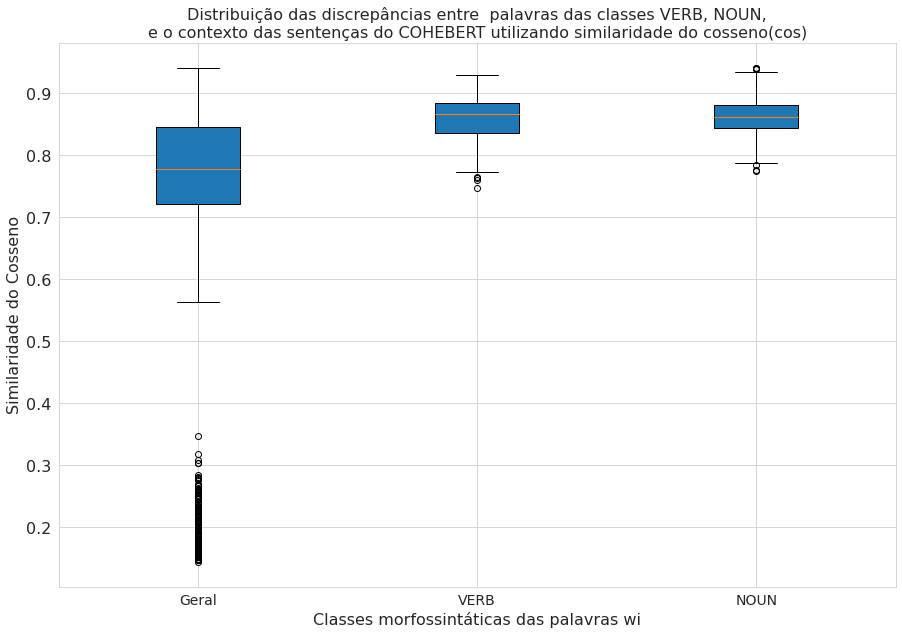

In [770]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do COHEBERT utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna()]

ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [771]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      euc_ctxverbnoun_mean euc_ctxverbnoun_mean euc_ctxverbnoun_mean
count         21917.000000          2144.000000          5448.000000
mean             25.047974            21.817504            20.746476
std               4.083796             3.201940             2.393341
min              13.450162            13.450162            14.569008
25%              22.133818            19.476600            19.145518
50%              25.245285            21.769080            20.730470
75%              27.911573            23.625577            22.155801
max              40.750755            36.040161            37.192081

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


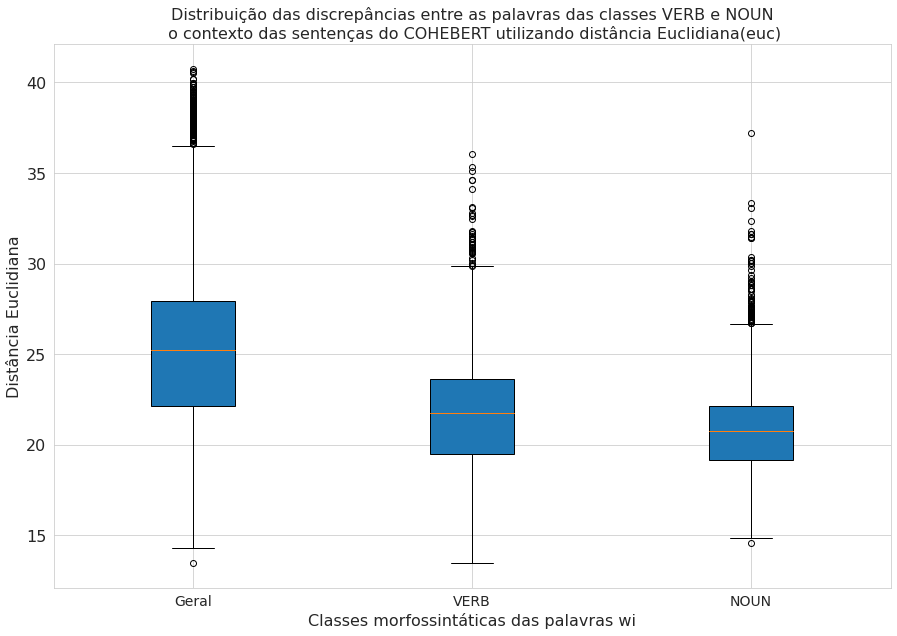

In [772]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do COHEBERT utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [773]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      man_ctxverbnoun_mean man_ctxverbnoun_mean man_ctxverbnoun_mean
count         21917.000000          2144.000000          5448.000000
mean           1190.935237          1025.778449           974.842090
std             190.665161           132.949316           103.451784
min             655.001100           655.001100           697.053400
25%            1045.048700           930.330340           899.060485
50%            1198.304200          1013.582780           980.612200
75%            1353.606800          1120.168650          1044.686500
max            1689.013500          1447.413000          1345.252200

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


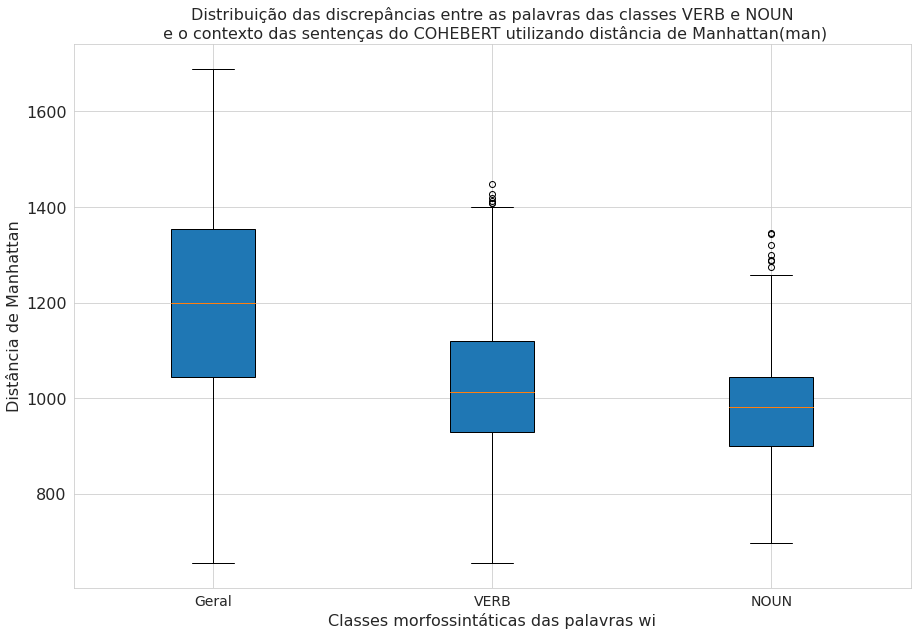

In [774]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do COHEBERT utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

## 3.6 Ocorrências palavras e contexto

### Indexa os dados das comparações pelo id do documento

In [775]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id"])
lista_comparacao_contexto_indexado.head()

index_documento  index_sentenca  index_wi          wi  pos_i  \
id                                                                  
1p0                0               0         0        Como  SCONJ   
1p0                0               0         1  enfileirar   VERB   
1p0                0               0         2   elementos   NOUN   
1p0                0               0         3          em    ADP   
1p0                0               0         4         uma    DET   

     cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
id                                                                          
1p0         0.841748        20.751820      1034.941500           0.795572   
1p0         0.954515        10.737125       523.811160           0.898605   
1p0         0.814813        24.378838      1160.397500           0.876309   
1p0         0.852682        21.636595      1064.251200           0.790931   
1p0         0.858393        19.244085       930.500850           0.801362   

     euc_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
id                      ...                                      
1p0          23.499792  ...       1144.704600         0.761694   
1p0          15.842593  ...       1234.617900         0.872167   
1p0          20.454411  ...        977.415300         0.720366   
1p0          25.292688  ...       1225.764200         0.771051   
1p0          22.730692  ...       1092.479000         0.764485   

     euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
id                                                                        
1p0        25.747263      1281.734253         0.662819        31.183723   
1p0        19.438112      1053.671265         0.657018        32.020443   
1p0        29.690674      1416.652832         0.925978        15.929137   
1p0        26.600965      1313.486572         0.733301        28.994362   
1p0        25.204029      1238.603394         0.732217        27.432117   

     man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
id                                                               
1p0      1489.083300             0.731686            27.094843   
1p0      1506.721900             0.765188            25.968431   
1p0       743.386170             0.905086            18.107382   
1p0      1367.192600             0.785087            25.713667   
1p0      1291.054800             0.782077            24.047911   

     man_ctxverbnoun_max  
id                        
1p0          1318.888400  
1p0          1244.791300  
1p0           859.391660  
1p0          1234.252700  
1p0          1147.287000  

[5 rows x 35 columns]

### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [776]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

Número de comparações : 21917
Média medida cos_ctxall_mean  :  0.8155416798220666


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [777]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações 
    if len(linha1[1]) != 0:

      # Percorre as comparações 
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/2020 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [778]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida cos ,estratégia mean e equação ctxall acima do threshold com o contexto
1 ?(PUNCT)  2021
2 uma(DET)  2020
3 elementos(NOUN)  1212
4 em(ADP)  1212
5 e(CCONJ)  1176
6 fila(NOUN)  1012
7 é(AUX)  814
8 O(PRON)  808
9 que(PRON)  808
10 como(ADV)  713
11 pilha(NOUN)  710
12 elemento(NOUN)  606
13 Como(SCONJ)  441
14 um(DET)  404
15 nela(PRON)  404
16 de(ADP)  398
17 desempilhar(NOUN)  392
18 Como(ADV)  360
19 de(SCONJ)  310
20 estrutura(NOUN)  305


### 3.6.2 Distância Euclidiana

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [779]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'euc' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

Número de comparações : 21917
Média medida euc_ctxall_mean  :  22.76963707386547


#### 3.6.2.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [780]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/2020 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [781]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida euc ,estratégia mean e equação ctxall acima do threshold com o contexto
1 ?(PUNCT)  2021
2 uma(DET)  2020
3 e(CCONJ)  1415
4 elementos(NOUN)  1212
5 em(ADP)  1212
6 fila(NOUN)  1012
7 é(AUX)  814
8 O(PRON)  808
9 que(PRON)  808
10 como(ADV)  713
11 pilha(NOUN)  710
12 elemento(NOUN)  606
13 Como(SCONJ)  441
14 um(DET)  404
15 nela(PRON)  404
16 de(ADP)  398
17 desempilhar(NOUN)  392
18 Como(ADV)  360
19 de(SCONJ)  310
20 estrutura(NOUN)  305


### 3.6.3 Distância de Manhattan

#### 3.6.3.1 Organiza as comparações das palavras antes e depois da palavra chave

In [782]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'man' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/2020 [00:00<?, ? documento/s]

Número de comparações : 21917
Média medida man_ctxall_mean  :  1091.2626651407545


#### 3.6.3.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [783]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/2020 [00:00<?, ? comparação/s]

#### 3.6.3.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [784]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida man ,estratégia mean e equação ctxall acima do threshold com o contexto
1 ?(PUNCT)  2021
2 uma(DET)  2020
3 e(CCONJ)  1415
4 elementos(NOUN)  1212
5 em(ADP)  1212
6 fila(NOUN)  1012
7 é(AUX)  814
8 O(PRON)  808
9 que(PRON)  808
10 como(ADV)  713
11 pilha(NOUN)  710
12 elemento(NOUN)  606
13 Como(SCONJ)  441
14 um(DET)  404
15 nela(PRON)  404
16 de(ADP)  398
17 desempilhar(NOUN)  392
18 Como(ADV)  360
19 de(SCONJ)  310
20 estrutura(NOUN)  305


# 4 Finalização

## 4.1 Tempo final de processamento



In [785]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:24:08 (h:mm:ss)
